##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [8]:
cd drive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris/

[Errno 2] No such file or directory: 'drive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris/'
/content/drive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris


In [9]:
pwd

'/content/drive/My Drive/SIADS_697_698_alanfeh_gpthio_nalurris'

# Object Detection


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=google%2Ffaster_rcnn%2Fopenimages_v4%2Finception_resnet_v2%2F1%20OR%20google%2Ffaster_rcnn%2Fopenimages_v4%2Finception_resnet_v2%2F1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This Colab demonstrates use of a TF-Hub module trained to perform object detection.

## Setup


In [10]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.5.0
The following GPU devices are available: /device:GPU:0


In [25]:
!pip install tqdm

import pandas as pd
import numpy as np
from tqdm import tqdm

## Example use

### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [12]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## Apply module

Load a public image from Open Images v4, save locally, and display.

In [13]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Output hidden; open in https://colab.research.google.com to view.

## Load sample image from BLS OOH

Image downloaded to /tmp/tmpuqbemt45.jpg.


'/tmp/tmpuqbemt45.jpg'

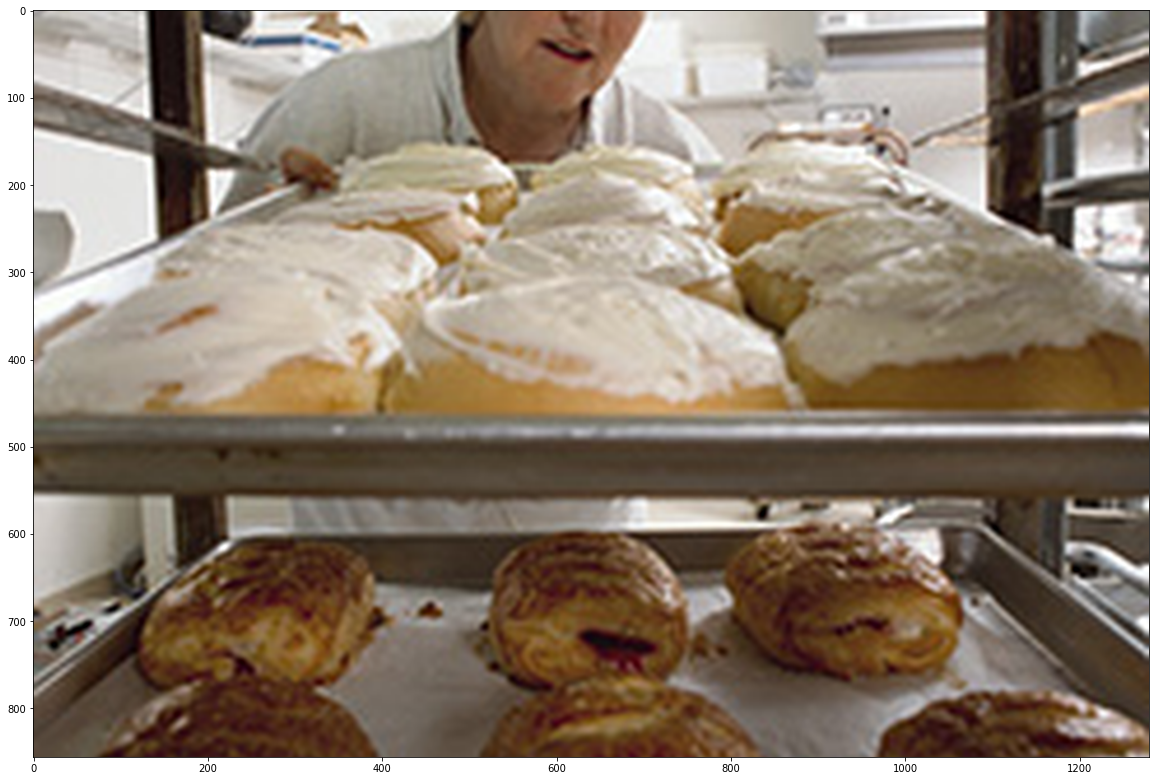

In [14]:
# Image #2 for Bakers
downloaded_image_path = download_and_resize_image("https://www.bls.gov/ooh/images/3074.jpg", 1280, 856, display=True)
downloaded_image_path

Image downloaded to /tmp/tmppnfkr4m_.jpg.


'/tmp/tmppnfkr4m_.jpg'

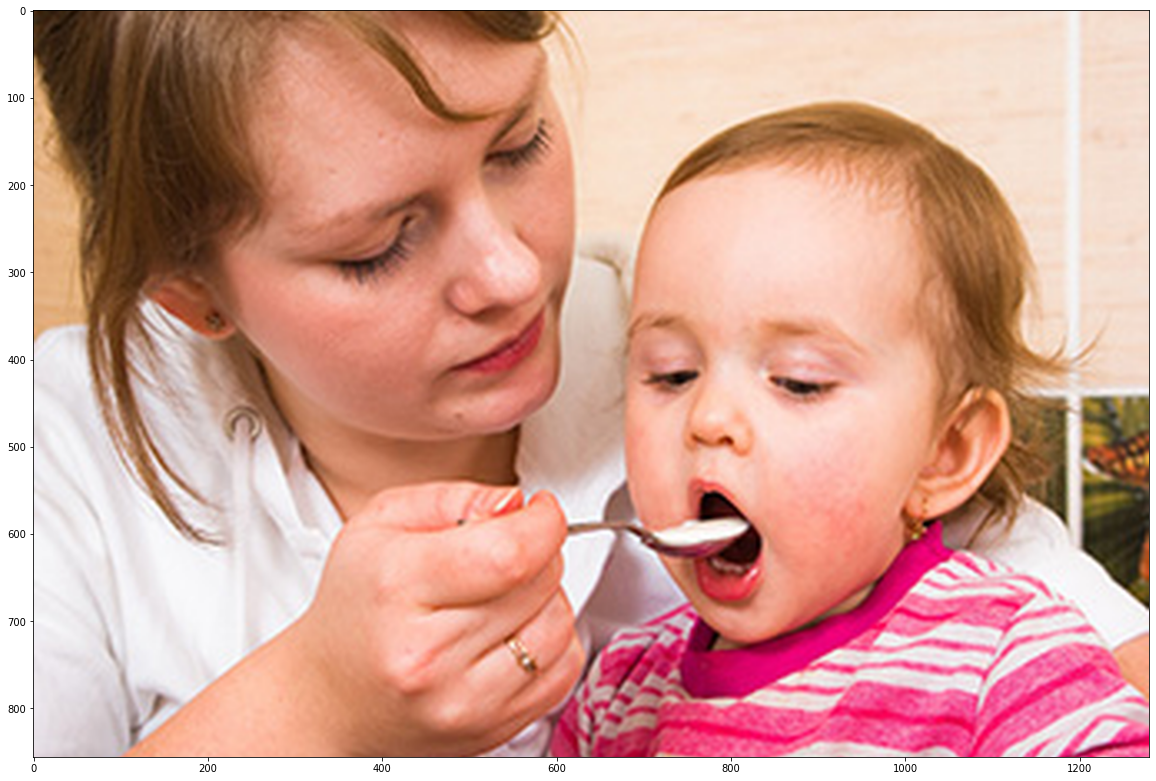

In [31]:
# Image #2 for Childcare Workers
downloaded_image_path = download_and_resize_image("https://www.bls.gov/ooh/images/2734.jpg", 1280, 856, display=True)
downloaded_image_path

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [15]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [16]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [18]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  # image_with_boxes = draw_boxes(
  #     img.numpy(), result["detection_boxes"],
  #     result["detection_class_entities"], result["detection_scores"])

  # display_image(image_with_boxes)

  return result["detection_class_entities"]

In [19]:
results = run_detector(detector, downloaded_image_path)

Found 100 objects.
Inference time:  59.72040247917175


In [20]:
results

array([b'Human face', b'Cookie', b'Cookie', b'Person', b'Food', b'Snack',
       b'Snack', b'Clothing', b'Man', b'Dessert', b'Pastry', b'Cookie',
       b'Baked goods', b'Dessert', b'Snack', b'Snack', b'Dessert',
       b'Baked goods', b'Snack', b'Snack', b'Baked goods', b'Pastry',
       b'Cookie', b'Dessert', b'Fast food', b'Dessert', b'Snack', b'Food',
       b'Fast food', b'Dessert', b'Snack', b'Dessert', b'Food', b'Pastry',
       b'Cake', b'Food', b'Baked goods', b'Fast food', b'Cookie',
       b'Baked goods', b'Food', b'Bread', b'Fast food', b'Food',
       b'Clothing', b'Dessert', b'Dessert', b'Human head', b'Fast food',
       b'Muffin', b'Food', b'Baked goods', b'Cookie', b'Snack', b'Food',
       b'Muffin', b'Human hand', b'Dessert', b'Dessert', b'Dairy',
       b'Food', b'Pastry', b'Dessert', b'Muffin', b'Baked goods',
       b'Dessert', b'Fast food', b'Dairy', b'Dessert', b'Food', b'Dairy',
       b'Snack', b'Snack', b'Baked goods', b'Man', b'Snack', b'Bread',
       b'Foo

In [21]:
pwd

'/content/drive/MyDrive/SIADS_697_698_alanfeh_gpthio_nalurris'

In [48]:
ooh_images = pd.read_csv("predicting_demographics/data/OOH_Image_Data.txt", delimiter="|")
ooh_images

,Title,Image_1,Image_2,Image_3,Image_4
0,Accountants and Auditors,https://www.bls.gov/ooh/images/15122.jpg,https://www.bls.gov/ooh/images/1740.jpg,https://www.bls.gov/ooh/images/1741.jpg,https://www.bls.gov/ooh/images/1743.jpg
1,Actors,https://www.bls.gov/ooh/images/15292.jpg,https://www.bls.gov/ooh/images/2284.jpg,https://www.bls.gov/ooh/images/2286.jpg,https://www.bls.gov/ooh/images/2287.jpg
2,Actuaries,https://www.bls.gov/ooh/images/15610.jpg,https://www.bls.gov/ooh/images/1827.jpg,https://www.bls.gov/ooh/images/1829.jpg,https://www.bls.gov/ooh/images/3641.jpg
3,Administrative Services and Facilities Managers,https://www.bls.gov/ooh/images/15556.jpg,https://www.bls.gov/ooh/images/1589.jpg,https://www.bls.gov/ooh/images/1590.jpg,https://www.bls.gov/ooh/images/1591.jpg
4,Adult Basic and Secondary Education and ESL Te...,https://www.bls.gov/ooh/images/15262.jpg,https://www.bls.gov/ooh/images/15263.jpg,https://www.bls.gov/ooh/images/2199.jpg,https://www.bls.gov/ooh/images/2200.jpg
...,...,...,...,...,...
319,Wholesale and Manufacturing Sales Representatives,https://www.bls.gov/ooh/images/15773.jpg,https://www.bls.gov/ooh/images/2782.jpg,https://www.bls.gov/ooh/images/2784.jpg,https://www.bls.gov/ooh/images/2785.jpg
320,Wind Turbine Technicians,https://www.bls.gov/ooh/images/15479.jpg,https://www.bls.gov/ooh/images/15481.jpg,https://www.bls.gov/ooh/images/15482.jpg,https://www.bls.gov/ooh/images/15478.jpg
321,Woodworkers,https://www.bls.gov/ooh/images/15741.jpg,https://www.bls.gov/ooh/images/3111.jpg,https://www.bls.gov/ooh/images/3112.jpg,https://www.bls.gov/ooh/images/3113.jpg
322,Writers and Authors,https://www.bls.gov/ooh/images/15644.jpg,https://www.bls.gov/ooh/images/2354.jpg,https://www.bls.gov/ooh/images/15645.jpg,https://www.bls.gov/ooh/images/15643.jpg


In [34]:
ooh_images.loc[0]["Image_1"]

'https://www.bls.gov/ooh/images/15122.jpg'

In [52]:
# Copy ooh_images df
ooh_objects = ooh_images.copy()

# Create new columns to store list of detected objects and length of list
ooh_objects["objects"] = None
ooh_objects["length"] = None

# Run module on all images
for i in tqdm(range(len(ooh_objects))):
  object_list = []

  for j in range(1, 5):
    if pd.isnull(ooh_objects.iloc[i, j]):
      pass
    else:
      downloaded_image_path = download_and_resize_image(ooh_objects.iloc[i, j], 1280, 856, display=False)
      words = run_detector(detector, downloaded_image_path)
    
      for word in words:
        obj = word.decode("utf-8")
        object_list.append(obj)

    ooh_objects["objects"].loc[i] = list(set(object_list))
    ooh_objects["length"].loc[i] = len(ooh_objects["objects"].loc[i])

ooh_objects.to_csv("ooh_objects", index=False)
ooh_objects



  0%|          | 0/324 [00:00<?, ?it/s]

Image downloaded to /tmp/tmpzew6tv91.jpg.
Found 100 objects.
Inference time:  1.3322358131408691
Image downloaded to /tmp/tmpowx9npdv.jpg.
Found 100 objects.
Inference time:  1.2590601444244385
Image downloaded to /tmp/tmpugb8rlil.jpg.
Found 100 objects.
Inference time:  1.266620397567749
Image downloaded to /tmp/tmp0i58x34z.jpg.




  0%|          | 1/324 [00:05<29:51,  5.55s/it]

Found 100 objects.
Inference time:  1.2788004875183105
Image downloaded to /tmp/tmplcazre95.jpg.
Found 100 objects.
Inference time:  1.2614185810089111
Image downloaded to /tmp/tmpzqw3n605.jpg.
Found 100 objects.
Inference time:  1.2896089553833008
Image downloaded to /tmp/tmpsp7a7oqn.jpg.
Found 100 objects.
Inference time:  1.302999496459961
Image downloaded to /tmp/tmpruyy6p6f.jpg.




  1%|          | 2/324 [00:11<29:46,  5.55s/it]

Found 100 objects.
Inference time:  1.2892107963562012
Image downloaded to /tmp/tmpe9d9j2ee.jpg.
Found 100 objects.
Inference time:  1.3219068050384521
Image downloaded to /tmp/tmpm6np2bp8.jpg.
Found 100 objects.
Inference time:  1.3345866203308105
Image downloaded to /tmp/tmpvyk_svgv.jpg.
Found 100 objects.
Inference time:  1.34234619140625
Image downloaded to /tmp/tmp4rlbyynf.jpg.




  1%|          | 3/324 [00:17<30:18,  5.67s/it]

Found 100 objects.
Inference time:  1.3302664756774902
Image downloaded to /tmp/tmpuzh7z1ay.jpg.
Found 100 objects.
Inference time:  1.3461706638336182
Image downloaded to /tmp/tmpnhynkujj.jpg.
Found 100 objects.
Inference time:  1.3318021297454834
Image downloaded to /tmp/tmp6elb9la6.jpg.
Found 100 objects.
Inference time:  1.3311128616333008
Image downloaded to /tmp/tmps8uzdeg2.jpg.




  1%|          | 4/324 [00:22<30:25,  5.70s/it]

Found 100 objects.
Inference time:  1.3618652820587158
Image downloaded to /tmp/tmp9_dp35my.jpg.
Found 100 objects.
Inference time:  1.3581268787384033
Image downloaded to /tmp/tmpducb21x1.jpg.
Found 100 objects.
Inference time:  1.3590402603149414
Image downloaded to /tmp/tmpeybd8zb9.jpg.
Found 100 objects.
Inference time:  1.342611312866211
Image downloaded to /tmp/tmpq9e57ds3.jpg.




  2%|▏         | 5/324 [00:28<30:38,  5.76s/it]

Found 100 objects.
Inference time:  1.351722240447998
Image downloaded to /tmp/tmp_taipasb.jpg.
Found 100 objects.
Inference time:  1.3526453971862793
Image downloaded to /tmp/tmpjjiftub6.jpg.
Found 100 objects.
Inference time:  1.3460750579833984
Image downloaded to /tmp/tmpmh89w9si.jpg.
Found 100 objects.
Inference time:  1.340456247329712
Image downloaded to /tmp/tmp3vgp771k.jpg.




  2%|▏         | 6/324 [00:34<30:33,  5.77s/it]

Found 100 objects.
Inference time:  1.3029844760894775
Image downloaded to /tmp/tmpe4gk3cv5.jpg.
Found 100 objects.
Inference time:  1.322202205657959
Image downloaded to /tmp/tmpx586mn4t.jpg.
Found 100 objects.
Inference time:  1.3003313541412354
Image downloaded to /tmp/tmpwu8k9x2s.jpg.
Found 100 objects.
Inference time:  1.2762291431427002
Image downloaded to /tmp/tmpvlua2bfa.jpg.




  2%|▏         | 7/324 [00:40<30:17,  5.73s/it]

Found 100 objects.
Inference time:  1.3000757694244385
Image downloaded to /tmp/tmp56b1qvm_.jpg.
Found 100 objects.
Inference time:  1.2841770648956299
Image downloaded to /tmp/tmpfabztndb.jpg.
Found 100 objects.
Inference time:  1.2752344608306885
Image downloaded to /tmp/tmp83cuvkqj.jpg.
Found 100 objects.
Inference time:  1.2735469341278076
Image downloaded to /tmp/tmpr2koms7u.jpg.




  2%|▏         | 8/324 [00:45<29:53,  5.68s/it]

Found 100 objects.
Inference time:  1.268883228302002
Image downloaded to /tmp/tmpg4jjk_yh.jpg.
Found 100 objects.
Inference time:  1.2771358489990234
Image downloaded to /tmp/tmpfn_cjisd.jpg.
Found 100 objects.
Inference time:  1.2674572467803955
Image downloaded to /tmp/tmp8ei3fvn8.jpg.
Found 100 objects.
Inference time:  1.284388542175293
Image downloaded to /tmp/tmpo1b72kc2.jpg.




  3%|▎         | 9/324 [00:51<29:32,  5.63s/it]

Found 100 objects.
Inference time:  1.2680318355560303
Image downloaded to /tmp/tmpf8fzgvhi.jpg.
Found 100 objects.
Inference time:  1.2953388690948486
Image downloaded to /tmp/tmpglxn14q0.jpg.
Found 100 objects.
Inference time:  1.2678465843200684
Image downloaded to /tmp/tmp75v3v2bb.jpg.
Found 100 objects.
Inference time:  1.2567193508148193
Image downloaded to /tmp/tmpio8jv0zr.jpg.




  3%|▎         | 10/324 [00:56<29:13,  5.59s/it]

Found 100 objects.
Inference time:  1.2627167701721191
Image downloaded to /tmp/tmpw_ia8k8m.jpg.
Found 100 objects.
Inference time:  1.2625885009765625
Image downloaded to /tmp/tmpbtvr2ww3.jpg.
Found 100 objects.
Inference time:  1.273284673690796
Image downloaded to /tmp/tmprs9ih6df.jpg.
Found 100 objects.
Inference time:  1.2610390186309814
Image downloaded to /tmp/tmpwpr9nfp1.jpg.




  3%|▎         | 11/324 [01:02<28:55,  5.55s/it]

Found 100 objects.
Inference time:  1.2470133304595947
Image downloaded to /tmp/tmpbggsdo2r.jpg.
Found 100 objects.
Inference time:  1.2697548866271973
Image downloaded to /tmp/tmpuez3uomz.jpg.
Found 100 objects.
Inference time:  1.2907578945159912
Image downloaded to /tmp/tmp9kah7qtp.jpg.
Found 100 objects.
Inference time:  1.264967441558838
Image downloaded to /tmp/tmpb3xk6d08.jpg.




  4%|▎         | 12/324 [01:07<28:49,  5.54s/it]

Found 100 objects.
Inference time:  1.253737211227417
Image downloaded to /tmp/tmpgshe98pk.jpg.
Found 100 objects.
Inference time:  1.267146348953247
Image downloaded to /tmp/tmpr5ivcrkz.jpg.
Found 100 objects.
Inference time:  1.2407200336456299
Image downloaded to /tmp/tmppmialcq3.jpg.
Found 100 objects.
Inference time:  1.257000207901001
Image downloaded to /tmp/tmpw2arensv.jpg.




  4%|▍         | 13/324 [01:13<28:35,  5.51s/it]

Found 100 objects.
Inference time:  1.2494053840637207
Image downloaded to /tmp/tmptyqnooa8.jpg.
Found 100 objects.
Inference time:  1.2575194835662842
Image downloaded to /tmp/tmp2bojn2jl.jpg.
Found 100 objects.
Inference time:  1.265864372253418
Image downloaded to /tmp/tmpnex2t9wg.jpg.
Found 100 objects.
Inference time:  1.2493526935577393
Image downloaded to /tmp/tmpz2f41r_z.jpg.




  4%|▍         | 14/324 [01:18<28:24,  5.50s/it]

Found 100 objects.
Inference time:  1.2570059299468994
Image downloaded to /tmp/tmpm4uhbjig.jpg.
Found 100 objects.
Inference time:  1.3037397861480713
Image downloaded to /tmp/tmp811aok6d.jpg.
Found 100 objects.
Inference time:  1.2864725589752197
Image downloaded to /tmp/tmpcj1l6fb3.jpg.
Found 100 objects.
Inference time:  1.2835469245910645
Image downloaded to /tmp/tmp0o35q2d7.jpg.




  5%|▍         | 15/324 [01:24<28:25,  5.52s/it]

Found 100 objects.
Inference time:  1.2947909832000732
Image downloaded to /tmp/tmpt74ca3y6.jpg.
Found 100 objects.
Inference time:  1.2890291213989258
Image downloaded to /tmp/tmpwkeds3e2.jpg.
Found 100 objects.
Inference time:  1.2832624912261963
Image downloaded to /tmp/tmpnlinmgy3.jpg.
Found 100 objects.
Inference time:  1.2906360626220703
Image downloaded to /tmp/tmpzyqrarei.jpg.




  5%|▍         | 16/324 [01:29<28:30,  5.55s/it]

Found 100 objects.
Inference time:  1.2976243495941162
Image downloaded to /tmp/tmpi2dvuei7.jpg.
Found 100 objects.
Inference time:  1.2979614734649658
Image downloaded to /tmp/tmp3zrjimir.jpg.
Found 100 objects.
Inference time:  1.2922005653381348
Image downloaded to /tmp/tmpr2v0gf2f.jpg.
Found 100 objects.
Inference time:  1.2998969554901123
Image downloaded to /tmp/tmpqpx8z8r8.jpg.




  5%|▌         | 17/324 [01:35<28:31,  5.58s/it]

Found 100 objects.
Inference time:  1.3103587627410889
Image downloaded to /tmp/tmpvdduxt21.jpg.
Found 100 objects.
Inference time:  1.2938251495361328
Image downloaded to /tmp/tmp9pmnft67.jpg.
Found 100 objects.
Inference time:  1.3185980319976807
Image downloaded to /tmp/tmpc17x1lv7.jpg.
Found 100 objects.
Inference time:  1.3087685108184814
Image downloaded to /tmp/tmp3s8j51pr.jpg.




  6%|▌         | 18/324 [01:41<28:36,  5.61s/it]

Found 100 objects.
Inference time:  1.3193964958190918
Image downloaded to /tmp/tmp22bvgs2s.jpg.
Found 100 objects.
Inference time:  1.309877872467041
Image downloaded to /tmp/tmpa7pte2hm.jpg.
Found 100 objects.
Inference time:  1.3066167831420898
Image downloaded to /tmp/tmpl_u91tee.jpg.
Found 100 objects.
Inference time:  1.3015315532684326
Image downloaded to /tmp/tmp659jacw0.jpg.




  6%|▌         | 19/324 [01:46<28:29,  5.61s/it]

Found 100 objects.
Inference time:  1.2664642333984375
Image downloaded to /tmp/tmpzm0r73ex.jpg.
Found 100 objects.
Inference time:  1.27451753616333
Image downloaded to /tmp/tmp2hj6jy9h.jpg.
Found 100 objects.
Inference time:  1.2865619659423828
Image downloaded to /tmp/tmp35cb85ti.jpg.
Found 100 objects.
Inference time:  1.2794640064239502
Image downloaded to /tmp/tmpq4uqjct2.jpg.




  6%|▌         | 20/324 [01:52<28:17,  5.58s/it]

Found 100 objects.
Inference time:  1.2723407745361328
Image downloaded to /tmp/tmpgqeyx7p9.jpg.
Found 100 objects.
Inference time:  1.2804112434387207
Image downloaded to /tmp/tmp34w5lizx.jpg.
Found 100 objects.
Inference time:  1.2892684936523438
Image downloaded to /tmp/tmpjlvqr2kx.jpg.
Found 100 objects.
Inference time:  1.2743995189666748
Image downloaded to /tmp/tmpjcvyfabc.jpg.




  6%|▋         | 21/324 [01:57<28:08,  5.57s/it]

Found 100 objects.
Inference time:  1.2802269458770752
Image downloaded to /tmp/tmprftxjz9p.jpg.
Found 100 objects.
Inference time:  1.2808306217193604
Image downloaded to /tmp/tmpk0ozu155.jpg.
Found 100 objects.
Inference time:  1.278829574584961
Image downloaded to /tmp/tmpeck86v5_.jpg.
Found 100 objects.
Inference time:  1.278472900390625
Image downloaded to /tmp/tmpl_j2j3qi.jpg.




  7%|▋         | 22/324 [02:03<27:58,  5.56s/it]

Found 100 objects.
Inference time:  1.2782776355743408
Image downloaded to /tmp/tmpbniu9cey.jpg.
Found 100 objects.
Inference time:  1.2755718231201172
Image downloaded to /tmp/tmpm412jdgz.jpg.
Found 100 objects.
Inference time:  1.2599778175354004
Image downloaded to /tmp/tmpbz6n48nn.jpg.
Found 100 objects.
Inference time:  1.2721381187438965
Image downloaded to /tmp/tmpg134o3bw.jpg.




  7%|▋         | 23/324 [02:08<27:47,  5.54s/it]

Found 100 objects.
Inference time:  1.2897160053253174
Image downloaded to /tmp/tmprh9z6vue.jpg.
Found 100 objects.
Inference time:  1.2585790157318115
Image downloaded to /tmp/tmpalfgmprv.jpg.
Found 100 objects.
Inference time:  1.2714390754699707
Image downloaded to /tmp/tmpo78rcdt_.jpg.
Found 100 objects.
Inference time:  1.2858433723449707
Image downloaded to /tmp/tmph8vhggmr.jpg.




  7%|▋         | 24/324 [02:14<27:40,  5.54s/it]

Found 100 objects.
Inference time:  1.2764644622802734
Image downloaded to /tmp/tmpxxlr0fgs.jpg.
Found 100 objects.
Inference time:  1.2664415836334229
Image downloaded to /tmp/tmpxn2a4j4m.jpg.
Found 100 objects.
Inference time:  1.2714247703552246
Image downloaded to /tmp/tmp4kt89mh7.jpg.
Found 100 objects.
Inference time:  1.2605550289154053
Image downloaded to /tmp/tmp5rvfen4o.jpg.




  8%|▊         | 25/324 [02:19<27:31,  5.52s/it]

Found 100 objects.
Inference time:  1.2570281028747559
Image downloaded to /tmp/tmp2ileed7q.jpg.
Found 100 objects.
Inference time:  1.2605745792388916
Image downloaded to /tmp/tmpi6q1hdko.jpg.
Found 100 objects.
Inference time:  1.2565300464630127
Image downloaded to /tmp/tmpsocf_2d8.jpg.
Found 100 objects.
Inference time:  1.266552448272705
Image downloaded to /tmp/tmp9458xf40.jpg.




  8%|▊         | 26/324 [02:25<27:22,  5.51s/it]

Found 100 objects.
Inference time:  1.294701099395752
Image downloaded to /tmp/tmp94gxwzd9.jpg.
Found 100 objects.
Inference time:  1.2793278694152832
Image downloaded to /tmp/tmpkywvbtxr.jpg.
Found 100 objects.
Inference time:  1.2853360176086426
Image downloaded to /tmp/tmpsofcfguj.jpg.
Found 100 objects.
Inference time:  1.2750287055969238
Image downloaded to /tmp/tmpelju5fc4.jpg.




  8%|▊         | 27/324 [02:30<27:22,  5.53s/it]

Found 100 objects.
Inference time:  1.3016271591186523
Image downloaded to /tmp/tmp3wegag3n.jpg.
Found 100 objects.
Inference time:  1.2854878902435303
Image downloaded to /tmp/tmpr0_d9n4q.jpg.
Found 100 objects.
Inference time:  1.3036341667175293
Image downloaded to /tmp/tmp74yusxdu.jpg.
Found 100 objects.
Inference time:  1.3045363426208496
Image downloaded to /tmp/tmpjbqnwp4k.jpg.




  9%|▊         | 28/324 [02:36<27:25,  5.56s/it]

Found 100 objects.
Inference time:  1.273367166519165
Image downloaded to /tmp/tmpwgcn1e_3.jpg.
Found 100 objects.
Inference time:  1.2872166633605957
Image downloaded to /tmp/tmp6wg4t4hv.jpg.
Found 100 objects.
Inference time:  1.2792255878448486
Image downloaded to /tmp/tmpnmhh297b.jpg.
Found 100 objects.
Inference time:  1.2918660640716553
Image downloaded to /tmp/tmpnwesbp2e.jpg.




  9%|▉         | 29/324 [02:42<27:22,  5.57s/it]

Found 100 objects.
Inference time:  1.306412696838379
Image downloaded to /tmp/tmpg4k2twyn.jpg.
Found 100 objects.
Inference time:  1.2806766033172607
Image downloaded to /tmp/tmpjzwly7yf.jpg.
Found 100 objects.
Inference time:  1.2892510890960693
Image downloaded to /tmp/tmp18q9umcr.jpg.
Found 100 objects.
Inference time:  1.307570457458496
Image downloaded to /tmp/tmpb__nfkov.jpg.




  9%|▉         | 30/324 [02:47<27:19,  5.57s/it]

Found 100 objects.
Inference time:  1.2860198020935059
Image downloaded to /tmp/tmp5so2qxyp.jpg.
Found 100 objects.
Inference time:  1.2810437679290771
Image downloaded to /tmp/tmp7yrx573x.jpg.
Found 100 objects.
Inference time:  1.2678239345550537
Image downloaded to /tmp/tmpsfsxvmi3.jpg.
Found 100 objects.
Inference time:  1.2724714279174805
Image downloaded to /tmp/tmpqv3sg0kj.jpg.




 10%|▉         | 31/324 [02:53<27:05,  5.55s/it]

Found 100 objects.
Inference time:  1.24043869972229
Image downloaded to /tmp/tmps1g30un2.jpg.
Found 100 objects.
Inference time:  1.2601821422576904
Image downloaded to /tmp/tmpu3zg9jl8.jpg.
Found 100 objects.
Inference time:  1.2679214477539062
Image downloaded to /tmp/tmp87xutuiy.jpg.
Found 100 objects.
Inference time:  1.2597150802612305
Image downloaded to /tmp/tmp0pcpkhz9.jpg.




 10%|▉         | 32/324 [02:58<26:51,  5.52s/it]

Found 100 objects.
Inference time:  1.265702486038208
Image downloaded to /tmp/tmp90v8n4_r.jpg.
Found 100 objects.
Inference time:  1.26241135597229
Image downloaded to /tmp/tmpnl8czwry.jpg.
Found 100 objects.
Inference time:  1.2776589393615723
Image downloaded to /tmp/tmpihsex5xy.jpg.
Found 100 objects.
Inference time:  1.2562570571899414
Image downloaded to /tmp/tmpdbpdf3uq.jpg.




 10%|█         | 33/324 [03:04<26:38,  5.49s/it]

Found 100 objects.
Inference time:  1.2591335773468018
Image downloaded to /tmp/tmp3_ouz7q6.jpg.
Found 100 objects.
Inference time:  1.2745451927185059
Image downloaded to /tmp/tmp3u08o427.jpg.
Found 100 objects.
Inference time:  1.2569923400878906
Image downloaded to /tmp/tmp2mfm1x9_.jpg.
Found 100 objects.
Inference time:  1.2816803455352783
Image downloaded to /tmp/tmphcsz3x6p.jpg.




 10%|█         | 34/324 [03:09<26:34,  5.50s/it]

Found 100 objects.
Inference time:  1.262284517288208
Image downloaded to /tmp/tmp5dcd1mju.jpg.
Found 100 objects.
Inference time:  1.2557272911071777
Image downloaded to /tmp/tmp2g9iqzv8.jpg.
Found 100 objects.
Inference time:  1.2568576335906982
Image downloaded to /tmp/tmpu54nwx7_.jpg.
Found 100 objects.
Inference time:  1.2569396495819092
Image downloaded to /tmp/tmpt9ctgjtb.jpg.




 11%|█         | 35/324 [03:14<26:21,  5.47s/it]

Found 100 objects.
Inference time:  1.2607522010803223
Image downloaded to /tmp/tmpu2yqfupy.jpg.
Found 100 objects.
Inference time:  1.292269229888916
Image downloaded to /tmp/tmpan8_067e.jpg.
Found 100 objects.
Inference time:  1.2538032531738281
Image downloaded to /tmp/tmpq384odxz.jpg.
Found 100 objects.
Inference time:  1.2572691440582275
Image downloaded to /tmp/tmpgov6aq72.jpg.




 11%|█         | 36/324 [03:20<26:17,  5.48s/it]

Found 100 objects.
Inference time:  1.2668066024780273
Image downloaded to /tmp/tmp1ccbxcj9.jpg.
Found 100 objects.
Inference time:  1.2603533267974854
Image downloaded to /tmp/tmp_p3px5mn.jpg.
Found 100 objects.
Inference time:  1.292233943939209
Image downloaded to /tmp/tmpgdoohkp7.jpg.
Found 100 objects.
Inference time:  1.254321575164795
Image downloaded to /tmp/tmprqo_8oe4.jpg.




 11%|█▏        | 37/324 [03:25<26:10,  5.47s/it]

Found 100 objects.
Inference time:  1.255535364151001
Image downloaded to /tmp/tmpcvikj17x.jpg.
Found 100 objects.
Inference time:  1.2637693881988525
Image downloaded to /tmp/tmpkk4eyfh7.jpg.
Found 100 objects.
Inference time:  1.258213996887207
Image downloaded to /tmp/tmp0mn4_ycz.jpg.
Found 100 objects.
Inference time:  1.2899253368377686
Image downloaded to /tmp/tmpq8gf194o.jpg.




 12%|█▏        | 38/324 [03:31<26:16,  5.51s/it]

Found 100 objects.
Inference time:  1.2909324169158936
Image downloaded to /tmp/tmp6fnjxukn.jpg.
Found 100 objects.
Inference time:  1.2802767753601074
Image downloaded to /tmp/tmpixroq2m5.jpg.
Found 100 objects.
Inference time:  1.274789810180664
Image downloaded to /tmp/tmp1bab6mxb.jpg.
Found 100 objects.
Inference time:  1.2891778945922852
Image downloaded to /tmp/tmpoyod2k18.jpg.




 12%|█▏        | 39/324 [03:37<26:15,  5.53s/it]

Found 100 objects.
Inference time:  1.2905795574188232
Image downloaded to /tmp/tmpd4gpo_0d.jpg.
Found 100 objects.
Inference time:  1.277726650238037
Image downloaded to /tmp/tmp7l8wm4d2.jpg.
Found 100 objects.
Inference time:  1.2777378559112549
Image downloaded to /tmp/tmp1r9tmtg0.jpg.
Found 100 objects.
Inference time:  1.2657668590545654
Image downloaded to /tmp/tmpkwqup466.jpg.




 12%|█▏        | 40/324 [03:42<26:07,  5.52s/it]

Found 100 objects.
Inference time:  1.278374433517456
Image downloaded to /tmp/tmpkvk8qpb0.jpg.
Found 100 objects.
Inference time:  1.2732675075531006
Image downloaded to /tmp/tmpa2frca80.jpg.
Found 100 objects.
Inference time:  1.2858974933624268
Image downloaded to /tmp/tmpuguxc2hm.jpg.
Found 100 objects.
Inference time:  1.2743725776672363
Image downloaded to /tmp/tmpp3cdy8al.jpg.




 13%|█▎        | 41/324 [03:48<26:06,  5.53s/it]

Found 100 objects.
Inference time:  1.2765583992004395
Image downloaded to /tmp/tmpkgoe262z.jpg.
Found 100 objects.
Inference time:  1.2887051105499268
Image downloaded to /tmp/tmppy7l68w0.jpg.
Found 100 objects.
Inference time:  1.2924716472625732
Image downloaded to /tmp/tmp602743gc.jpg.
Found 100 objects.
Inference time:  1.2767837047576904
Image downloaded to /tmp/tmp7kl7v1s9.jpg.




 13%|█▎        | 42/324 [03:53<26:07,  5.56s/it]

Found 100 objects.
Inference time:  1.3090691566467285
Image downloaded to /tmp/tmpxw4jpg67.jpg.
Found 100 objects.
Inference time:  1.2908456325531006
Image downloaded to /tmp/tmptb0ciqgn.jpg.
Found 100 objects.
Inference time:  1.2534379959106445
Image downloaded to /tmp/tmp274mg4xv.jpg.
Found 100 objects.
Inference time:  1.2618200778961182
Image downloaded to /tmp/tmp9dn92ibb.jpg.




 13%|█▎        | 43/324 [03:59<25:56,  5.54s/it]

Found 100 objects.
Inference time:  1.26017165184021
Image downloaded to /tmp/tmpcpywkea_.jpg.
Found 100 objects.
Inference time:  1.250483512878418
Image downloaded to /tmp/tmph1zc2csx.jpg.
Found 100 objects.
Inference time:  1.2775607109069824
Image downloaded to /tmp/tmpq65dqjf7.jpg.
Found 100 objects.
Inference time:  1.254277229309082
Image downloaded to /tmp/tmpdn2651uu.jpg.




 14%|█▎        | 44/324 [04:04<25:45,  5.52s/it]

Found 100 objects.
Inference time:  1.2805523872375488
Image downloaded to /tmp/tmptejrcfpc.jpg.
Found 100 objects.
Inference time:  1.2877509593963623
Image downloaded to /tmp/tmpgf4w8e29.jpg.
Found 100 objects.
Inference time:  1.2610816955566406
Image downloaded to /tmp/tmp56pdt_yr.jpg.
Found 100 objects.
Inference time:  1.2628767490386963
Image downloaded to /tmp/tmpczdfn2oc.jpg.




 14%|█▍        | 45/324 [04:10<25:39,  5.52s/it]

Found 100 objects.
Inference time:  1.2552874088287354
Image downloaded to /tmp/tmpjeasjc_0.jpg.
Found 100 objects.
Inference time:  1.2574143409729004
Image downloaded to /tmp/tmpuw1mmwwg.jpg.
Found 100 objects.
Inference time:  1.2732665538787842
Image downloaded to /tmp/tmpqtpe8r3d.jpg.
Found 100 objects.
Inference time:  1.2645888328552246
Image downloaded to /tmp/tmp0d1geele.jpg.




 14%|█▍        | 46/324 [04:15<25:31,  5.51s/it]

Found 100 objects.
Inference time:  1.2593448162078857
Image downloaded to /tmp/tmpbmalzd_l.jpg.
Found 100 objects.
Inference time:  1.2580487728118896
Image downloaded to /tmp/tmp4_4goa39.jpg.
Found 100 objects.
Inference time:  1.2587471008300781
Image downloaded to /tmp/tmp754yia8w.jpg.
Found 100 objects.
Inference time:  1.2488117218017578
Image downloaded to /tmp/tmpf019kp71.jpg.




 15%|█▍        | 47/324 [04:21<25:22,  5.49s/it]

Found 100 objects.
Inference time:  1.2861096858978271
Image downloaded to /tmp/tmp45ts17q_.jpg.
Found 100 objects.
Inference time:  1.2579622268676758
Image downloaded to /tmp/tmp8h6ou5e4.jpg.
Found 100 objects.
Inference time:  1.2578866481781006
Image downloaded to /tmp/tmptcfxpj3i.jpg.
Found 100 objects.
Inference time:  1.2583725452423096
Image downloaded to /tmp/tmpj3tgtbx0.jpg.




 15%|█▍        | 48/324 [04:26<25:15,  5.49s/it]

Found 100 objects.
Inference time:  1.2456715106964111
Image downloaded to /tmp/tmphdoj7pok.jpg.
Found 100 objects.
Inference time:  1.2543742656707764
Image downloaded to /tmp/tmp8svtxf36.jpg.
Found 100 objects.
Inference time:  1.2797627449035645
Image downloaded to /tmp/tmppwdarzh5.jpg.
Found 100 objects.
Inference time:  1.2565855979919434
Image downloaded to /tmp/tmp0noz_dbo.jpg.




 15%|█▌        | 49/324 [04:32<25:06,  5.48s/it]

Found 100 objects.
Inference time:  1.2533931732177734
Image downloaded to /tmp/tmp5d18he_i.jpg.
Found 100 objects.
Inference time:  1.2694523334503174
Image downloaded to /tmp/tmp_g2qobvm.jpg.
Found 100 objects.
Inference time:  1.2570343017578125
Image downloaded to /tmp/tmp6q3nf0z5.jpg.
Found 100 objects.
Inference time:  1.2600035667419434
Image downloaded to /tmp/tmpeshbt9s9.jpg.




 15%|█▌        | 50/324 [04:37<25:13,  5.52s/it]

Found 100 objects.
Inference time:  1.292637586593628
Image downloaded to /tmp/tmp58ewbz7i.jpg.
Found 100 objects.
Inference time:  1.294217824935913
Image downloaded to /tmp/tmpxd7v_bs4.jpg.
Found 100 objects.
Inference time:  1.2836551666259766
Image downloaded to /tmp/tmpwayb7a9y.jpg.
Found 100 objects.
Inference time:  1.2968204021453857
Image downloaded to /tmp/tmp5429scnp.jpg.




 16%|█▌        | 51/324 [04:43<25:15,  5.55s/it]

Found 100 objects.
Inference time:  1.278132677078247
Image downloaded to /tmp/tmptnirqhy0.jpg.
Found 100 objects.
Inference time:  1.3001272678375244
Image downloaded to /tmp/tmpl4yvdy35.jpg.
Found 100 objects.
Inference time:  1.302250623703003
Image downloaded to /tmp/tmpcy1wsxal.jpg.
Found 100 objects.
Inference time:  1.272287130355835
Image downloaded to /tmp/tmpqnwmkfqy.jpg.




 16%|█▌        | 52/324 [04:49<25:14,  5.57s/it]

Found 100 objects.
Inference time:  1.2928311824798584
Image downloaded to /tmp/tmphfl1hh80.jpg.
Found 100 objects.
Inference time:  1.307544469833374
Image downloaded to /tmp/tmpleaq239m.jpg.
Found 100 objects.
Inference time:  1.2964198589324951
Image downloaded to /tmp/tmpzlxavxzq.jpg.
Found 100 objects.
Inference time:  1.2946789264678955
Image downloaded to /tmp/tmp_7siax4q.jpg.




 16%|█▋        | 53/324 [04:54<25:20,  5.61s/it]

Found 100 objects.
Inference time:  1.2837603092193604
Image downloaded to /tmp/tmpj6_a3kdy.jpg.
Found 100 objects.
Inference time:  1.2811648845672607
Image downloaded to /tmp/tmp6prvsjvw.jpg.
Found 100 objects.
Inference time:  1.2985923290252686
Image downloaded to /tmp/tmpi1crxleb.jpg.
Found 100 objects.
Inference time:  1.2888751029968262
Image downloaded to /tmp/tmpt09zs1et.jpg.




 17%|█▋        | 54/324 [05:00<25:20,  5.63s/it]

Found 100 objects.
Inference time:  1.2968544960021973
Image downloaded to /tmp/tmpzkgmlje7.jpg.
Found 100 objects.
Inference time:  1.276371717453003
Image downloaded to /tmp/tmpux2o_31i.jpg.
Found 100 objects.
Inference time:  1.264822006225586
Image downloaded to /tmp/tmpigc8s7xv.jpg.
Found 100 objects.
Inference time:  1.253103494644165
Image downloaded to /tmp/tmpg2jzt295.jpg.




 17%|█▋        | 55/324 [05:05<25:11,  5.62s/it]

Found 100 objects.
Inference time:  1.2624635696411133
Image downloaded to /tmp/tmpub6gsiby.jpg.
Found 100 objects.
Inference time:  1.2458131313323975
Image downloaded to /tmp/tmp8481vdxp.jpg.
Found 100 objects.
Inference time:  1.257943868637085
Image downloaded to /tmp/tmp6awl67q1.jpg.
Found 100 objects.
Inference time:  1.299429178237915
Image downloaded to /tmp/tmpjfcjvt_0.jpg.




 17%|█▋        | 56/324 [05:11<24:56,  5.59s/it]

Found 100 objects.
Inference time:  1.3018710613250732
Image downloaded to /tmp/tmpaaifp__7.jpg.
Found 100 objects.
Inference time:  1.3154261112213135
Image downloaded to /tmp/tmp_r0qtsh4.jpg.
Found 100 objects.
Inference time:  1.2937335968017578
Image downloaded to /tmp/tmp8fgzkyd3.jpg.
Found 100 objects.
Inference time:  1.2941234111785889
Image downloaded to /tmp/tmphzj619tf.jpg.




 18%|█▊        | 57/324 [05:17<24:57,  5.61s/it]

Found 100 objects.
Inference time:  1.2800734043121338
Image downloaded to /tmp/tmpuiaof010.jpg.
Found 100 objects.
Inference time:  1.3030242919921875
Image downloaded to /tmp/tmpmz6moz7k.jpg.
Found 100 objects.
Inference time:  1.2959785461425781
Image downloaded to /tmp/tmpufm9vbc6.jpg.
Found 100 objects.
Inference time:  1.3185145854949951
Image downloaded to /tmp/tmpw4_lx7t3.jpg.




 18%|█▊        | 58/324 [05:22<25:02,  5.65s/it]

Found 100 objects.
Inference time:  1.3056344985961914
Image downloaded to /tmp/tmphltq3k8a.jpg.
Found 100 objects.
Inference time:  1.278855800628662
Image downloaded to /tmp/tmp89a31dhg.jpg.
Found 100 objects.
Inference time:  1.2876715660095215
Image downloaded to /tmp/tmpwkzmfzil.jpg.
Found 100 objects.
Inference time:  1.297938585281372
Image downloaded to /tmp/tmpqwn6cwal.jpg.




 18%|█▊        | 59/324 [05:28<24:52,  5.63s/it]

Found 100 objects.
Inference time:  1.2891950607299805
Image downloaded to /tmp/tmp4vqhzmlh.jpg.
Found 100 objects.
Inference time:  1.3220839500427246
Image downloaded to /tmp/tmppq1y48ew.jpg.
Found 100 objects.
Inference time:  1.2938940525054932
Image downloaded to /tmp/tmpsrhb9zp8.jpg.
Found 100 objects.
Inference time:  1.287583827972412
Image downloaded to /tmp/tmp5cuqpqzi.jpg.




 19%|█▊        | 60/324 [05:34<24:45,  5.63s/it]

Found 100 objects.
Inference time:  1.2829241752624512
Image downloaded to /tmp/tmptnbf4u1h.jpg.
Found 100 objects.
Inference time:  1.2597589492797852
Image downloaded to /tmp/tmp3jxbkqz7.jpg.
Found 100 objects.
Inference time:  1.2589404582977295
Image downloaded to /tmp/tmpocj62bm5.jpg.
Found 100 objects.
Inference time:  1.2544245719909668
Image downloaded to /tmp/tmpecya03le.jpg.




 19%|█▉        | 61/324 [05:39<24:28,  5.58s/it]

Found 100 objects.
Inference time:  1.2656357288360596
Image downloaded to /tmp/tmp7fvepzew.jpg.
Found 100 objects.
Inference time:  1.2646801471710205
Image downloaded to /tmp/tmp0khhrwi5.jpg.
Found 100 objects.
Inference time:  1.2573678493499756
Image downloaded to /tmp/tmpi57gc22y.jpg.
Found 100 objects.
Inference time:  1.2660226821899414
Image downloaded to /tmp/tmp4i6bbi1d.jpg.




 19%|█▉        | 62/324 [05:45<24:13,  5.55s/it]

Found 100 objects.
Inference time:  1.2598750591278076
Image downloaded to /tmp/tmpecrurb2a.jpg.
Found 100 objects.
Inference time:  1.2588951587677002
Image downloaded to /tmp/tmp4hc4u2wa.jpg.
Found 100 objects.
Inference time:  1.2588884830474854
Image downloaded to /tmp/tmpy4k62qp8.jpg.
Found 100 objects.
Inference time:  1.2810263633728027
Image downloaded to /tmp/tmpwodwf9mc.jpg.




 19%|█▉        | 63/324 [05:50<24:05,  5.54s/it]

Found 100 objects.
Inference time:  1.2748675346374512
Image downloaded to /tmp/tmpqog7f226.jpg.
Found 100 objects.
Inference time:  1.266829252243042
Image downloaded to /tmp/tmpvco5zs25.jpg.
Found 100 objects.
Inference time:  1.2520313262939453
Image downloaded to /tmp/tmpeblbo2lx.jpg.
Found 100 objects.
Inference time:  1.2474875450134277
Image downloaded to /tmp/tmptpu58eba.jpg.




 20%|█▉        | 64/324 [05:56<23:51,  5.51s/it]

Found 100 objects.
Inference time:  1.2532641887664795
Image downloaded to /tmp/tmpwol4evvf.jpg.
Found 100 objects.
Inference time:  1.2574973106384277
Image downloaded to /tmp/tmpxnsq3qfq.jpg.
Found 100 objects.
Inference time:  1.2570664882659912
Image downloaded to /tmp/tmpbfzn9qjj.jpg.
Found 100 objects.
Inference time:  1.2731800079345703
Image downloaded to /tmp/tmpep8p4q42.jpg.




 20%|██        | 65/324 [06:01<23:48,  5.52s/it]

Found 100 objects.
Inference time:  1.2597806453704834
Image downloaded to /tmp/tmpuyoxwirb.jpg.
Found 100 objects.
Inference time:  1.270822525024414
Image downloaded to /tmp/tmpqvigz4qp.jpg.
Found 100 objects.
Inference time:  1.2587857246398926
Image downloaded to /tmp/tmpoavfas3o.jpg.
Found 100 objects.
Inference time:  1.2678990364074707
Image downloaded to /tmp/tmpvk90amz5.jpg.




 20%|██        | 66/324 [06:07<23:41,  5.51s/it]

Found 100 objects.
Inference time:  1.2696614265441895
Image downloaded to /tmp/tmpid39ou52.jpg.
Found 100 objects.
Inference time:  1.2799673080444336
Image downloaded to /tmp/tmpehodsky6.jpg.
Found 100 objects.
Inference time:  1.2578644752502441
Image downloaded to /tmp/tmp1nelj7tx.jpg.
Found 100 objects.
Inference time:  1.262031078338623
Image downloaded to /tmp/tmp_kw0xfpr.jpg.




 21%|██        | 67/324 [06:12<23:39,  5.52s/it]

Found 100 objects.
Inference time:  1.259002447128296
Image downloaded to /tmp/tmp_i1n4zgu.jpg.
Found 100 objects.
Inference time:  1.268984079360962
Image downloaded to /tmp/tmplmx98sh9.jpg.
Found 100 objects.
Inference time:  1.2528407573699951
Image downloaded to /tmp/tmpagudmo9a.jpg.
Found 100 objects.
Inference time:  1.3001434803009033
Image downloaded to /tmp/tmprau_o6gh.jpg.




 21%|██        | 68/324 [06:18<23:35,  5.53s/it]

Found 100 objects.
Inference time:  1.2955543994903564
Image downloaded to /tmp/tmptnt7gjbd.jpg.
Found 100 objects.
Inference time:  1.2803924083709717
Image downloaded to /tmp/tmpxyrwnx5g.jpg.
Found 100 objects.
Inference time:  1.2825253009796143
Image downloaded to /tmp/tmpu0x8ntjd.jpg.
Found 100 objects.
Inference time:  1.29585862159729
Image downloaded to /tmp/tmp903d83uu.jpg.




 21%|██▏       | 69/324 [06:23<23:36,  5.56s/it]

Found 100 objects.
Inference time:  1.3043980598449707
Image downloaded to /tmp/tmpqwdjb9l8.jpg.
Found 100 objects.
Inference time:  1.2969305515289307
Image downloaded to /tmp/tmpq8vrpajz.jpg.
Found 100 objects.
Inference time:  1.2782618999481201
Image downloaded to /tmp/tmpgorsygz9.jpg.
Found 100 objects.
Inference time:  1.299656629562378
Image downloaded to /tmp/tmp1sj1fm5s.jpg.




 22%|██▏       | 70/324 [06:29<23:33,  5.57s/it]

Found 100 objects.
Inference time:  1.2854335308074951
Image downloaded to /tmp/tmp2pdczw_s.jpg.
Found 100 objects.
Inference time:  1.2725176811218262
Image downloaded to /tmp/tmp015pfhnm.jpg.
Found 100 objects.
Inference time:  1.299720048904419
Image downloaded to /tmp/tmpfa193lo8.jpg.
Found 100 objects.
Inference time:  1.2823710441589355
Image downloaded to /tmp/tmp1t5zuegr.jpg.




 22%|██▏       | 71/324 [06:34<23:28,  5.57s/it]

Found 100 objects.
Inference time:  1.288663387298584
Image downloaded to /tmp/tmp8k3knvaa.jpg.
Found 100 objects.
Inference time:  1.2850010395050049
Image downloaded to /tmp/tmpd37qku0o.jpg.
Found 100 objects.
Inference time:  1.3072640895843506
Image downloaded to /tmp/tmpabmwkv5a.jpg.
Found 100 objects.
Inference time:  1.302485466003418
Image downloaded to /tmp/tmpzwf5jok_.jpg.




 22%|██▏       | 72/324 [06:40<23:26,  5.58s/it]

Found 100 objects.
Inference time:  1.2873468399047852
Image downloaded to /tmp/tmpw8cnubq9.jpg.
Found 100 objects.
Inference time:  1.2730121612548828
Image downloaded to /tmp/tmpw03240qe.jpg.
Found 100 objects.
Inference time:  1.2554099559783936
Image downloaded to /tmp/tmpihwr2fwb.jpg.
Found 100 objects.
Inference time:  1.2671217918395996
Image downloaded to /tmp/tmp598qd6cz.jpg.




 23%|██▎       | 73/324 [06:46<23:14,  5.56s/it]

Found 100 objects.
Inference time:  1.271564245223999
Image downloaded to /tmp/tmp9i7qq8a8.jpg.
Found 100 objects.
Inference time:  1.2649168968200684
Image downloaded to /tmp/tmp6eujg4yf.jpg.
Found 100 objects.
Inference time:  1.2687292098999023
Image downloaded to /tmp/tmpl84plz6g.jpg.
Found 100 objects.
Inference time:  1.2739570140838623
Image downloaded to /tmp/tmp0204cx_9.jpg.




 23%|██▎       | 74/324 [06:51<23:07,  5.55s/it]

Found 100 objects.
Inference time:  1.251948356628418
Image downloaded to /tmp/tmp3k4ujqqs.jpg.
Found 100 objects.
Inference time:  1.2567870616912842
Image downloaded to /tmp/tmpwy0azfjq.jpg.
Found 100 objects.
Inference time:  1.2627880573272705
Image downloaded to /tmp/tmpg8lqcrq8.jpg.
Found 100 objects.
Inference time:  1.2982878684997559
Image downloaded to /tmp/tmp1_tpmfya.jpg.




 23%|██▎       | 75/324 [06:57<22:57,  5.53s/it]

Found 100 objects.
Inference time:  1.2910985946655273
Image downloaded to /tmp/tmp9ogn5t1e.jpg.
Found 100 objects.
Inference time:  1.2645232677459717
Image downloaded to /tmp/tmpjlsch6v_.jpg.
Found 100 objects.
Inference time:  1.2557127475738525
Image downloaded to /tmp/tmpg22g9hy4.jpg.
Found 100 objects.
Inference time:  1.2596044540405273
Image downloaded to /tmp/tmpapdy4cn4.jpg.




 23%|██▎       | 76/324 [07:02<22:46,  5.51s/it]

Found 100 objects.
Inference time:  1.255497932434082
Image downloaded to /tmp/tmpt3j0ndid.jpg.
Found 100 objects.
Inference time:  1.2511558532714844
Image downloaded to /tmp/tmpa9_lmii6.jpg.
Found 100 objects.
Inference time:  1.305854082107544
Image downloaded to /tmp/tmph5z7w_i9.jpg.
Found 100 objects.
Inference time:  1.2646512985229492
Image downloaded to /tmp/tmphe5xvp86.jpg.




 24%|██▍       | 77/324 [07:08<22:42,  5.52s/it]

Found 100 objects.
Inference time:  1.2751765251159668
Image downloaded to /tmp/tmputp_6b7l.jpg.
Found 100 objects.
Inference time:  1.2915105819702148
Image downloaded to /tmp/tmpoqzfwooy.jpg.
Found 100 objects.
Inference time:  1.2585210800170898
Image downloaded to /tmp/tmpou8fe3xp.jpg.
Found 100 objects.
Inference time:  1.2770071029663086
Image downloaded to /tmp/tmpb3go0roq.jpg.




 24%|██▍       | 78/324 [07:13<22:37,  5.52s/it]

Found 100 objects.
Inference time:  1.2595505714416504
Image downloaded to /tmp/tmp23ix5e_6.jpg.
Found 100 objects.
Inference time:  1.2582356929779053
Image downloaded to /tmp/tmpwii2z6kx.jpg.
Found 100 objects.
Inference time:  1.2644882202148438
Image downloaded to /tmp/tmp66opr1wm.jpg.
Found 100 objects.
Inference time:  1.260859489440918
Image downloaded to /tmp/tmpy7sl833g.jpg.




 24%|██▍       | 79/324 [07:19<22:28,  5.51s/it]

Found 100 objects.
Inference time:  1.2715764045715332
Image downloaded to /tmp/tmp4vaudiu1.jpg.
Found 100 objects.
Inference time:  1.2785048484802246
Image downloaded to /tmp/tmpyiz5kwmz.jpg.
Found 100 objects.
Inference time:  1.2893891334533691
Image downloaded to /tmp/tmp1kk74o0s.jpg.
Found 100 objects.
Inference time:  1.298846960067749
Image downloaded to /tmp/tmpm1qncc99.jpg.




 25%|██▍       | 80/324 [07:24<22:30,  5.54s/it]

Found 100 objects.
Inference time:  1.2962803840637207
Image downloaded to /tmp/tmpybrvi6vn.jpg.
Found 100 objects.
Inference time:  1.2844734191894531
Image downloaded to /tmp/tmpwgivwbqx.jpg.
Found 100 objects.
Inference time:  1.3002519607543945
Image downloaded to /tmp/tmp0_bpin6o.jpg.
Found 100 objects.
Inference time:  1.3015599250793457
Image downloaded to /tmp/tmpd0_hpzmc.jpg.




 25%|██▌       | 81/324 [07:30<22:35,  5.58s/it]

Found 100 objects.
Inference time:  1.287628173828125
Image downloaded to /tmp/tmpln3tql90.jpg.
Found 100 objects.
Inference time:  1.3269388675689697
Image downloaded to /tmp/tmpjo81ohbt.jpg.
Found 100 objects.
Inference time:  1.290372610092163
Image downloaded to /tmp/tmpnftif264.jpg.
Found 100 objects.
Inference time:  1.3046987056732178
Image downloaded to /tmp/tmpvcxw9yfe.jpg.




 25%|██▌       | 82/324 [07:35<22:34,  5.60s/it]

Found 100 objects.
Inference time:  1.289980411529541
Image downloaded to /tmp/tmp3q8a589e.jpg.
Found 100 objects.
Inference time:  1.2917718887329102
Image downloaded to /tmp/tmpmzk6huj4.jpg.
Found 100 objects.
Inference time:  1.3028559684753418
Image downloaded to /tmp/tmpfsi7gp6l.jpg.
Found 100 objects.
Inference time:  1.2957334518432617
Image downloaded to /tmp/tmp735gciw8.jpg.




 26%|██▌       | 83/324 [07:41<22:33,  5.61s/it]

Found 100 objects.
Inference time:  1.3066558837890625
Image downloaded to /tmp/tmpybdr55hc.jpg.
Found 100 objects.
Inference time:  1.3044402599334717
Image downloaded to /tmp/tmp06ezxgoa.jpg.
Found 100 objects.
Inference time:  1.3011698722839355
Image downloaded to /tmp/tmpu1884njb.jpg.
Found 100 objects.
Inference time:  1.3101837635040283
Image downloaded to /tmp/tmprdeumh98.jpg.




 26%|██▌       | 84/324 [07:47<22:28,  5.62s/it]

Found 100 objects.
Inference time:  1.2754969596862793
Image downloaded to /tmp/tmpulqzyf3c.jpg.
Found 100 objects.
Inference time:  1.2614424228668213
Image downloaded to /tmp/tmp0_cggj2u.jpg.
Found 100 objects.
Inference time:  1.2796411514282227
Image downloaded to /tmp/tmpnwp94bif.jpg.
Found 100 objects.
Inference time:  1.2694237232208252
Image downloaded to /tmp/tmpqjrhbeeu.jpg.




 26%|██▌       | 85/324 [07:52<22:16,  5.59s/it]

Found 100 objects.
Inference time:  1.2519354820251465
Image downloaded to /tmp/tmpz4mcq7eb.jpg.
Found 100 objects.
Inference time:  1.2671020030975342
Image downloaded to /tmp/tmp29lyjms9.jpg.
Found 100 objects.
Inference time:  1.2654237747192383
Image downloaded to /tmp/tmpsh5jyk5h.jpg.
Found 100 objects.
Inference time:  1.2839322090148926
Image downloaded to /tmp/tmpq8lwtn56.jpg.




 27%|██▋       | 86/324 [07:58<22:02,  5.56s/it]

Found 100 objects.
Inference time:  1.2685632705688477
Image downloaded to /tmp/tmp2fwpp7t6.jpg.
Found 100 objects.
Inference time:  1.272404670715332
Image downloaded to /tmp/tmpfnjk090a.jpg.
Found 100 objects.
Inference time:  1.306307077407837
Image downloaded to /tmp/tmpj2eie19u.jpg.
Found 100 objects.
Inference time:  1.2601940631866455
Image downloaded to /tmp/tmprb_nfr2q.jpg.




 27%|██▋       | 87/324 [08:03<21:55,  5.55s/it]

Found 100 objects.
Inference time:  1.2790086269378662
Image downloaded to /tmp/tmpnjudriv2.jpg.
Found 100 objects.
Inference time:  1.3246941566467285
Image downloaded to /tmp/tmpbacsde6s.jpg.
Found 100 objects.
Inference time:  1.260028600692749
Image downloaded to /tmp/tmp876inj_v.jpg.
Found 100 objects.
Inference time:  1.2835509777069092
Image downloaded to /tmp/tmp2m3dewvy.jpg.




 27%|██▋       | 88/324 [08:09<21:53,  5.56s/it]

Found 100 objects.
Inference time:  1.277918815612793
Image downloaded to /tmp/tmph_2nrjtk.jpg.
Found 100 objects.
Inference time:  1.2726972103118896
Image downloaded to /tmp/tmpg3_t3a1q.jpg.
Found 100 objects.
Inference time:  1.286086082458496
Image downloaded to /tmp/tmpj1c1tzda.jpg.
Found 100 objects.
Inference time:  1.2466802597045898
Image downloaded to /tmp/tmp87q3nsbg.jpg.




 27%|██▋       | 89/324 [08:14<21:43,  5.55s/it]

Found 100 objects.
Inference time:  1.2551825046539307
Image downloaded to /tmp/tmpkvydoh9w.jpg.
Found 100 objects.
Inference time:  1.261850357055664
Image downloaded to /tmp/tmpaapfcrw6.jpg.
Found 100 objects.
Inference time:  1.2631793022155762
Image downloaded to /tmp/tmptftgjys1.jpg.
Found 100 objects.
Inference time:  1.2439303398132324
Image downloaded to /tmp/tmp514lifjv.jpg.




 28%|██▊       | 90/324 [08:20<21:32,  5.52s/it]

Found 100 objects.
Inference time:  1.258460283279419
Image downloaded to /tmp/tmpf1djx764.jpg.
Found 100 objects.
Inference time:  1.2524306774139404
Image downloaded to /tmp/tmpay102is0.jpg.
Found 100 objects.
Inference time:  1.2698612213134766
Image downloaded to /tmp/tmpuhm9ri55.jpg.
Found 100 objects.
Inference time:  1.280041217803955
Image downloaded to /tmp/tmpjku6ssjs.jpg.




 28%|██▊       | 91/324 [08:25<21:23,  5.51s/it]

Found 100 objects.
Inference time:  1.2703020572662354
Image downloaded to /tmp/tmpcb_4k7zn.jpg.
Found 100 objects.
Inference time:  1.2715630531311035
Image downloaded to /tmp/tmpegl0lcb0.jpg.
Found 100 objects.
Inference time:  1.3157298564910889
Image downloaded to /tmp/tmpa3784qhj.jpg.
Found 100 objects.
Inference time:  1.2998008728027344
Image downloaded to /tmp/tmpsqc9qc3_.jpg.




 28%|██▊       | 92/324 [08:31<21:27,  5.55s/it]

Found 100 objects.
Inference time:  1.3172171115875244
Image downloaded to /tmp/tmp3084r9wr.jpg.
Found 100 objects.
Inference time:  1.289806604385376
Image downloaded to /tmp/tmp5tik6kl3.jpg.
Found 100 objects.
Inference time:  1.290358304977417
Image downloaded to /tmp/tmp3ao0_t69.jpg.
Found 100 objects.
Inference time:  1.2997746467590332
Image downloaded to /tmp/tmp5hf5vx9w.jpg.




 29%|██▊       | 93/324 [08:37<21:25,  5.57s/it]

Found 100 objects.
Inference time:  1.2965278625488281
Image downloaded to /tmp/tmpac7b__5x.jpg.
Found 100 objects.
Inference time:  1.292997121810913
Image downloaded to /tmp/tmphldjsrje.jpg.
Found 100 objects.
Inference time:  1.2988083362579346
Image downloaded to /tmp/tmpmnr56vu2.jpg.
Found 100 objects.
Inference time:  1.3025376796722412
Image downloaded to /tmp/tmp_a4o3oja.jpg.




 29%|██▉       | 94/324 [08:42<21:28,  5.60s/it]

Found 100 objects.
Inference time:  1.2955584526062012
Image downloaded to /tmp/tmpb9z06vem.jpg.
Found 100 objects.
Inference time:  1.308619499206543
Image downloaded to /tmp/tmp8or0ima5.jpg.
Found 100 objects.
Inference time:  1.3108913898468018
Image downloaded to /tmp/tmpwa_4clsx.jpg.
Found 100 objects.
Inference time:  1.3169677257537842
Image downloaded to /tmp/tmpqgmd_86n.jpg.




 29%|██▉       | 95/324 [08:48<21:27,  5.62s/it]

Found 100 objects.
Inference time:  1.2950832843780518
Image downloaded to /tmp/tmp75huaiqi.jpg.
Found 100 objects.
Inference time:  1.2908644676208496
Image downloaded to /tmp/tmpg7b5df44.jpg.
Found 100 objects.
Inference time:  1.2851178646087646
Image downloaded to /tmp/tmpu4b0ntwj.jpg.
Found 100 objects.
Inference time:  1.3139123916625977
Image downloaded to /tmp/tmp0jifhmo1.jpg.




 30%|██▉       | 96/324 [08:54<21:23,  5.63s/it]

Found 100 objects.
Inference time:  1.2882745265960693
Image downloaded to /tmp/tmpkvzmict4.jpg.
Found 100 objects.
Inference time:  1.2801992893218994
Image downloaded to /tmp/tmps6fif603.jpg.
Found 100 objects.
Inference time:  1.2660307884216309
Image downloaded to /tmp/tmp9d9t9sg5.jpg.
Found 100 objects.
Inference time:  1.2516391277313232
Image downloaded to /tmp/tmp9w2iyhcr.jpg.




 30%|██▉       | 97/324 [08:59<21:08,  5.59s/it]

Found 100 objects.
Inference time:  1.264340877532959
Image downloaded to /tmp/tmpl40ddam9.jpg.
Found 100 objects.
Inference time:  1.29105806350708
Image downloaded to /tmp/tmp9x2aftr1.jpg.
Found 100 objects.
Inference time:  1.2724575996398926
Image downloaded to /tmp/tmplgmstpab.jpg.
Found 100 objects.
Inference time:  1.2674229145050049
Image downloaded to /tmp/tmpjctnzpp7.jpg.




 30%|███       | 98/324 [09:05<21:03,  5.59s/it]

Found 100 objects.
Inference time:  1.2789721488952637
Image downloaded to /tmp/tmpv3e7ah96.jpg.
Found 100 objects.
Inference time:  1.3313775062561035
Image downloaded to /tmp/tmp1ykujnkl.jpg.
Found 100 objects.
Inference time:  1.2850823402404785
Image downloaded to /tmp/tmpvvrfkxu_.jpg.
Found 100 objects.
Inference time:  1.2653882503509521
Image downloaded to /tmp/tmpchcw9wnc.jpg.




 31%|███       | 99/324 [09:10<20:57,  5.59s/it]

Found 100 objects.
Inference time:  1.2706923484802246
Image downloaded to /tmp/tmprtjlki9b.jpg.
Found 100 objects.
Inference time:  1.26432204246521
Image downloaded to /tmp/tmp_tzpgqxe.jpg.
Found 100 objects.
Inference time:  1.2782747745513916
Image downloaded to /tmp/tmpb58my71v.jpg.
Found 100 objects.
Inference time:  1.271615982055664
Image downloaded to /tmp/tmpceh5i_yc.jpg.




 31%|███       | 100/324 [09:16<20:49,  5.58s/it]

Found 100 objects.
Inference time:  1.2705931663513184
Image downloaded to /tmp/tmp2vphj8ps.jpg.
Found 100 objects.
Inference time:  1.2746236324310303
Image downloaded to /tmp/tmpheiy1p32.jpg.
Found 100 objects.
Inference time:  1.2709407806396484
Image downloaded to /tmp/tmpzd_lpj00.jpg.




 31%|███       | 101/324 [09:20<19:06,  5.14s/it]

Found 100 objects.
Inference time:  1.2611932754516602
Image downloaded to /tmp/tmp1pv195b1.jpg.
Found 100 objects.
Inference time:  1.268294095993042
Image downloaded to /tmp/tmpxzsusrad.jpg.
Found 100 objects.
Inference time:  1.270542860031128
Image downloaded to /tmp/tmpegwtnbjt.jpg.
Found 100 objects.
Inference time:  1.2705621719360352
Image downloaded to /tmp/tmpn4mlpzg7.jpg.




 31%|███▏      | 102/324 [09:25<19:27,  5.26s/it]

Found 100 objects.
Inference time:  1.2577764987945557
Image downloaded to /tmp/tmpf2yjyyrw.jpg.
Found 100 objects.
Inference time:  1.2694776058197021
Image downloaded to /tmp/tmp_683mgo7.jpg.
Found 100 objects.
Inference time:  1.252600908279419
Image downloaded to /tmp/tmp09_ggfw8.jpg.
Found 100 objects.
Inference time:  1.2697908878326416
Image downloaded to /tmp/tmpptzj5z2f.jpg.




 32%|███▏      | 103/324 [09:31<19:37,  5.33s/it]

Found 100 objects.
Inference time:  1.2598133087158203
Image downloaded to /tmp/tmpnjwbpbai.jpg.
Found 100 objects.
Inference time:  1.2620255947113037
Image downloaded to /tmp/tmpychsv1oh.jpg.
Found 100 objects.
Inference time:  1.2836997509002686
Image downloaded to /tmp/tmpymqytvog.jpg.
Found 100 objects.
Inference time:  1.307328701019287
Image downloaded to /tmp/tmpd6sesm57.jpg.




 32%|███▏      | 104/324 [09:37<19:53,  5.42s/it]

Found 100 objects.
Inference time:  1.3190419673919678
Image downloaded to /tmp/tmpdv2xge_4.jpg.
Found 100 objects.
Inference time:  1.2901854515075684
Image downloaded to /tmp/tmptxbz6_zq.jpg.
Found 100 objects.
Inference time:  1.291100025177002
Image downloaded to /tmp/tmpnbyufvzt.jpg.
Found 100 objects.
Inference time:  1.2933998107910156
Image downloaded to /tmp/tmp43y9g9t_.jpg.




 32%|███▏      | 105/324 [09:42<20:02,  5.49s/it]

Found 100 objects.
Inference time:  1.286630392074585
Image downloaded to /tmp/tmpafjole1w.jpg.
Found 100 objects.
Inference time:  1.2871620655059814
Image downloaded to /tmp/tmpv9b4bilk.jpg.
Found 100 objects.
Inference time:  1.2851974964141846
Image downloaded to /tmp/tmp8z479trw.jpg.
Found 100 objects.
Inference time:  1.2918705940246582
Image downloaded to /tmp/tmp71k_bgy_.jpg.




 33%|███▎      | 106/324 [09:48<20:04,  5.52s/it]

Found 100 objects.
Inference time:  1.296593427658081
Image downloaded to /tmp/tmpxp68ym4r.jpg.
Found 100 objects.
Inference time:  1.2922673225402832
Image downloaded to /tmp/tmpmxs_f28i.jpg.
Found 100 objects.
Inference time:  1.3131799697875977
Image downloaded to /tmp/tmpeo2ap1tj.jpg.
Found 100 objects.
Inference time:  1.2903897762298584
Image downloaded to /tmp/tmpsp4opxks.jpg.




 33%|███▎      | 107/324 [09:53<20:05,  5.56s/it]

Found 100 objects.
Inference time:  1.30082368850708
Image downloaded to /tmp/tmpd03hzhl8.jpg.
Found 100 objects.
Inference time:  1.3091275691986084
Image downloaded to /tmp/tmpz9bw83xo.jpg.
Found 100 objects.
Inference time:  1.2786970138549805
Image downloaded to /tmp/tmpt45u9gg_.jpg.
Found 100 objects.
Inference time:  1.3080132007598877
Image downloaded to /tmp/tmpc5_kjvhr.jpg.




 33%|███▎      | 108/324 [09:59<20:06,  5.58s/it]

Found 100 objects.
Inference time:  1.2958805561065674
Image downloaded to /tmp/tmp3qxuhlk0.jpg.
Found 100 objects.
Inference time:  1.2555880546569824
Image downloaded to /tmp/tmpnes2zsp_.jpg.
Found 100 objects.
Inference time:  1.2492079734802246
Image downloaded to /tmp/tmpm912owde.jpg.
Found 100 objects.
Inference time:  1.263993501663208
Image downloaded to /tmp/tmp34yhiqj4.jpg.




 34%|███▎      | 109/324 [10:05<19:55,  5.56s/it]

Found 100 objects.
Inference time:  1.267061471939087
Image downloaded to /tmp/tmpej94ks82.jpg.
Found 100 objects.
Inference time:  1.2961926460266113
Image downloaded to /tmp/tmp2ne2bect.jpg.
Found 100 objects.
Inference time:  1.3071024417877197
Image downloaded to /tmp/tmp2m1srpkn.jpg.
Found 100 objects.
Inference time:  1.3030118942260742
Image downloaded to /tmp/tmp31qejznc.jpg.




 34%|███▍      | 110/324 [10:10<19:57,  5.59s/it]

Found 100 objects.
Inference time:  1.299104928970337
Image downloaded to /tmp/tmp1dqf956w.jpg.
Found 100 objects.
Inference time:  1.2734086513519287
Image downloaded to /tmp/tmplt11ff4b.jpg.
Found 100 objects.
Inference time:  1.2918901443481445
Image downloaded to /tmp/tmpyfvrrln_.jpg.
Found 100 objects.
Inference time:  1.318429946899414
Image downloaded to /tmp/tmpdqykgz8e.jpg.




 34%|███▍      | 111/324 [10:16<19:54,  5.61s/it]

Found 100 objects.
Inference time:  1.288315773010254
Image downloaded to /tmp/tmpdblckswr.jpg.
Found 100 objects.
Inference time:  1.2968649864196777
Image downloaded to /tmp/tmpa16uma0e.jpg.
Found 100 objects.
Inference time:  1.2980833053588867
Image downloaded to /tmp/tmpx_5c_ni6.jpg.
Found 100 objects.
Inference time:  1.2955009937286377
Image downloaded to /tmp/tmpsuiiuz63.jpg.




 35%|███▍      | 112/324 [10:22<19:50,  5.62s/it]

Found 100 objects.
Inference time:  1.3103969097137451
Image downloaded to /tmp/tmpdky45ekj.jpg.
Found 100 objects.
Inference time:  1.323056936264038
Image downloaded to /tmp/tmpezlm5xav.jpg.
Found 100 objects.
Inference time:  1.2955551147460938
Image downloaded to /tmp/tmpfh6mrt1q.jpg.
Found 100 objects.
Inference time:  1.2910966873168945
Image downloaded to /tmp/tmp5nq4_lcj.jpg.




 35%|███▍      | 113/324 [10:27<19:48,  5.63s/it]

Found 100 objects.
Inference time:  1.2823596000671387
Image downloaded to /tmp/tmpajs10u6p.jpg.
Found 100 objects.
Inference time:  1.2891550064086914
Image downloaded to /tmp/tmpugxnvz8k.jpg.
Found 100 objects.
Inference time:  1.3013274669647217
Image downloaded to /tmp/tmp2jrppumd.jpg.
Found 100 objects.
Inference time:  1.2738010883331299
Image downloaded to /tmp/tmpdfqhgjdz.jpg.




 35%|███▌      | 114/324 [10:33<19:43,  5.64s/it]

Found 100 objects.
Inference time:  1.269972324371338
Image downloaded to /tmp/tmpqu4jr5z3.jpg.
Found 100 objects.
Inference time:  1.254106044769287
Image downloaded to /tmp/tmpms2vdlhs.jpg.
Found 100 objects.
Inference time:  1.2720434665679932
Image downloaded to /tmp/tmpgjnarqyp.jpg.
Found 100 objects.
Inference time:  1.2565522193908691
Image downloaded to /tmp/tmpu3m0kjed.jpg.




 35%|███▌      | 115/324 [10:38<19:28,  5.59s/it]

Found 100 objects.
Inference time:  1.2675366401672363
Image downloaded to /tmp/tmp36dm6ich.jpg.
Found 100 objects.
Inference time:  1.275669813156128
Image downloaded to /tmp/tmpkgy31she.jpg.
Found 100 objects.
Inference time:  1.2596631050109863
Image downloaded to /tmp/tmp1eyst8a9.jpg.
Found 100 objects.
Inference time:  1.256514549255371
Image downloaded to /tmp/tmpwtzvocv_.jpg.




 36%|███▌      | 116/324 [10:44<19:16,  5.56s/it]

Found 100 objects.
Inference time:  1.2619068622589111
Image downloaded to /tmp/tmpyxx1hb_4.jpg.
Found 100 objects.
Inference time:  1.2733137607574463
Image downloaded to /tmp/tmp991dh1ua.jpg.
Found 100 objects.
Inference time:  1.2901957035064697
Image downloaded to /tmp/tmpjcrljske.jpg.
Found 100 objects.
Inference time:  1.268343448638916
Image downloaded to /tmp/tmp8dv79sjx.jpg.




 36%|███▌      | 117/324 [10:49<19:11,  5.56s/it]

Found 100 objects.
Inference time:  1.2856359481811523
Image downloaded to /tmp/tmp375fllfm.jpg.
Found 100 objects.
Inference time:  1.2687222957611084
Image downloaded to /tmp/tmpbltrrtfz.jpg.
Found 100 objects.
Inference time:  1.2666234970092773
Image downloaded to /tmp/tmp46796zcz.jpg.
Found 100 objects.
Inference time:  1.2588467597961426
Image downloaded to /tmp/tmplckjqmv7.jpg.




 36%|███▋      | 118/324 [10:55<19:01,  5.54s/it]

Found 100 objects.
Inference time:  1.2600407600402832
Image downloaded to /tmp/tmpzcjn04ki.jpg.
Found 100 objects.
Inference time:  1.2589728832244873
Image downloaded to /tmp/tmp18l12493.jpg.
Found 100 objects.
Inference time:  1.268280267715454
Image downloaded to /tmp/tmpwb9rtrpn.jpg.
Found 100 objects.
Inference time:  1.2765114307403564
Image downloaded to /tmp/tmp_7rockcs.jpg.




 37%|███▋      | 119/324 [11:00<18:52,  5.52s/it]

Found 100 objects.
Inference time:  1.2430238723754883
Image downloaded to /tmp/tmp7ql96rsj.jpg.
Found 100 objects.
Inference time:  1.2614123821258545
Image downloaded to /tmp/tmpe5gga7ky.jpg.
Found 100 objects.
Inference time:  1.267270565032959
Image downloaded to /tmp/tmp9tgm1_5l.jpg.
Found 100 objects.
Inference time:  1.2650883197784424
Image downloaded to /tmp/tmpdemr0_dy.jpg.




 37%|███▋      | 120/324 [11:06<18:48,  5.53s/it]

Found 100 objects.
Inference time:  1.2893717288970947
Image downloaded to /tmp/tmpcgw_89eh.jpg.
Found 100 objects.
Inference time:  1.2568275928497314
Image downloaded to /tmp/tmpp76vgd0v.jpg.
Found 100 objects.
Inference time:  1.26851487159729
Image downloaded to /tmp/tmp1iup7lw5.jpg.
Found 100 objects.
Inference time:  1.2550945281982422
Image downloaded to /tmp/tmp6xtb7u2_.jpg.




 37%|███▋      | 121/324 [11:12<18:43,  5.53s/it]

Found 100 objects.
Inference time:  1.278961181640625
Image downloaded to /tmp/tmp7a14ahpq.jpg.
Found 100 objects.
Inference time:  1.3037986755371094
Image downloaded to /tmp/tmp9thryqzo.jpg.
Found 100 objects.
Inference time:  1.2957923412322998
Image downloaded to /tmp/tmpak7oe4s1.jpg.
Found 100 objects.
Inference time:  1.2920870780944824
Image downloaded to /tmp/tmpqjr7o1di.jpg.




 38%|███▊      | 122/324 [11:17<18:49,  5.59s/it]

Found 100 objects.
Inference time:  1.2997641563415527
Image downloaded to /tmp/tmp1xmfgm9m.jpg.
Found 100 objects.
Inference time:  1.3142352104187012
Image downloaded to /tmp/tmpnh6prdl3.jpg.
Found 100 objects.
Inference time:  1.297149896621704
Image downloaded to /tmp/tmpj2ybvwq9.jpg.
Found 100 objects.
Inference time:  1.2960433959960938
Image downloaded to /tmp/tmpolsz3w88.jpg.




 38%|███▊      | 123/324 [11:23<18:46,  5.61s/it]

Found 100 objects.
Inference time:  1.285271406173706
Image downloaded to /tmp/tmpomudc4og.jpg.
Found 100 objects.
Inference time:  1.3193447589874268
Image downloaded to /tmp/tmprh7pp4p0.jpg.
Found 100 objects.
Inference time:  1.2955033779144287
Image downloaded to /tmp/tmpvwadkip6.jpg.
Found 100 objects.
Inference time:  1.2920217514038086
Image downloaded to /tmp/tmpctpzkiek.jpg.




 38%|███▊      | 124/324 [11:29<18:48,  5.64s/it]

Found 100 objects.
Inference time:  1.291964054107666
Image downloaded to /tmp/tmpnadhe2rg.jpg.
Found 100 objects.
Inference time:  1.3028075695037842
Image downloaded to /tmp/tmpbis3h9aq.jpg.
Found 100 objects.
Inference time:  1.313080072402954
Image downloaded to /tmp/tmpizsxedzm.jpg.
Found 100 objects.
Inference time:  1.3064241409301758
Image downloaded to /tmp/tmpqa3ru43k.jpg.




 39%|███▊      | 125/324 [11:34<18:51,  5.68s/it]

Found 100 objects.
Inference time:  1.304114580154419
Image downloaded to /tmp/tmptexrz537.jpg.
Found 100 objects.
Inference time:  1.2956230640411377
Image downloaded to /tmp/tmpyz4k_ae6.jpg.
Found 100 objects.
Inference time:  1.2797393798828125
Image downloaded to /tmp/tmppiaxjjtf.jpg.
Found 100 objects.
Inference time:  1.2687218189239502
Image downloaded to /tmp/tmpsnzdrm3k.jpg.




 39%|███▉      | 126/324 [11:40<18:37,  5.65s/it]

Found 100 objects.
Inference time:  1.260944128036499
Image downloaded to /tmp/tmprbk1oui_.jpg.
Found 100 objects.
Inference time:  1.251596212387085
Image downloaded to /tmp/tmp47k6bzaj.jpg.
Found 100 objects.
Inference time:  1.262444257736206
Image downloaded to /tmp/tmp1ekm8iq_.jpg.
Found 100 objects.
Inference time:  1.2687177658081055
Image downloaded to /tmp/tmpfqtmoyl7.jpg.




 39%|███▉      | 127/324 [11:45<18:20,  5.59s/it]

Found 100 objects.
Inference time:  1.2610032558441162
Image downloaded to /tmp/tmpal2prxwf.jpg.
Found 100 objects.
Inference time:  1.2821967601776123
Image downloaded to /tmp/tmpuw0sefva.jpg.
Found 100 objects.
Inference time:  1.2783517837524414
Image downloaded to /tmp/tmpyby83ums.jpg.
Found 100 objects.
Inference time:  1.2606258392333984
Image downloaded to /tmp/tmpx4jucz6_.jpg.




 40%|███▉      | 128/324 [11:51<18:11,  5.57s/it]

Found 100 objects.
Inference time:  1.2639987468719482
Image downloaded to /tmp/tmpl8wtganb.jpg.
Found 100 objects.
Inference time:  1.2610046863555908
Image downloaded to /tmp/tmpw3l6ih99.jpg.
Found 100 objects.
Inference time:  1.3041033744812012
Image downloaded to /tmp/tmpgo8y4fdm.jpg.
Found 100 objects.
Inference time:  1.2535123825073242
Image downloaded to /tmp/tmp6yziilu1.jpg.




 40%|███▉      | 129/324 [11:56<18:04,  5.56s/it]

Found 100 objects.
Inference time:  1.2645225524902344
Image downloaded to /tmp/tmpcjo6quj0.jpg.
Found 100 objects.
Inference time:  1.253035068511963
Image downloaded to /tmp/tmpzc4iebdx.jpg.
Found 100 objects.
Inference time:  1.2702093124389648
Image downloaded to /tmp/tmpor43iu1h.jpg.
Found 100 objects.
Inference time:  1.2577741146087646
Image downloaded to /tmp/tmpv8m9hce3.jpg.




 40%|████      | 130/324 [12:02<17:52,  5.53s/it]

Found 100 objects.
Inference time:  1.2587149143218994
Image downloaded to /tmp/tmpq5_7uaaq.jpg.
Found 100 objects.
Inference time:  1.2757813930511475
Image downloaded to /tmp/tmp84lrppjp.jpg.
Found 100 objects.
Inference time:  1.2839841842651367
Image downloaded to /tmp/tmpsztujpc6.jpg.
Found 100 objects.
Inference time:  1.2923541069030762
Image downloaded to /tmp/tmprv4y0rcs.jpg.




 40%|████      | 131/324 [12:08<17:56,  5.58s/it]

Found 100 objects.
Inference time:  1.2700626850128174
Image downloaded to /tmp/tmp87ivc4me.jpg.
Found 100 objects.
Inference time:  1.252044916152954
Image downloaded to /tmp/tmpaqurxay1.jpg.
Found 100 objects.
Inference time:  1.257166862487793
Image downloaded to /tmp/tmp87i0cf5a.jpg.
Found 100 objects.
Inference time:  1.2706718444824219
Image downloaded to /tmp/tmpc1vvdj2f.jpg.




 41%|████      | 132/324 [12:13<17:46,  5.55s/it]

Found 100 objects.
Inference time:  1.2636160850524902
Image downloaded to /tmp/tmp9ropl20d.jpg.
Found 100 objects.
Inference time:  1.2732951641082764
Image downloaded to /tmp/tmpr2fzv2qq.jpg.
Found 100 objects.
Inference time:  1.254281759262085
Image downloaded to /tmp/tmpix7k7ecl.jpg.
Found 100 objects.
Inference time:  1.2699034214019775
Image downloaded to /tmp/tmptj0895qd.jpg.




 41%|████      | 133/324 [12:19<17:45,  5.58s/it]

Found 100 objects.
Inference time:  1.2997677326202393
Image downloaded to /tmp/tmpb3unh14t.jpg.
Found 100 objects.
Inference time:  1.2888989448547363
Image downloaded to /tmp/tmpby26jgr8.jpg.
Found 100 objects.
Inference time:  1.2768511772155762
Image downloaded to /tmp/tmp1zjdrzsk.jpg.
Found 100 objects.
Inference time:  1.3023266792297363
Image downloaded to /tmp/tmpxhikj8as.jpg.




 41%|████▏     | 134/324 [12:24<17:42,  5.59s/it]

Found 100 objects.
Inference time:  1.28360915184021
Image downloaded to /tmp/tmpeea46p_e.jpg.
Found 100 objects.
Inference time:  1.2894234657287598
Image downloaded to /tmp/tmp1scficgb.jpg.
Found 100 objects.
Inference time:  1.2946021556854248
Image downloaded to /tmp/tmp313mghuh.jpg.
Found 100 objects.
Inference time:  1.2940094470977783
Image downloaded to /tmp/tmpnglat71y.jpg.




 42%|████▏     | 135/324 [12:30<17:37,  5.60s/it]

Found 100 objects.
Inference time:  1.2874367237091064
Image downloaded to /tmp/tmp718okiwk.jpg.
Found 100 objects.
Inference time:  1.301746129989624
Image downloaded to /tmp/tmpjzzffnn_.jpg.
Found 100 objects.
Inference time:  1.2939350605010986
Image downloaded to /tmp/tmpl2vnler1.jpg.
Found 100 objects.
Inference time:  1.2852580547332764
Image downloaded to /tmp/tmpsjoxne6c.jpg.




 42%|████▏     | 136/324 [12:36<17:33,  5.60s/it]

Found 100 objects.
Inference time:  1.304060935974121
Image downloaded to /tmp/tmpya2c9npl.jpg.
Found 100 objects.
Inference time:  1.2999651432037354
Image downloaded to /tmp/tmpwy40j8d8.jpg.
Found 100 objects.
Inference time:  1.2916064262390137
Image downloaded to /tmp/tmpdrtx1dk6.jpg.
Found 100 objects.
Inference time:  1.2828798294067383
Image downloaded to /tmp/tmpyn_of03a.jpg.




 42%|████▏     | 137/324 [12:41<17:27,  5.60s/it]

Found 100 objects.
Inference time:  1.29750394821167
Image downloaded to /tmp/tmpremb64kk.jpg.
Found 100 objects.
Inference time:  1.3021001815795898
Image downloaded to /tmp/tmpiyfa6jgi.jpg.
Found 100 objects.
Inference time:  1.252645492553711
Image downloaded to /tmp/tmp9d7u17gv.jpg.
Found 100 objects.
Inference time:  1.2502822875976562
Image downloaded to /tmp/tmpu5oc4kg8.jpg.




 43%|████▎     | 138/324 [12:47<17:19,  5.59s/it]

Found 100 objects.
Inference time:  1.282547950744629
Image downloaded to /tmp/tmpd5zgge2o.jpg.
Found 100 objects.
Inference time:  1.2553417682647705
Image downloaded to /tmp/tmpi_618di9.jpg.
Found 100 objects.
Inference time:  1.2751586437225342
Image downloaded to /tmp/tmph1ul3plz.jpg.
Found 100 objects.
Inference time:  1.2644121646881104
Image downloaded to /tmp/tmp8ekjf9et.jpg.




 43%|████▎     | 139/324 [12:52<17:07,  5.56s/it]

Found 100 objects.
Inference time:  1.2627336978912354
Image downloaded to /tmp/tmp_hlj2i7j.jpg.
Found 100 objects.
Inference time:  1.2650985717773438
Image downloaded to /tmp/tmpt51quho1.jpg.
Found 100 objects.
Inference time:  1.2685251235961914
Image downloaded to /tmp/tmp7jdt9bdc.jpg.
Found 100 objects.
Inference time:  1.271697759628296
Image downloaded to /tmp/tmpko7z0lu7.jpg.




 43%|████▎     | 140/324 [12:58<17:03,  5.56s/it]

Found 100 objects.
Inference time:  1.298987627029419
Image downloaded to /tmp/tmpzysq87bl.jpg.
Found 100 objects.
Inference time:  1.2834465503692627
Image downloaded to /tmp/tmptwiv6kce.jpg.
Found 100 objects.
Inference time:  1.2604742050170898
Image downloaded to /tmp/tmpj7rd883s.jpg.
Found 100 objects.
Inference time:  1.2656803131103516
Image downloaded to /tmp/tmp25grsf96.jpg.




 44%|████▎     | 141/324 [13:03<16:54,  5.55s/it]

Found 100 objects.
Inference time:  1.269826889038086
Image downloaded to /tmp/tmp2dkei3wa.jpg.
Found 100 objects.
Inference time:  1.279999017715454
Image downloaded to /tmp/tmpgsf5_70n.jpg.
Found 100 objects.
Inference time:  1.2837789058685303
Image downloaded to /tmp/tmprfpa6wtz.jpg.
Found 100 objects.
Inference time:  1.2609422206878662
Image downloaded to /tmp/tmp6d7rivtz.jpg.




 44%|████▍     | 142/324 [13:09<16:45,  5.53s/it]

Found 100 objects.
Inference time:  1.2630953788757324
Image downloaded to /tmp/tmp72p5ynkw.jpg.
Found 100 objects.
Inference time:  1.2511382102966309
Image downloaded to /tmp/tmpig9625k5.jpg.
Found 100 objects.
Inference time:  1.2730612754821777
Image downloaded to /tmp/tmpqzq1meou.jpg.
Found 100 objects.
Inference time:  1.263021469116211
Image downloaded to /tmp/tmp33t6ihhm.jpg.




 44%|████▍     | 143/324 [13:14<16:37,  5.51s/it]

Found 100 objects.
Inference time:  1.2596399784088135
Image downloaded to /tmp/tmpoal29brh.jpg.
Found 100 objects.
Inference time:  1.2744410037994385
Image downloaded to /tmp/tmp1vdbqz98.jpg.
Found 100 objects.
Inference time:  1.2723677158355713
Image downloaded to /tmp/tmp3jwvusd3.jpg.
Found 100 objects.
Inference time:  1.2527024745941162
Image downloaded to /tmp/tmpbwfb07oy.jpg.




 44%|████▍     | 144/324 [13:20<16:29,  5.50s/it]

Found 100 objects.
Inference time:  1.2609007358551025
Image downloaded to /tmp/tmp1lccrwx3.jpg.
Found 100 objects.
Inference time:  1.2572033405303955
Image downloaded to /tmp/tmp1tsmukgx.jpg.
Found 100 objects.
Inference time:  1.2748773097991943
Image downloaded to /tmp/tmp4wee5zu2.jpg.
Found 100 objects.
Inference time:  1.2977197170257568
Image downloaded to /tmp/tmp918g3uq8.jpg.




 45%|████▍     | 145/324 [13:25<16:28,  5.52s/it]

Found 100 objects.
Inference time:  1.3037300109863281
Image downloaded to /tmp/tmpub44pafh.jpg.
Found 100 objects.
Inference time:  1.3054463863372803
Image downloaded to /tmp/tmp2j3sxm_t.jpg.
Found 100 objects.
Inference time:  1.3035240173339844
Image downloaded to /tmp/tmpri7yfqmb.jpg.
Found 100 objects.
Inference time:  1.2915737628936768
Image downloaded to /tmp/tmpvycyow54.jpg.




 45%|████▌     | 146/324 [13:31<16:30,  5.57s/it]

Found 100 objects.
Inference time:  1.2999162673950195
Image downloaded to /tmp/tmpqctpw431.jpg.
Found 100 objects.
Inference time:  1.2986526489257812
Image downloaded to /tmp/tmpif93q3qw.jpg.
Found 100 objects.
Inference time:  1.2951128482818604
Image downloaded to /tmp/tmpktu7wto6.jpg.
Found 100 objects.
Inference time:  1.3116309642791748
Image downloaded to /tmp/tmpcmghrvbo.jpg.




 45%|████▌     | 147/324 [13:37<16:32,  5.61s/it]

Found 100 objects.
Inference time:  1.3058784008026123
Image downloaded to /tmp/tmpg8i30fyz.jpg.
Found 100 objects.
Inference time:  1.3016142845153809
Image downloaded to /tmp/tmp_zc_3ewx.jpg.
Found 100 objects.
Inference time:  1.2947359085083008
Image downloaded to /tmp/tmpiged6z0y.jpg.
Found 100 objects.
Inference time:  1.286853551864624
Image downloaded to /tmp/tmptq3vzjz_.jpg.




 46%|████▌     | 148/324 [13:42<16:28,  5.61s/it]

Found 100 objects.
Inference time:  1.29046630859375
Image downloaded to /tmp/tmpc6s629th.jpg.
Found 100 objects.
Inference time:  1.2826616764068604
Image downloaded to /tmp/tmpghzffxg1.jpg.
Found 100 objects.
Inference time:  1.2951791286468506
Image downloaded to /tmp/tmprm51ri5f.jpg.
Found 100 objects.
Inference time:  1.2983739376068115
Image downloaded to /tmp/tmp_hisggcv.jpg.




 46%|████▌     | 149/324 [13:48<16:23,  5.62s/it]

Found 100 objects.
Inference time:  1.2973120212554932
Image downloaded to /tmp/tmpq1mx4b9a.jpg.
Found 100 objects.
Inference time:  1.3073687553405762
Image downloaded to /tmp/tmptgc5kr94.jpg.
Found 100 objects.
Inference time:  1.3104548454284668
Image downloaded to /tmp/tmp_uvpnkra.jpg.
Found 100 objects.
Inference time:  1.2696137428283691
Image downloaded to /tmp/tmptnxf_r0q.jpg.




 46%|████▋     | 150/324 [13:54<16:17,  5.62s/it]

Found 100 objects.
Inference time:  1.270920991897583
Image downloaded to /tmp/tmpskm0ufg5.jpg.
Found 100 objects.
Inference time:  1.2647895812988281
Image downloaded to /tmp/tmpfb0iefs4.jpg.
Found 100 objects.
Inference time:  1.2655904293060303
Image downloaded to /tmp/tmpu013r2hg.jpg.




 47%|████▋     | 151/324 [13:58<14:59,  5.20s/it]

Found 100 objects.
Inference time:  1.2627367973327637
Image downloaded to /tmp/tmpqx30w5me.jpg.
Found 100 objects.
Inference time:  1.2719640731811523
Image downloaded to /tmp/tmp_zh9bcxc.jpg.
Found 100 objects.
Inference time:  1.2740404605865479
Image downloaded to /tmp/tmp58xsavxm.jpg.
Found 100 objects.
Inference time:  1.2581400871276855
Image downloaded to /tmp/tmpmynbqqqt.jpg.




 47%|████▋     | 152/324 [14:03<15:09,  5.29s/it]

Found 100 objects.
Inference time:  1.2645227909088135
Image downloaded to /tmp/tmphqa0xfif.jpg.
Found 100 objects.
Inference time:  1.2653815746307373
Image downloaded to /tmp/tmp8pmeza9i.jpg.
Found 100 objects.
Inference time:  1.273202657699585
Image downloaded to /tmp/tmpg2naryii.jpg.
Found 100 objects.
Inference time:  1.2592830657958984
Image downloaded to /tmp/tmppvvtxdn5.jpg.




 47%|████▋     | 153/324 [14:09<15:13,  5.34s/it]

Found 100 objects.
Inference time:  1.2465260028839111
Image downloaded to /tmp/tmp7dxv57kw.jpg.
Found 100 objects.
Inference time:  1.2600047588348389
Image downloaded to /tmp/tmpx7vxve5k.jpg.
Found 100 objects.
Inference time:  1.267674446105957
Image downloaded to /tmp/tmpul4_4aeb.jpg.
Found 100 objects.
Inference time:  1.27211594581604
Image downloaded to /tmp/tmpdaemf_ih.jpg.




 48%|████▊     | 154/324 [14:14<15:15,  5.39s/it]

Found 100 objects.
Inference time:  1.2606697082519531
Image downloaded to /tmp/tmp8m2j1rz8.jpg.
Found 100 objects.
Inference time:  1.262683629989624
Image downloaded to /tmp/tmpguv8yqrj.jpg.
Found 100 objects.
Inference time:  1.261789321899414
Image downloaded to /tmp/tmptad8hr1z.jpg.
Found 100 objects.
Inference time:  1.2554173469543457
Image downloaded to /tmp/tmpvlvcdcr7.jpg.




 48%|████▊     | 155/324 [14:20<15:15,  5.42s/it]

Found 100 objects.
Inference time:  1.2707314491271973
Image downloaded to /tmp/tmpo0ydeou3.jpg.
Found 100 objects.
Inference time:  1.324641466140747
Image downloaded to /tmp/tmptv6ybqp6.jpg.
Found 100 objects.
Inference time:  1.2661011219024658
Image downloaded to /tmp/tmpyw5sllx7.jpg.
Found 100 objects.
Inference time:  1.2621147632598877
Image downloaded to /tmp/tmptrlxvyyq.jpg.




 48%|████▊     | 156/324 [14:25<15:16,  5.46s/it]

Found 100 objects.
Inference time:  1.265892505645752
Image downloaded to /tmp/tmpw_cun6d7.jpg.
Found 100 objects.
Inference time:  1.2614963054656982
Image downloaded to /tmp/tmpilncha8j.jpg.
Found 100 objects.
Inference time:  1.2594184875488281
Image downloaded to /tmp/tmp8y7ydmuj.jpg.
Found 100 objects.
Inference time:  1.2663710117340088
Image downloaded to /tmp/tmp_hcer96s.jpg.




 48%|████▊     | 157/324 [14:31<15:12,  5.46s/it]

Found 100 objects.
Inference time:  1.2707931995391846
Image downloaded to /tmp/tmplgsqopw7.jpg.
Found 100 objects.
Inference time:  1.2934234142303467
Image downloaded to /tmp/tmp6vggyo4k.jpg.
Found 100 objects.
Inference time:  1.3114991188049316
Image downloaded to /tmp/tmpjqathy8r.jpg.
Found 100 objects.
Inference time:  1.2943682670593262
Image downloaded to /tmp/tmpznboj4v5.jpg.




 49%|████▉     | 158/324 [14:36<15:15,  5.52s/it]

Found 100 objects.
Inference time:  1.2981619834899902
Image downloaded to /tmp/tmp3zfg0tqm.jpg.
Found 100 objects.
Inference time:  1.2914247512817383
Image downloaded to /tmp/tmpnpef4hch.jpg.
Found 100 objects.
Inference time:  1.290581464767456
Image downloaded to /tmp/tmp_004a833.jpg.
Found 100 objects.
Inference time:  1.2953217029571533
Image downloaded to /tmp/tmpo4uowhgu.jpg.




 49%|████▉     | 159/324 [14:42<15:14,  5.54s/it]

Found 100 objects.
Inference time:  1.287674903869629
Image downloaded to /tmp/tmpjgey0c5u.jpg.
Found 100 objects.
Inference time:  1.2906250953674316
Image downloaded to /tmp/tmpivvx6d0_.jpg.
Found 100 objects.
Inference time:  1.2852132320404053
Image downloaded to /tmp/tmptfi2fn2m.jpg.
Found 100 objects.
Inference time:  1.2966437339782715
Image downloaded to /tmp/tmp86neil3y.jpg.




 49%|████▉     | 160/324 [14:48<15:11,  5.56s/it]

Found 100 objects.
Inference time:  1.2913427352905273
Image downloaded to /tmp/tmp0pef66pf.jpg.
Found 100 objects.
Inference time:  1.3078458309173584
Image downloaded to /tmp/tmpwysh1rk1.jpg.
Found 100 objects.
Inference time:  1.2830498218536377
Image downloaded to /tmp/tmp6d9_o048.jpg.
Found 100 objects.
Inference time:  1.2920708656311035
Image downloaded to /tmp/tmprig7zeg8.jpg.




 50%|████▉     | 161/324 [14:53<15:13,  5.60s/it]

Found 100 objects.
Inference time:  1.2912533283233643
Image downloaded to /tmp/tmpu6sau4yn.jpg.
Found 100 objects.
Inference time:  1.2993664741516113
Image downloaded to /tmp/tmpdg551lx_.jpg.
Found 100 objects.
Inference time:  1.2595582008361816
Image downloaded to /tmp/tmp1k2anqiy.jpg.
Found 100 objects.
Inference time:  1.271679401397705
Image downloaded to /tmp/tmp83ac652r.jpg.




 50%|█████     | 162/324 [14:59<15:03,  5.58s/it]

Found 100 objects.
Inference time:  1.2604897022247314
Image downloaded to /tmp/tmpytw8jsuv.jpg.
Found 100 objects.
Inference time:  1.2528982162475586
Image downloaded to /tmp/tmpc3js95bz.jpg.
Found 100 objects.
Inference time:  1.263115406036377
Image downloaded to /tmp/tmp1el3imjz.jpg.
Found 100 objects.
Inference time:  1.258012056350708
Image downloaded to /tmp/tmp3dtkdi3b.jpg.




 50%|█████     | 163/324 [15:04<14:53,  5.55s/it]

Found 100 objects.
Inference time:  1.2715857028961182
Image downloaded to /tmp/tmpj3z9hmj5.jpg.
Found 100 objects.
Inference time:  1.3076632022857666
Image downloaded to /tmp/tmpk2_0pwlu.jpg.
Found 100 objects.
Inference time:  1.2503080368041992
Image downloaded to /tmp/tmpxfamfvl_.jpg.
Found 100 objects.
Inference time:  1.2605726718902588
Image downloaded to /tmp/tmpbnvbyboa.jpg.




 51%|█████     | 164/324 [15:10<14:45,  5.53s/it]

Found 100 objects.
Inference time:  1.262038230895996
Image downloaded to /tmp/tmp8fk7tz86.jpg.
Found 100 objects.
Inference time:  1.263277530670166
Image downloaded to /tmp/tmp0x2cu3wt.jpg.
Found 100 objects.
Inference time:  1.2776687145233154
Image downloaded to /tmp/tmpmo0omt2t.jpg.
Found 100 objects.
Inference time:  1.2635266780853271
Image downloaded to /tmp/tmplc7z0irc.jpg.




 51%|█████     | 165/324 [15:15<14:37,  5.52s/it]

Found 100 objects.
Inference time:  1.2610671520233154
Image downloaded to /tmp/tmp2pegdk7h.jpg.
Found 100 objects.
Inference time:  1.2842967510223389
Image downloaded to /tmp/tmp8p1fghdv.jpg.
Found 100 objects.
Inference time:  1.2771129608154297
Image downloaded to /tmp/tmpaywilbzd.jpg.
Found 100 objects.
Inference time:  1.267895221710205
Image downloaded to /tmp/tmpxwu_fl0s.jpg.




 51%|█████     | 166/324 [15:21<14:31,  5.51s/it]

Found 100 objects.
Inference time:  1.2723064422607422
Image downloaded to /tmp/tmpbj0be2h7.jpg.
Found 100 objects.
Inference time:  1.25919771194458
Image downloaded to /tmp/tmpraif2muy.jpg.
Found 100 objects.
Inference time:  1.268115758895874
Image downloaded to /tmp/tmpt0au1avg.jpg.
Found 100 objects.
Inference time:  1.2513623237609863
Image downloaded to /tmp/tmpzv5sax80.jpg.




 52%|█████▏    | 167/324 [15:26<14:22,  5.49s/it]

Found 100 objects.
Inference time:  1.2574200630187988
Image downloaded to /tmp/tmp_jdx0vai.jpg.
Found 100 objects.
Inference time:  1.2581877708435059
Image downloaded to /tmp/tmp65jcimqg.jpg.
Found 100 objects.
Inference time:  1.259922981262207
Image downloaded to /tmp/tmpjxlhyxra.jpg.
Found 100 objects.
Inference time:  1.2670133113861084
Image downloaded to /tmp/tmp5y_b7gsq.jpg.




 52%|█████▏    | 168/324 [15:32<14:17,  5.50s/it]

Found 100 objects.
Inference time:  1.2672233581542969
Image downloaded to /tmp/tmp_2i_2qrx.jpg.
Found 100 objects.
Inference time:  1.2648568153381348
Image downloaded to /tmp/tmpuoyv9822.jpg.
Found 100 objects.
Inference time:  1.2668695449829102
Image downloaded to /tmp/tmppprw_o02.jpg.
Found 100 objects.
Inference time:  1.2599246501922607
Image downloaded to /tmp/tmpk6418nn3.jpg.




 52%|█████▏    | 169/324 [15:37<14:12,  5.50s/it]

Found 100 objects.
Inference time:  1.2721302509307861
Image downloaded to /tmp/tmpr1korheg.jpg.
Found 100 objects.
Inference time:  1.2981212139129639
Image downloaded to /tmp/tmp2bq9iy77.jpg.
Found 100 objects.
Inference time:  1.2789185047149658
Image downloaded to /tmp/tmpeyk2hb05.jpg.
Found 100 objects.
Inference time:  1.2908656597137451
Image downloaded to /tmp/tmp3kom8qqa.jpg.




 52%|█████▏    | 170/324 [15:43<14:15,  5.56s/it]

Found 100 objects.
Inference time:  1.3036613464355469
Image downloaded to /tmp/tmpvgpv29o_.jpg.
Found 100 objects.
Inference time:  1.2955787181854248
Image downloaded to /tmp/tmpg6ujwoag.jpg.
Found 100 objects.
Inference time:  1.3013789653778076
Image downloaded to /tmp/tmpvoiexzyu.jpg.
Found 100 objects.
Inference time:  1.2992043495178223
Image downloaded to /tmp/tmpx1f1vlz3.jpg.




 53%|█████▎    | 171/324 [15:49<14:14,  5.58s/it]

Found 100 objects.
Inference time:  1.2909533977508545
Image downloaded to /tmp/tmp90ortswz.jpg.
Found 100 objects.
Inference time:  1.294602870941162
Image downloaded to /tmp/tmp2mxxbkqd.jpg.
Found 100 objects.
Inference time:  1.2913250923156738
Image downloaded to /tmp/tmpf2hprg7j.jpg.
Found 100 objects.
Inference time:  1.2772786617279053
Image downloaded to /tmp/tmpa4zerdim.jpg.




 53%|█████▎    | 172/324 [15:54<14:07,  5.58s/it]

Found 100 objects.
Inference time:  1.2879679203033447
Image downloaded to /tmp/tmpd3wxwwk7.jpg.
Found 100 objects.
Inference time:  1.2931451797485352
Image downloaded to /tmp/tmpsnqzv6cx.jpg.
Found 100 objects.
Inference time:  1.2956316471099854
Image downloaded to /tmp/tmpsz3baz1m.jpg.
Found 100 objects.
Inference time:  1.297469139099121
Image downloaded to /tmp/tmp8peoi27p.jpg.




 53%|█████▎    | 173/324 [16:00<14:06,  5.60s/it]

Found 100 objects.
Inference time:  1.2920432090759277
Image downloaded to /tmp/tmpxshaze6b.jpg.
Found 100 objects.
Inference time:  1.2699775695800781
Image downloaded to /tmp/tmpydjji30j.jpg.
Found 100 objects.
Inference time:  1.2718772888183594
Image downloaded to /tmp/tmpxrpyqeaz.jpg.
Found 100 objects.
Inference time:  1.2602310180664062
Image downloaded to /tmp/tmpv61o_agx.jpg.




 54%|█████▎    | 174/324 [16:05<14:01,  5.61s/it]

Found 100 objects.
Inference time:  1.3112592697143555
Image downloaded to /tmp/tmp8rh3hjf3.jpg.
Found 100 objects.
Inference time:  1.2660961151123047
Image downloaded to /tmp/tmpczhx2xc5.jpg.
Found 100 objects.
Inference time:  1.2758593559265137
Image downloaded to /tmp/tmppg_cqdou.jpg.
Found 100 objects.
Inference time:  1.2751481533050537
Image downloaded to /tmp/tmptf_nz1ga.jpg.




 54%|█████▍    | 175/324 [16:11<13:55,  5.61s/it]

Found 100 objects.
Inference time:  1.3035755157470703
Image downloaded to /tmp/tmpeukcm7l2.jpg.
Found 100 objects.
Inference time:  1.2921569347381592
Image downloaded to /tmp/tmpndrxhefy.jpg.
Found 100 objects.
Inference time:  1.3057990074157715
Image downloaded to /tmp/tmphstaiksx.jpg.
Found 100 objects.
Inference time:  1.303349494934082
Image downloaded to /tmp/tmp008b6sri.jpg.




 54%|█████▍    | 176/324 [16:17<13:52,  5.62s/it]

Found 100 objects.
Inference time:  1.2884430885314941
Image downloaded to /tmp/tmpw1n14lo6.jpg.
Found 100 objects.
Inference time:  1.2860372066497803
Image downloaded to /tmp/tmp7bkawfo2.jpg.
Found 100 objects.
Inference time:  1.3230278491973877
Image downloaded to /tmp/tmps8qm0tny.jpg.
Found 100 objects.
Inference time:  1.2974605560302734
Image downloaded to /tmp/tmp6nz6kmi_.jpg.




 55%|█████▍    | 177/324 [16:22<13:47,  5.63s/it]

Found 100 objects.
Inference time:  1.2944273948669434
Image downloaded to /tmp/tmp046fdndl.jpg.
Found 100 objects.
Inference time:  1.2891077995300293
Image downloaded to /tmp/tmpk2rbtmno.jpg.
Found 100 objects.
Inference time:  1.3135735988616943
Image downloaded to /tmp/tmpqhwry2em.jpg.
Found 100 objects.
Inference time:  1.3837707042694092
Image downloaded to /tmp/tmpt03utf1w.jpg.




 55%|█████▍    | 178/324 [16:28<13:59,  5.75s/it]

Found 100 objects.
Inference time:  1.2883050441741943
Image downloaded to /tmp/tmp6qt4hlfg.jpg.
Found 100 objects.
Inference time:  1.2900631427764893
Image downloaded to /tmp/tmpk81e6yxr.jpg.
Found 100 objects.
Inference time:  1.2985165119171143
Image downloaded to /tmp/tmplu84vvfw.jpg.
Found 100 objects.
Inference time:  1.3007440567016602
Image downloaded to /tmp/tmpxklnrcxb.jpg.




 55%|█████▌    | 179/324 [16:34<13:50,  5.73s/it]

Found 100 objects.
Inference time:  1.3120324611663818
Image downloaded to /tmp/tmp0mguuhm3.jpg.
Found 100 objects.
Inference time:  1.2859878540039062
Image downloaded to /tmp/tmpqk51zkqy.jpg.
Found 100 objects.
Inference time:  1.259296178817749
Image downloaded to /tmp/tmptqu5qs2h.jpg.
Found 100 objects.
Inference time:  1.269843578338623
Image downloaded to /tmp/tmpslg6qekw.jpg.




 56%|█████▌    | 180/324 [16:40<13:42,  5.71s/it]

Found 100 objects.
Inference time:  1.247556447982788
Image downloaded to /tmp/tmpi01w_nh2.jpg.
Found 100 objects.
Inference time:  1.2612853050231934
Image downloaded to /tmp/tmpopj_6pdq.jpg.
Found 100 objects.
Inference time:  1.2854619026184082
Image downloaded to /tmp/tmplogge3ut.jpg.
Found 100 objects.
Inference time:  1.2642076015472412
Image downloaded to /tmp/tmp16nwa1sh.jpg.




 56%|█████▌    | 181/324 [16:45<13:29,  5.66s/it]

Found 100 objects.
Inference time:  1.2781922817230225
Image downloaded to /tmp/tmp871y3o4n.jpg.
Found 100 objects.
Inference time:  1.2822322845458984
Image downloaded to /tmp/tmpl3tgumxe.jpg.
Found 100 objects.
Inference time:  1.256274700164795
Image downloaded to /tmp/tmp4n9p402f.jpg.
Found 100 objects.
Inference time:  1.3001689910888672
Image downloaded to /tmp/tmpqgux34o4.jpg.




 56%|█████▌    | 182/324 [16:51<13:18,  5.62s/it]

Found 100 objects.
Inference time:  1.2663636207580566
Image downloaded to /tmp/tmp03lr5djg.jpg.
Found 100 objects.
Inference time:  1.2579679489135742
Image downloaded to /tmp/tmp3b6ywpet.jpg.
Found 100 objects.
Inference time:  1.2561547756195068
Image downloaded to /tmp/tmppljwqxqq.jpg.
Found 100 objects.
Inference time:  1.2741920948028564
Image downloaded to /tmp/tmptktwj995.jpg.




 56%|█████▋    | 183/324 [16:56<13:06,  5.58s/it]

Found 100 objects.
Inference time:  1.2640893459320068
Image downloaded to /tmp/tmpmbebnhr0.jpg.
Found 100 objects.
Inference time:  1.264554500579834
Image downloaded to /tmp/tmpiffgib67.jpg.
Found 100 objects.
Inference time:  1.2616748809814453
Image downloaded to /tmp/tmpwz4egyld.jpg.
Found 100 objects.
Inference time:  1.2691237926483154
Image downloaded to /tmp/tmp790co5d9.jpg.




 57%|█████▋    | 184/324 [17:02<13:00,  5.57s/it]

Found 100 objects.
Inference time:  1.2594008445739746
Image downloaded to /tmp/tmpdsp89i01.jpg.
Found 100 objects.
Inference time:  1.253800630569458
Image downloaded to /tmp/tmpkzdx70h_.jpg.
Found 100 objects.
Inference time:  1.2635128498077393
Image downloaded to /tmp/tmp0fgwft5r.jpg.
Found 100 objects.
Inference time:  1.3162903785705566
Image downloaded to /tmp/tmpp2dpuxcg.jpg.




 57%|█████▋    | 185/324 [17:07<12:52,  5.56s/it]

Found 100 objects.
Inference time:  1.2582221031188965
Image downloaded to /tmp/tmpv_z6db56.jpg.
Found 100 objects.
Inference time:  1.2701685428619385
Image downloaded to /tmp/tmpeo6w578r.jpg.
Found 100 objects.
Inference time:  1.2547721862792969
Image downloaded to /tmp/tmpexzo6l_h.jpg.
Found 100 objects.
Inference time:  1.2665183544158936
Image downloaded to /tmp/tmpmwfzlw73.jpg.




 57%|█████▋    | 186/324 [17:13<12:44,  5.54s/it]

Found 100 objects.
Inference time:  1.2723612785339355
Image downloaded to /tmp/tmpevfejmz9.jpg.
Found 100 objects.
Inference time:  1.270439624786377
Image downloaded to /tmp/tmpoamzirtl.jpg.
Found 100 objects.
Inference time:  1.2667219638824463
Image downloaded to /tmp/tmpsy_5u2ro.jpg.
Found 100 objects.
Inference time:  1.3102102279663086
Image downloaded to /tmp/tmpvgv5htu0.jpg.




 58%|█████▊    | 187/324 [17:19<12:44,  5.58s/it]

Found 100 objects.
Inference time:  1.2957253456115723
Image downloaded to /tmp/tmp5i855tb3.jpg.
Found 100 objects.
Inference time:  1.28554105758667
Image downloaded to /tmp/tmpst3t7vzf.jpg.
Found 100 objects.
Inference time:  1.294121265411377
Image downloaded to /tmp/tmpzw9vw50r.jpg.
Found 100 objects.
Inference time:  1.2912755012512207
Image downloaded to /tmp/tmp8w9gmg9u.jpg.




 58%|█████▊    | 188/324 [17:24<12:39,  5.59s/it]

Found 100 objects.
Inference time:  1.2775025367736816
Image downloaded to /tmp/tmpsj4lsqhd.jpg.
Found 100 objects.
Inference time:  1.2874994277954102
Image downloaded to /tmp/tmpv476ic44.jpg.
Found 100 objects.
Inference time:  1.2985973358154297
Image downloaded to /tmp/tmp7q1mmebs.jpg.
Found 100 objects.
Inference time:  1.2827670574188232
Image downloaded to /tmp/tmphobtyqf7.jpg.




 58%|█████▊    | 189/324 [17:30<12:33,  5.58s/it]

Found 100 objects.
Inference time:  1.2847859859466553
Image downloaded to /tmp/tmpvzowvjjm.jpg.
Found 100 objects.
Inference time:  1.2982714176177979
Image downloaded to /tmp/tmpimmlp69p.jpg.
Found 100 objects.
Inference time:  1.2693791389465332
Image downloaded to /tmp/tmpangevgq7.jpg.
Found 100 objects.
Inference time:  1.2828149795532227
Image downloaded to /tmp/tmpmvlurjbc.jpg.




 59%|█████▊    | 190/324 [17:35<12:29,  5.60s/it]

Found 100 objects.
Inference time:  1.2703957557678223
Image downloaded to /tmp/tmpzs13si1y.jpg.
Found 100 objects.
Inference time:  1.2969329357147217
Image downloaded to /tmp/tmp1tj9uskc.jpg.
Found 100 objects.
Inference time:  1.3058207035064697
Image downloaded to /tmp/tmpl6pmhdtn.jpg.
Found 100 objects.
Inference time:  1.289886713027954
Image downloaded to /tmp/tmpejih_9k5.jpg.




 59%|█████▉    | 191/324 [17:41<12:26,  5.61s/it]

Found 100 objects.
Inference time:  1.2996318340301514
Image downloaded to /tmp/tmppem1u1eo.jpg.
Found 100 objects.
Inference time:  1.275282621383667
Image downloaded to /tmp/tmp5n40kvrk.jpg.
Found 100 objects.
Inference time:  1.2586567401885986
Image downloaded to /tmp/tmpscqe0g8p.jpg.
Found 100 objects.
Inference time:  1.2596163749694824
Image downloaded to /tmp/tmp2gpz1p8_.jpg.




 59%|█████▉    | 192/324 [17:46<12:16,  5.58s/it]

Found 100 objects.
Inference time:  1.2613306045532227
Image downloaded to /tmp/tmpx9ajh6eh.jpg.
Found 100 objects.
Inference time:  1.2446634769439697
Image downloaded to /tmp/tmps_8snecc.jpg.
Found 100 objects.
Inference time:  1.2653460502624512
Image downloaded to /tmp/tmpu4o0a7xd.jpg.
Found 100 objects.
Inference time:  1.2634596824645996
Image downloaded to /tmp/tmp4uhebth3.jpg.




 60%|█████▉    | 193/324 [17:52<12:06,  5.55s/it]

Found 100 objects.
Inference time:  1.2465438842773438
Image downloaded to /tmp/tmplsmwr4ck.jpg.
Found 100 objects.
Inference time:  1.2583487033843994
Image downloaded to /tmp/tmpf8g13_y6.jpg.
Found 100 objects.
Inference time:  1.248673677444458
Image downloaded to /tmp/tmpwrki4u_k.jpg.
Found 100 objects.
Inference time:  1.263347864151001
Image downloaded to /tmp/tmpy_dvbg_u.jpg.




 60%|█████▉    | 194/324 [17:57<11:56,  5.51s/it]

Found 100 objects.
Inference time:  1.250952959060669
Image downloaded to /tmp/tmpvxl62yra.jpg.
Found 100 objects.
Inference time:  1.2587552070617676
Image downloaded to /tmp/tmpukyrzi8s.jpg.
Found 100 objects.
Inference time:  1.2692909240722656
Image downloaded to /tmp/tmpubyv3fo7.jpg.
Found 100 objects.
Inference time:  1.260606050491333
Image downloaded to /tmp/tmpyzur_gf6.jpg.




 60%|██████    | 195/324 [18:03<11:50,  5.51s/it]

Found 100 objects.
Inference time:  1.2495808601379395
Image downloaded to /tmp/tmpxp2i_f1e.jpg.
Found 100 objects.
Inference time:  1.262864112854004
Image downloaded to /tmp/tmpyei2uqlx.jpg.
Found 100 objects.
Inference time:  1.310553789138794
Image downloaded to /tmp/tmpf7m1hoqe.jpg.
Found 100 objects.
Inference time:  1.2481000423431396
Image downloaded to /tmp/tmplridmnlv.jpg.




 60%|██████    | 196/324 [18:08<11:44,  5.51s/it]

Found 100 objects.
Inference time:  1.2696959972381592
Image downloaded to /tmp/tmpxk5hp5u_.jpg.
Found 100 objects.
Inference time:  1.2653629779815674
Image downloaded to /tmp/tmp8n4lpb_8.jpg.
Found 100 objects.
Inference time:  1.248518466949463
Image downloaded to /tmp/tmphqa067n_.jpg.
Found 100 objects.
Inference time:  1.25986647605896
Image downloaded to /tmp/tmpe31v7_d4.jpg.




 61%|██████    | 197/324 [18:14<11:37,  5.49s/it]

Found 100 objects.
Inference time:  1.260939598083496
Image downloaded to /tmp/tmp19t2o703.jpg.
Found 100 objects.
Inference time:  1.2478158473968506
Image downloaded to /tmp/tmps2esfak2.jpg.
Found 100 objects.
Inference time:  1.2654056549072266
Image downloaded to /tmp/tmp3cw8krt6.jpg.
Found 100 objects.
Inference time:  1.250209093093872
Image downloaded to /tmp/tmppqrs64x2.jpg.




 61%|██████    | 198/324 [18:19<11:34,  5.51s/it]

Found 100 objects.
Inference time:  1.2644977569580078
Image downloaded to /tmp/tmpe5ohme_4.jpg.
Found 100 objects.
Inference time:  1.255253791809082
Image downloaded to /tmp/tmpz6n2l5k0.jpg.
Found 100 objects.
Inference time:  1.272778034210205
Image downloaded to /tmp/tmpjza1d_wc.jpg.
Found 100 objects.
Inference time:  1.3066377639770508
Image downloaded to /tmp/tmpvulks6mk.jpg.




 61%|██████▏   | 199/324 [18:25<11:34,  5.56s/it]

Found 100 objects.
Inference time:  1.302269697189331
Image downloaded to /tmp/tmp_sj4ob2s.jpg.
Found 100 objects.
Inference time:  1.3120291233062744
Image downloaded to /tmp/tmp8l1jwdk0.jpg.
Found 100 objects.
Inference time:  1.3572759628295898
Image downloaded to /tmp/tmp5tv3vqme.jpg.
Found 100 objects.
Inference time:  1.3060252666473389
Image downloaded to /tmp/tmp8_5sh5e4.jpg.




 62%|██████▏   | 200/324 [18:31<11:38,  5.63s/it]

Found 100 objects.
Inference time:  1.2950937747955322
Image downloaded to /tmp/tmp06msqbg4.jpg.
Found 100 objects.
Inference time:  1.3001561164855957
Image downloaded to /tmp/tmpxctme34j.jpg.
Found 100 objects.
Inference time:  1.31553053855896
Image downloaded to /tmp/tmp7ovu9cqq.jpg.
Found 100 objects.
Inference time:  1.3184590339660645
Image downloaded to /tmp/tmpiwfq19sc.jpg.




 62%|██████▏   | 201/324 [18:37<11:34,  5.64s/it]

Found 100 objects.
Inference time:  1.3043179512023926
Image downloaded to /tmp/tmpbqroh078.jpg.
Found 100 objects.
Inference time:  1.3019816875457764
Image downloaded to /tmp/tmpfodxk8l6.jpg.
Found 100 objects.
Inference time:  1.3292291164398193
Image downloaded to /tmp/tmpq3w5rddr.jpg.
Found 100 objects.
Inference time:  1.2993578910827637
Image downloaded to /tmp/tmp40xr_kxa.jpg.




 62%|██████▏   | 202/324 [18:42<11:29,  5.65s/it]

Found 100 objects.
Inference time:  1.2986454963684082
Image downloaded to /tmp/tmphet0u28z.jpg.
Found 100 objects.
Inference time:  1.2779080867767334
Image downloaded to /tmp/tmps_gvvr89.jpg.
Found 100 objects.
Inference time:  1.2859835624694824
Image downloaded to /tmp/tmpaar07k5d.jpg.
Found 100 objects.
Inference time:  1.3060846328735352
Image downloaded to /tmp/tmpqjkur1za.jpg.




 63%|██████▎   | 203/324 [18:48<11:23,  5.65s/it]

Found 100 objects.
Inference time:  1.298844814300537
Image downloaded to /tmp/tmp6o95a6bw.jpg.
Found 100 objects.
Inference time:  1.2983300685882568
Image downloaded to /tmp/tmpydg64s4b.jpg.
Found 100 objects.
Inference time:  1.3306350708007812
Image downloaded to /tmp/tmpw5dt5i8t.jpg.
Found 100 objects.
Inference time:  1.271873950958252
Image downloaded to /tmp/tmp_cl6kvz3.jpg.




 63%|██████▎   | 204/324 [18:54<11:18,  5.66s/it]

Found 100 objects.
Inference time:  1.2549195289611816
Image downloaded to /tmp/tmpk6gbcvad.jpg.
Found 100 objects.
Inference time:  1.2442388534545898
Image downloaded to /tmp/tmplzjxc1h4.jpg.
Found 100 objects.
Inference time:  1.2638611793518066
Image downloaded to /tmp/tmpxkebi66_.jpg.
Found 100 objects.
Inference time:  1.274390459060669
Image downloaded to /tmp/tmpehncrk3u.jpg.




 63%|██████▎   | 205/324 [18:59<11:05,  5.60s/it]

Found 100 objects.
Inference time:  1.2629024982452393
Image downloaded to /tmp/tmpm6omix3g.jpg.
Found 100 objects.
Inference time:  1.2654006481170654
Image downloaded to /tmp/tmpldwx1_pc.jpg.
Found 100 objects.
Inference time:  1.3168160915374756
Image downloaded to /tmp/tmp95vqqv5e.jpg.
Found 100 objects.
Inference time:  1.2760896682739258
Image downloaded to /tmp/tmpexzfq1bt.jpg.




 64%|██████▎   | 206/324 [19:05<11:00,  5.60s/it]

Found 100 objects.
Inference time:  1.2782316207885742
Image downloaded to /tmp/tmpv_k1q83y.jpg.
Found 100 objects.
Inference time:  1.3226518630981445
Image downloaded to /tmp/tmp2byk8k6b.jpg.
Found 100 objects.
Inference time:  1.264784574508667
Image downloaded to /tmp/tmptyu9ko9y.jpg.




 64%|██████▍   | 207/324 [19:09<10:04,  5.16s/it]

Found 100 objects.
Inference time:  1.2522621154785156
Image downloaded to /tmp/tmp4c86curw.jpg.
Found 100 objects.
Inference time:  1.2787063121795654
Image downloaded to /tmp/tmphv6s71lw.jpg.
Found 100 objects.
Inference time:  1.2571265697479248
Image downloaded to /tmp/tmpyimb7keq.jpg.
Found 100 objects.
Inference time:  1.2656011581420898
Image downloaded to /tmp/tmpiz86dw7t.jpg.




 64%|██████▍   | 208/324 [19:14<10:14,  5.30s/it]

Found 100 objects.
Inference time:  1.2594125270843506
Image downloaded to /tmp/tmp_1lk8ukj.jpg.
Found 100 objects.
Inference time:  1.2485246658325195
Image downloaded to /tmp/tmp4ych5z6e.jpg.
Found 100 objects.
Inference time:  1.2610247135162354
Image downloaded to /tmp/tmprhhitl0i.jpg.
Found 100 objects.
Inference time:  1.2677242755889893
Image downloaded to /tmp/tmpfwhck6p2.jpg.




 65%|██████▍   | 209/324 [19:20<10:14,  5.35s/it]

Found 100 objects.
Inference time:  1.2524678707122803
Image downloaded to /tmp/tmpnbflgdey.jpg.
Found 100 objects.
Inference time:  1.2504603862762451
Image downloaded to /tmp/tmpce2kcfry.jpg.
Found 100 objects.
Inference time:  1.3216395378112793
Image downloaded to /tmp/tmp1dv6w07e.jpg.
Found 100 objects.
Inference time:  1.2523140907287598
Image downloaded to /tmp/tmpm5q0qu6s.jpg.




 65%|██████▍   | 210/324 [19:25<10:16,  5.41s/it]

Found 100 objects.
Inference time:  1.2562999725341797
Image downloaded to /tmp/tmp634mgm8i.jpg.
Found 100 objects.
Inference time:  1.265791893005371
Image downloaded to /tmp/tmpqyixpxo9.jpg.
Found 100 objects.
Inference time:  1.2738828659057617
Image downloaded to /tmp/tmpw4bh0dc_.jpg.
Found 100 objects.
Inference time:  1.305511713027954
Image downloaded to /tmp/tmpqijbyxcm.jpg.




 65%|██████▌   | 211/324 [19:31<10:18,  5.47s/it]

Found 100 objects.
Inference time:  1.3075478076934814
Image downloaded to /tmp/tmptzrw0_1r.jpg.
Found 100 objects.
Inference time:  1.2905521392822266
Image downloaded to /tmp/tmpt0zsycnb.jpg.
Found 100 objects.
Inference time:  1.3081295490264893
Image downloaded to /tmp/tmpy5h1pf_6.jpg.
Found 100 objects.
Inference time:  1.3100717067718506
Image downloaded to /tmp/tmpz30w1575.jpg.




 65%|██████▌   | 212/324 [19:37<10:20,  5.54s/it]

Found 100 objects.
Inference time:  1.3098220825195312
Image downloaded to /tmp/tmpho21mno9.jpg.
Found 100 objects.
Inference time:  1.2941179275512695
Image downloaded to /tmp/tmpmwkdt9_5.jpg.
Found 100 objects.
Inference time:  1.3016159534454346
Image downloaded to /tmp/tmpu1tk7lbp.jpg.
Found 100 objects.
Inference time:  1.2904601097106934
Image downloaded to /tmp/tmpjkf6_26m.jpg.




 66%|██████▌   | 213/324 [19:42<10:18,  5.58s/it]

Found 100 objects.
Inference time:  1.3004801273345947
Image downloaded to /tmp/tmpnnj9xv3u.jpg.
Found 100 objects.
Inference time:  1.3000240325927734
Image downloaded to /tmp/tmpie0ym3ly.jpg.
Found 100 objects.
Inference time:  1.2946434020996094
Image downloaded to /tmp/tmp_1brfcnd.jpg.
Found 100 objects.
Inference time:  1.2981057167053223
Image downloaded to /tmp/tmprmynyd05.jpg.




 66%|██████▌   | 214/324 [19:48<10:15,  5.60s/it]

Found 100 objects.
Inference time:  1.306293249130249
Image downloaded to /tmp/tmp556_8_6o.jpg.
Found 100 objects.
Inference time:  1.3123197555541992
Image downloaded to /tmp/tmp43fyv60y.jpg.
Found 100 objects.
Inference time:  1.2982368469238281
Image downloaded to /tmp/tmphuy8jrm3.jpg.
Found 100 objects.
Inference time:  1.2996606826782227
Image downloaded to /tmp/tmpzzd9yp_1.jpg.




 66%|██████▋   | 215/324 [19:54<10:12,  5.62s/it]

Found 100 objects.
Inference time:  1.247605323791504
Image downloaded to /tmp/tmpeoizg3q1.jpg.
Found 100 objects.
Inference time:  1.2533440589904785
Image downloaded to /tmp/tmpf1u6zhe1.jpg.
Found 100 objects.
Inference time:  1.2634215354919434
Image downloaded to /tmp/tmpw2mqv3ui.jpg.
Found 100 objects.
Inference time:  1.2506687641143799
Image downloaded to /tmp/tmp03699isy.jpg.




 67%|██████▋   | 216/324 [19:59<10:02,  5.58s/it]

Found 100 objects.
Inference time:  1.2718722820281982
Image downloaded to /tmp/tmpvfawwerv.jpg.
Found 100 objects.
Inference time:  1.2823550701141357
Image downloaded to /tmp/tmpuo8mf51y.jpg.
Found 100 objects.
Inference time:  1.260232925415039
Image downloaded to /tmp/tmp0ihz3dqo.jpg.
Found 100 objects.
Inference time:  1.2663931846618652
Image downloaded to /tmp/tmpny1lq5p0.jpg.




 67%|██████▋   | 217/324 [20:05<09:54,  5.56s/it]

Found 100 objects.
Inference time:  1.2666399478912354
Image downloaded to /tmp/tmpgr21le61.jpg.
Found 100 objects.
Inference time:  1.3270812034606934
Image downloaded to /tmp/tmprdjo_tvr.jpg.
Found 100 objects.
Inference time:  1.3406176567077637
Image downloaded to /tmp/tmpu4vnr_wi.jpg.
Found 100 objects.
Inference time:  1.2712035179138184
Image downloaded to /tmp/tmpjglixw0n.jpg.




 67%|██████▋   | 218/324 [20:10<09:51,  5.58s/it]

Found 100 objects.
Inference time:  1.272475242614746
Image downloaded to /tmp/tmpn3nmyi7c.jpg.
Found 100 objects.
Inference time:  1.2694685459136963
Image downloaded to /tmp/tmp7bglj6cg.jpg.
Found 100 objects.
Inference time:  1.2816882133483887
Image downloaded to /tmp/tmpg5ir5jvl.jpg.
Found 100 objects.
Inference time:  1.2803936004638672
Image downloaded to /tmp/tmpgmqwrlxj.jpg.




 68%|██████▊   | 219/324 [20:16<09:44,  5.57s/it]

Found 100 objects.
Inference time:  1.2594261169433594
Image downloaded to /tmp/tmpczflw6of.jpg.
Found 100 objects.
Inference time:  1.273324728012085
Image downloaded to /tmp/tmpvhku0sq7.jpg.
Found 100 objects.
Inference time:  1.2673516273498535
Image downloaded to /tmp/tmpa1volxod.jpg.
Found 100 objects.
Inference time:  1.2726130485534668
Image downloaded to /tmp/tmplqr75cb6.jpg.




 68%|██████▊   | 220/324 [20:21<09:36,  5.55s/it]

Found 100 objects.
Inference time:  1.2605693340301514
Image downloaded to /tmp/tmp6euxb28z.jpg.
Found 100 objects.
Inference time:  1.2460575103759766
Image downloaded to /tmp/tmp5yab0iyd.jpg.
Found 100 objects.
Inference time:  1.2535226345062256
Image downloaded to /tmp/tmpeneyp_j5.jpg.
Found 100 objects.
Inference time:  1.2822790145874023
Image downloaded to /tmp/tmpchgqleju.jpg.




 68%|██████▊   | 221/324 [20:27<09:28,  5.51s/it]

Found 100 objects.
Inference time:  1.259531021118164
Image downloaded to /tmp/tmpgf94qbzk.jpg.
Found 100 objects.
Inference time:  1.253664493560791
Image downloaded to /tmp/tmp3yc7s6d4.jpg.
Found 100 objects.
Inference time:  1.274658203125
Image downloaded to /tmp/tmpjy0md5wu.jpg.
Found 100 objects.
Inference time:  1.2577736377716064
Image downloaded to /tmp/tmpp9h3ejo9.jpg.




 69%|██████▊   | 222/324 [20:32<09:25,  5.54s/it]

Found 100 objects.
Inference time:  1.2731835842132568
Image downloaded to /tmp/tmp2opj5k8u.jpg.
Found 100 objects.
Inference time:  1.2592122554779053
Image downloaded to /tmp/tmprzuabhu_.jpg.
Found 100 objects.
Inference time:  1.2748546600341797
Image downloaded to /tmp/tmpketgmrhy.jpg.
Found 100 objects.
Inference time:  1.317964792251587
Image downloaded to /tmp/tmpd0xv_etf.jpg.




 69%|██████▉   | 223/324 [20:38<09:27,  5.62s/it]

Found 100 objects.
Inference time:  1.2919306755065918
Image downloaded to /tmp/tmpkgz_yt67.jpg.
Found 100 objects.
Inference time:  1.304260015487671
Image downloaded to /tmp/tmp8_sefgo3.jpg.
Found 100 objects.
Inference time:  1.3024005889892578
Image downloaded to /tmp/tmpf8kj89ia.jpg.
Found 100 objects.
Inference time:  1.3032867908477783
Image downloaded to /tmp/tmpoqaxwo7k.jpg.




 69%|██████▉   | 224/324 [20:44<09:22,  5.62s/it]

Found 100 objects.
Inference time:  1.2922694683074951
Image downloaded to /tmp/tmpyp8e7kl8.jpg.
Found 100 objects.
Inference time:  1.2836716175079346
Image downloaded to /tmp/tmpf1ez4xxv.jpg.
Found 100 objects.
Inference time:  1.3058476448059082
Image downloaded to /tmp/tmpku00js2e.jpg.
Found 100 objects.
Inference time:  1.3010103702545166
Image downloaded to /tmp/tmpxn5eyll_.jpg.




 69%|██████▉   | 225/324 [20:49<09:16,  5.62s/it]

Found 100 objects.
Inference time:  1.2922935485839844
Image downloaded to /tmp/tmp06qcc121.jpg.
Found 100 objects.
Inference time:  1.2866785526275635
Image downloaded to /tmp/tmp8xj5izwz.jpg.
Found 100 objects.
Inference time:  1.302689552307129
Image downloaded to /tmp/tmpld06clho.jpg.
Found 100 objects.
Inference time:  1.291355848312378
Image downloaded to /tmp/tmptrvt2c7x.jpg.




 70%|██████▉   | 226/324 [20:55<09:12,  5.63s/it]

Found 100 objects.
Inference time:  1.2864751815795898
Image downloaded to /tmp/tmp3w75pxhc.jpg.
Found 100 objects.
Inference time:  1.2913391590118408
Image downloaded to /tmp/tmpqhmh4fej.jpg.
Found 100 objects.
Inference time:  1.3053226470947266
Image downloaded to /tmp/tmpe8uli1bp.jpg.
Found 100 objects.
Inference time:  1.2899045944213867
Image downloaded to /tmp/tmplo8cfcx7.jpg.




 70%|███████   | 227/324 [21:01<09:08,  5.65s/it]

Found 100 objects.
Inference time:  1.2744264602661133
Image downloaded to /tmp/tmp6rcdmk_e.jpg.
Found 100 objects.
Inference time:  1.2686893939971924
Image downloaded to /tmp/tmpdywo3fol.jpg.
Found 100 objects.
Inference time:  1.249521255493164
Image downloaded to /tmp/tmpttxg3p1y.jpg.
Found 100 objects.
Inference time:  1.2567822933197021
Image downloaded to /tmp/tmp6_cprl7p.jpg.




 70%|███████   | 228/324 [21:06<09:01,  5.64s/it]

Found 100 objects.
Inference time:  1.3024675846099854
Image downloaded to /tmp/tmpi4rfiax1.jpg.
Found 100 objects.
Inference time:  1.3104636669158936
Image downloaded to /tmp/tmp3b6ai2wy.jpg.
Found 100 objects.
Inference time:  1.3011131286621094
Image downloaded to /tmp/tmpqxhq5e8z.jpg.
Found 100 objects.
Inference time:  1.2983779907226562
Image downloaded to /tmp/tmp6ud_28hx.jpg.




 71%|███████   | 229/324 [21:12<08:57,  5.66s/it]

Found 100 objects.
Inference time:  1.2959091663360596
Image downloaded to /tmp/tmp8hdp4frb.jpg.
Found 100 objects.
Inference time:  1.2969231605529785
Image downloaded to /tmp/tmpcqsv0nbt.jpg.
Found 100 objects.
Inference time:  1.2902910709381104
Image downloaded to /tmp/tmpgcyws300.jpg.
Found 100 objects.
Inference time:  1.2940585613250732
Image downloaded to /tmp/tmpedgzx1w6.jpg.




 71%|███████   | 230/324 [21:18<08:51,  5.65s/it]

Found 100 objects.
Inference time:  1.3002488613128662
Image downloaded to /tmp/tmpek6pzfbi.jpg.
Found 100 objects.
Inference time:  1.3012757301330566
Image downloaded to /tmp/tmphso5h8qb.jpg.
Found 100 objects.
Inference time:  1.2857282161712646
Image downloaded to /tmp/tmp6r32wbvg.jpg.
Found 100 objects.
Inference time:  1.2983276844024658
Image downloaded to /tmp/tmp2n6n745a.jpg.




 71%|███████▏  | 231/324 [21:23<08:45,  5.65s/it]

Found 100 objects.
Inference time:  1.2761242389678955
Image downloaded to /tmp/tmpnzdzfiqb.jpg.
Found 100 objects.
Inference time:  1.2881879806518555
Image downloaded to /tmp/tmp17ndqhev.jpg.
Found 100 objects.
Inference time:  1.2941744327545166
Image downloaded to /tmp/tmpuql542vs.jpg.
Found 100 objects.
Inference time:  1.2760107517242432
Image downloaded to /tmp/tmpohnf33hb.jpg.




 72%|███████▏  | 232/324 [21:29<08:40,  5.65s/it]

Found 100 objects.
Inference time:  1.279895305633545
Image downloaded to /tmp/tmpzw7oorwm.jpg.
Found 100 objects.
Inference time:  1.2916693687438965
Image downloaded to /tmp/tmp3epqdumw.jpg.
Found 100 objects.
Inference time:  1.305788278579712
Image downloaded to /tmp/tmp1e1ftr1_.jpg.
Found 100 objects.
Inference time:  1.2668194770812988
Image downloaded to /tmp/tmpmycptmiv.jpg.




 72%|███████▏  | 233/324 [21:35<08:36,  5.68s/it]

Found 100 objects.
Inference time:  1.2669320106506348
Image downloaded to /tmp/tmpig0m9ecx.jpg.
Found 100 objects.
Inference time:  1.2579443454742432
Image downloaded to /tmp/tmpp9y9hd9l.jpg.
Found 100 objects.
Inference time:  1.267333984375
Image downloaded to /tmp/tmpkt7uw9fj.jpg.
Found 100 objects.
Inference time:  1.2651472091674805
Image downloaded to /tmp/tmpsw0ifmaa.jpg.




 72%|███████▏  | 234/324 [21:40<08:26,  5.62s/it]

Found 100 objects.
Inference time:  1.265242576599121
Image downloaded to /tmp/tmp8n8uamub.jpg.
Found 100 objects.
Inference time:  1.2626550197601318
Image downloaded to /tmp/tmpraaamzc2.jpg.
Found 100 objects.
Inference time:  1.26064133644104
Image downloaded to /tmp/tmp78amiv6j.jpg.
Found 100 objects.
Inference time:  1.2633693218231201
Image downloaded to /tmp/tmpd35fts9y.jpg.




 73%|███████▎  | 235/324 [21:46<08:15,  5.57s/it]

Found 100 objects.
Inference time:  1.271432638168335
Image downloaded to /tmp/tmpd0k482r2.jpg.
Found 100 objects.
Inference time:  1.2721078395843506
Image downloaded to /tmp/tmpw1cyjfji.jpg.
Found 100 objects.
Inference time:  1.2764675617218018
Image downloaded to /tmp/tmpxvq0j2lk.jpg.
Found 100 objects.
Inference time:  1.2701029777526855
Image downloaded to /tmp/tmpiuc1lp7l.jpg.




 73%|███████▎  | 236/324 [21:51<08:08,  5.55s/it]

Found 100 objects.
Inference time:  1.26334810256958
Image downloaded to /tmp/tmpwv28933o.jpg.
Found 100 objects.
Inference time:  1.288846731185913
Image downloaded to /tmp/tmpewcyz0sk.jpg.
Found 100 objects.
Inference time:  1.2680988311767578
Image downloaded to /tmp/tmpjcj02l96.jpg.
Found 100 objects.
Inference time:  1.2602512836456299
Image downloaded to /tmp/tmp8ef1id74.jpg.




 73%|███████▎  | 237/324 [21:57<08:01,  5.54s/it]

Found 100 objects.
Inference time:  1.270418643951416
Image downloaded to /tmp/tmp7w39ki4b.jpg.
Found 100 objects.
Inference time:  1.2609517574310303
Image downloaded to /tmp/tmpqu9xp8bf.jpg.
Found 100 objects.
Inference time:  1.2681286334991455
Image downloaded to /tmp/tmpvsry36ym.jpg.
Found 100 objects.
Inference time:  1.2757928371429443
Image downloaded to /tmp/tmpj2b0egqj.jpg.




 73%|███████▎  | 238/324 [22:02<07:54,  5.52s/it]

Found 100 objects.
Inference time:  1.2439799308776855
Image downloaded to /tmp/tmpckq7lk6v.jpg.
Found 100 objects.
Inference time:  1.2731003761291504
Image downloaded to /tmp/tmpgv8o9aq9.jpg.
Found 100 objects.
Inference time:  1.252887487411499
Image downloaded to /tmp/tmpnu5gozsn.jpg.
Found 100 objects.
Inference time:  1.3127398490905762
Image downloaded to /tmp/tmpij5gx0op.jpg.




 74%|███████▍  | 239/324 [22:08<07:49,  5.52s/it]

Found 100 objects.
Inference time:  1.273158073425293
Image downloaded to /tmp/tmpfeoe7nlc.jpg.
Found 100 objects.
Inference time:  1.2879540920257568
Image downloaded to /tmp/tmpd07x2fgn.jpg.
Found 100 objects.
Inference time:  1.2683327198028564
Image downloaded to /tmp/tmptohs57r6.jpg.
Found 100 objects.
Inference time:  1.2623085975646973
Image downloaded to /tmp/tmp5cvldvbn.jpg.




 74%|███████▍  | 240/324 [22:13<07:47,  5.57s/it]

Found 100 objects.
Inference time:  1.2719082832336426
Image downloaded to /tmp/tmpxtreu1kx.jpg.
Found 100 objects.
Inference time:  1.2966256141662598
Image downloaded to /tmp/tmpwuhzo1il.jpg.
Found 100 objects.
Inference time:  1.311098337173462
Image downloaded to /tmp/tmpe_fk0lms.jpg.
Found 100 objects.
Inference time:  1.3092186450958252
Image downloaded to /tmp/tmp5u3joyu6.jpg.




 74%|███████▍  | 241/324 [22:19<07:44,  5.59s/it]

Found 100 objects.
Inference time:  1.3026149272918701
Image downloaded to /tmp/tmp04hcrhhu.jpg.
Found 100 objects.
Inference time:  1.31174635887146
Image downloaded to /tmp/tmp0ygtja7u.jpg.
Found 100 objects.
Inference time:  1.3084487915039062
Image downloaded to /tmp/tmpa9lutewx.jpg.
Found 100 objects.
Inference time:  1.2915585041046143
Image downloaded to /tmp/tmpsr949aln.jpg.




 75%|███████▍  | 242/324 [22:25<07:40,  5.61s/it]

Found 100 objects.
Inference time:  1.2796316146850586
Image downloaded to /tmp/tmpy7kz_ojk.jpg.
Found 100 objects.
Inference time:  1.296496868133545
Image downloaded to /tmp/tmpv6bu_91q.jpg.
Found 100 objects.
Inference time:  1.2857027053833008
Image downloaded to /tmp/tmp6xa6ud76.jpg.
Found 100 objects.
Inference time:  1.2879903316497803
Image downloaded to /tmp/tmpw9mshmg2.jpg.




 75%|███████▌  | 243/324 [22:30<07:36,  5.64s/it]

Found 100 objects.
Inference time:  1.296295404434204
Image downloaded to /tmp/tmpyr8ihl2b.jpg.
Found 100 objects.
Inference time:  1.3341927528381348
Image downloaded to /tmp/tmpm4quovk7.jpg.
Found 100 objects.
Inference time:  1.2920022010803223
Image downloaded to /tmp/tmp46mmyhf3.jpg.
Found 100 objects.
Inference time:  1.2994349002838135
Image downloaded to /tmp/tmp1fhldghs.jpg.




 75%|███████▌  | 244/324 [22:36<07:32,  5.66s/it]

Found 100 objects.
Inference time:  1.2741997241973877
Image downloaded to /tmp/tmp5u5qh4_x.jpg.
Found 100 objects.
Inference time:  1.3078110218048096
Image downloaded to /tmp/tmph8vxr9v_.jpg.
Found 100 objects.
Inference time:  1.264535903930664
Image downloaded to /tmp/tmpwjdq8b6r.jpg.
Found 100 objects.
Inference time:  1.2629759311676025
Image downloaded to /tmp/tmpg0djd6ui.jpg.




 76%|███████▌  | 245/324 [22:42<07:24,  5.62s/it]

Found 100 objects.
Inference time:  1.262561559677124
Image downloaded to /tmp/tmptv7refzk.jpg.
Found 100 objects.
Inference time:  1.2614977359771729
Image downloaded to /tmp/tmp7s4mkr3c.jpg.
Found 100 objects.
Inference time:  1.2706012725830078
Image downloaded to /tmp/tmp6khhxeaj.jpg.
Found 100 objects.
Inference time:  1.2662408351898193
Image downloaded to /tmp/tmpwbc3tezc.jpg.




 76%|███████▌  | 246/324 [22:47<07:15,  5.58s/it]

Found 100 objects.
Inference time:  1.2702631950378418
Image downloaded to /tmp/tmpdaoi5qnc.jpg.
Found 100 objects.
Inference time:  1.2654273509979248
Image downloaded to /tmp/tmp2sr8bau9.jpg.
Found 100 objects.
Inference time:  1.269939661026001
Image downloaded to /tmp/tmpudil2z8l.jpg.
Found 100 objects.
Inference time:  1.2655916213989258
Image downloaded to /tmp/tmpkwpyltd3.jpg.




 76%|███████▌  | 247/324 [22:53<07:08,  5.57s/it]

Found 100 objects.
Inference time:  1.3137779235839844
Image downloaded to /tmp/tmpirk6rcxw.jpg.
Found 100 objects.
Inference time:  1.2564043998718262
Image downloaded to /tmp/tmp61pbro8a.jpg.
Found 100 objects.
Inference time:  1.2426478862762451
Image downloaded to /tmp/tmpr07j_xdi.jpg.
Found 100 objects.
Inference time:  1.2610502243041992
Image downloaded to /tmp/tmp6sqj_y1_.jpg.




 77%|███████▋  | 248/324 [22:58<07:00,  5.53s/it]

Found 100 objects.
Inference time:  1.2735137939453125
Image downloaded to /tmp/tmpxqas2xo_.jpg.
Found 100 objects.
Inference time:  1.26249098777771
Image downloaded to /tmp/tmpie1x2tiy.jpg.
Found 100 objects.
Inference time:  1.265939712524414
Image downloaded to /tmp/tmp0qwemudp.jpg.
Found 100 objects.
Inference time:  1.253431797027588
Image downloaded to /tmp/tmppb7565k1.jpg.




 77%|███████▋  | 249/324 [23:04<06:53,  5.51s/it]

Found 100 objects.
Inference time:  1.2657618522644043
Image downloaded to /tmp/tmpxbewkpid.jpg.
Found 100 objects.
Inference time:  1.2601501941680908
Image downloaded to /tmp/tmpq_3s9md9.jpg.
Found 100 objects.
Inference time:  1.3123259544372559
Image downloaded to /tmp/tmplrsu0f80.jpg.
Found 100 objects.
Inference time:  1.2737441062927246
Image downloaded to /tmp/tmp04hfhy9j.jpg.




 77%|███████▋  | 250/324 [23:09<06:49,  5.53s/it]

Found 100 objects.
Inference time:  1.2570977210998535
Image downloaded to /tmp/tmpjhzfvckj.jpg.
Found 100 objects.
Inference time:  1.2643036842346191
Image downloaded to /tmp/tmp7jayolgz.jpg.
Found 100 objects.
Inference time:  1.2703144550323486
Image downloaded to /tmp/tmpdgwhqyt3.jpg.
Found 100 objects.
Inference time:  1.2720017433166504
Image downloaded to /tmp/tmpo0bv56fb.jpg.




 77%|███████▋  | 251/324 [23:15<06:43,  5.53s/it]

Found 100 objects.
Inference time:  1.2645087242126465
Image downloaded to /tmp/tmpkibby5s4.jpg.
Found 100 objects.
Inference time:  1.2462799549102783
Image downloaded to /tmp/tmpgix7ffsp.jpg.
Found 100 objects.
Inference time:  1.255760669708252
Image downloaded to /tmp/tmpag4ilqnd.jpg.
Found 100 objects.
Inference time:  1.2632033824920654
Image downloaded to /tmp/tmpx2x6_zm_.jpg.




 78%|███████▊  | 252/324 [23:20<06:36,  5.51s/it]

Found 100 objects.
Inference time:  1.2859079837799072
Image downloaded to /tmp/tmpo4mk_lro.jpg.
Found 100 objects.
Inference time:  1.2936749458312988
Image downloaded to /tmp/tmp715leclz.jpg.
Found 100 objects.
Inference time:  1.290497064590454
Image downloaded to /tmp/tmp2ca4sln4.jpg.
Found 100 objects.
Inference time:  1.2968342304229736
Image downloaded to /tmp/tmp08dxk03_.jpg.




 78%|███████▊  | 253/324 [23:26<06:34,  5.55s/it]

Found 100 objects.
Inference time:  1.2925353050231934
Image downloaded to /tmp/tmppymvv57k.jpg.
Found 100 objects.
Inference time:  1.2940175533294678
Image downloaded to /tmp/tmprq5w36or.jpg.
Found 100 objects.
Inference time:  1.284087896347046
Image downloaded to /tmp/tmp3hqnyo0q.jpg.
Found 100 objects.
Inference time:  1.2900722026824951
Image downloaded to /tmp/tmp71q2sar4.jpg.




 78%|███████▊  | 254/324 [23:31<06:30,  5.58s/it]

Found 100 objects.
Inference time:  1.3501532077789307
Image downloaded to /tmp/tmpxd8ac4zd.jpg.
Found 100 objects.
Inference time:  1.309791088104248
Image downloaded to /tmp/tmpdz5l6sin.jpg.
Found 100 objects.
Inference time:  1.2886261940002441
Image downloaded to /tmp/tmp18xl2b5i.jpg.
Found 100 objects.
Inference time:  1.317366361618042
Image downloaded to /tmp/tmpegit3r6r.jpg.




 79%|███████▊  | 255/324 [23:37<06:27,  5.61s/it]

Found 100 objects.
Inference time:  1.310675859451294
Image downloaded to /tmp/tmpfe__b_tx.jpg.
Found 100 objects.
Inference time:  1.298067331314087
Image downloaded to /tmp/tmpau95z2ar.jpg.
Found 100 objects.
Inference time:  1.296004295349121
Image downloaded to /tmp/tmp34xge5ta.jpg.
Found 100 objects.
Inference time:  1.2992572784423828
Image downloaded to /tmp/tmpu0_udbcg.jpg.




 79%|███████▉  | 256/324 [23:43<06:21,  5.62s/it]

Found 100 objects.
Inference time:  1.2969751358032227
Image downloaded to /tmp/tmpalune6k9.jpg.
Found 100 objects.
Inference time:  1.3007371425628662
Image downloaded to /tmp/tmpuenkh_ln.jpg.
Found 100 objects.
Inference time:  1.3183939456939697
Image downloaded to /tmp/tmpd4kl1u7_.jpg.
Found 100 objects.
Inference time:  1.2838060855865479
Image downloaded to /tmp/tmpg24ityl7.jpg.




 79%|███████▉  | 257/324 [23:48<06:15,  5.61s/it]

Found 100 objects.
Inference time:  1.2791738510131836
Image downloaded to /tmp/tmp3yvibx2m.jpg.
Found 100 objects.
Inference time:  1.244865894317627
Image downloaded to /tmp/tmp9mij44m1.jpg.
Found 100 objects.
Inference time:  1.2558238506317139
Image downloaded to /tmp/tmpu1z5gdpc.jpg.
Found 100 objects.
Inference time:  1.2580490112304688
Image downloaded to /tmp/tmp7nvpbc1u.jpg.




 80%|███████▉  | 258/324 [23:54<06:06,  5.56s/it]

Found 100 objects.
Inference time:  1.2562832832336426
Image downloaded to /tmp/tmpggkpmawu.jpg.
Found 100 objects.
Inference time:  1.2675256729125977
Image downloaded to /tmp/tmp7a40dj5n.jpg.
Found 100 objects.
Inference time:  1.257319450378418
Image downloaded to /tmp/tmpzhmag8ls.jpg.
Found 100 objects.
Inference time:  1.326756238937378
Image downloaded to /tmp/tmpz5pzz150.jpg.




 80%|███████▉  | 259/324 [23:59<06:01,  5.56s/it]

Found 100 objects.
Inference time:  1.2920725345611572
Image downloaded to /tmp/tmpo5ifcye3.jpg.
Found 100 objects.
Inference time:  1.2609517574310303
Image downloaded to /tmp/tmp_kiygexw.jpg.
Found 100 objects.
Inference time:  1.2688119411468506
Image downloaded to /tmp/tmp_8n2dfm9.jpg.
Found 100 objects.
Inference time:  1.262596607208252
Image downloaded to /tmp/tmp8txawz2r.jpg.




 80%|████████  | 260/324 [24:05<05:54,  5.53s/it]

Found 100 objects.
Inference time:  1.2550585269927979
Image downloaded to /tmp/tmpg0bvasl3.jpg.
Found 100 objects.
Inference time:  1.320784330368042
Image downloaded to /tmp/tmpbc4q5zsn.jpg.
Found 100 objects.
Inference time:  1.2448928356170654
Image downloaded to /tmp/tmpm8zu0jax.jpg.
Found 100 objects.
Inference time:  1.2587997913360596
Image downloaded to /tmp/tmpmkkduc64.jpg.




 81%|████████  | 261/324 [24:10<05:48,  5.53s/it]

Found 100 objects.
Inference time:  1.2726867198944092
Image downloaded to /tmp/tmpsy4a2z3i.jpg.
Found 100 objects.
Inference time:  1.2610137462615967
Image downloaded to /tmp/tmpwpini_fy.jpg.
Found 100 objects.
Inference time:  1.2512023448944092
Image downloaded to /tmp/tmpg6p_fus5.jpg.
Found 100 objects.
Inference time:  1.2561941146850586
Image downloaded to /tmp/tmp7eozmrdy.jpg.




 81%|████████  | 262/324 [24:16<05:41,  5.51s/it]

Found 100 objects.
Inference time:  1.255218744277954
Image downloaded to /tmp/tmp_p_9kby3.jpg.
Found 100 objects.
Inference time:  1.25465726852417
Image downloaded to /tmp/tmpx1jro3pa.jpg.
Found 100 objects.
Inference time:  1.2587823867797852
Image downloaded to /tmp/tmpu26c_fjt.jpg.
Found 100 objects.
Inference time:  1.2656795978546143
Image downloaded to /tmp/tmp2w_t5ma5.jpg.




 81%|████████  | 263/324 [24:21<05:36,  5.52s/it]

Found 100 objects.
Inference time:  1.326490879058838
Image downloaded to /tmp/tmpj8lhq16h.jpg.
Found 100 objects.
Inference time:  1.281975507736206
Image downloaded to /tmp/tmp_dezx8sg.jpg.
Found 100 objects.
Inference time:  1.2705674171447754
Image downloaded to /tmp/tmp3tl9u_j_.jpg.
Found 100 objects.
Inference time:  1.2704477310180664
Image downloaded to /tmp/tmpzcbwb4hu.jpg.




 81%|████████▏ | 264/324 [24:27<05:31,  5.52s/it]

Found 100 objects.
Inference time:  1.310631513595581
Image downloaded to /tmp/tmp0enjokts.jpg.
Found 100 objects.
Inference time:  1.2865989208221436
Image downloaded to /tmp/tmp_ooik4v6.jpg.
Found 100 objects.
Inference time:  1.2983448505401611
Image downloaded to /tmp/tmposmpzz4a.jpg.
Found 100 objects.
Inference time:  1.293555736541748
Image downloaded to /tmp/tmp0n9j9ogm.jpg.




 82%|████████▏ | 265/324 [24:33<05:28,  5.57s/it]

Found 100 objects.
Inference time:  1.3148910999298096
Image downloaded to /tmp/tmp33d0hwnc.jpg.
Found 100 objects.
Inference time:  1.3131968975067139
Image downloaded to /tmp/tmpr84nxndh.jpg.
Found 100 objects.
Inference time:  1.307878017425537
Image downloaded to /tmp/tmp8gqw9vf9.jpg.
Found 100 objects.
Inference time:  1.3028278350830078
Image downloaded to /tmp/tmpuqyxat60.jpg.




 82%|████████▏ | 266/324 [24:38<05:26,  5.63s/it]

Found 100 objects.
Inference time:  1.2929987907409668
Image downloaded to /tmp/tmptu72es4h.jpg.
Found 100 objects.
Inference time:  1.285843849182129
Image downloaded to /tmp/tmplrd21fni.jpg.
Found 100 objects.
Inference time:  1.281825065612793
Image downloaded to /tmp/tmp9otzoc7g.jpg.
Found 100 objects.
Inference time:  1.2846217155456543
Image downloaded to /tmp/tmp23245h40.jpg.




 82%|████████▏ | 267/324 [24:44<05:20,  5.62s/it]

Found 100 objects.
Inference time:  1.3070752620697021
Image downloaded to /tmp/tmp07qysjzc.jpg.
Found 100 objects.
Inference time:  1.2963511943817139
Image downloaded to /tmp/tmpy0mrnis1.jpg.
Found 100 objects.
Inference time:  1.2866945266723633
Image downloaded to /tmp/tmp15flobw_.jpg.
Found 100 objects.
Inference time:  1.2982704639434814
Image downloaded to /tmp/tmpohdu1lyx.jpg.




 83%|████████▎ | 268/324 [24:50<05:14,  5.61s/it]

Found 100 objects.
Inference time:  1.3078513145446777
Image downloaded to /tmp/tmpy3xbj4rc.jpg.
Found 100 objects.
Inference time:  1.2510020732879639
Image downloaded to /tmp/tmp4fxfae9g.jpg.
Found 100 objects.
Inference time:  1.258788824081421
Image downloaded to /tmp/tmp19fv1zhk.jpg.
Found 100 objects.
Inference time:  1.2708444595336914
Image downloaded to /tmp/tmpp4pg8tey.jpg.




 83%|████████▎ | 269/324 [24:55<05:06,  5.57s/it]

Found 100 objects.
Inference time:  1.275951862335205
Image downloaded to /tmp/tmp0vgwduz8.jpg.
Found 100 objects.
Inference time:  1.2613911628723145
Image downloaded to /tmp/tmp3fxp9vnm.jpg.
Found 100 objects.
Inference time:  1.2699408531188965
Image downloaded to /tmp/tmp8c3pbxjo.jpg.
Found 100 objects.
Inference time:  1.2776024341583252
Image downloaded to /tmp/tmpziqvor3x.jpg.




 83%|████████▎ | 270/324 [25:01<05:00,  5.56s/it]

Found 100 objects.
Inference time:  1.2716927528381348
Image downloaded to /tmp/tmpby55g3kx.jpg.
Found 100 objects.
Inference time:  1.2729270458221436
Image downloaded to /tmp/tmpsv0anqgx.jpg.
Found 100 objects.
Inference time:  1.2505006790161133
Image downloaded to /tmp/tmp4aniauze.jpg.
Found 100 objects.
Inference time:  1.3139617443084717
Image downloaded to /tmp/tmpo8xhyucz.jpg.




 84%|████████▎ | 271/324 [25:06<04:53,  5.55s/it]

Found 100 objects.
Inference time:  1.2843513488769531
Image downloaded to /tmp/tmpvbzn1hrx.jpg.
Found 100 objects.
Inference time:  1.2702696323394775
Image downloaded to /tmp/tmpxxerfpnb.jpg.
Found 100 objects.
Inference time:  1.2700703144073486
Image downloaded to /tmp/tmpt04wn1yp.jpg.
Found 100 objects.
Inference time:  1.2684450149536133
Image downloaded to /tmp/tmpglwoqzar.jpg.




 84%|████████▍ | 272/324 [25:12<04:47,  5.53s/it]

Found 100 objects.
Inference time:  1.2565970420837402
Image downloaded to /tmp/tmpfn_e5plo.jpg.
Found 100 objects.
Inference time:  1.2607753276824951
Image downloaded to /tmp/tmpbhgy73bx.jpg.
Found 100 objects.
Inference time:  1.2583744525909424
Image downloaded to /tmp/tmpffrexrfr.jpg.
Found 100 objects.
Inference time:  1.2556071281433105
Image downloaded to /tmp/tmpu_94sdxz.jpg.




 84%|████████▍ | 273/324 [25:17<04:42,  5.54s/it]

Found 100 objects.
Inference time:  1.27390456199646
Image downloaded to /tmp/tmps7d7us4v.jpg.
Found 100 objects.
Inference time:  1.2656409740447998
Image downloaded to /tmp/tmpd5tnp59_.jpg.
Found 100 objects.
Inference time:  1.2516934871673584
Image downloaded to /tmp/tmp6wdw2i4t.jpg.
Found 100 objects.
Inference time:  1.263143539428711
Image downloaded to /tmp/tmpfbry7dkj.jpg.




 85%|████████▍ | 274/324 [25:23<04:35,  5.52s/it]

Found 100 objects.
Inference time:  1.2731297016143799
Image downloaded to /tmp/tmprrcce1p8.jpg.
Found 100 objects.
Inference time:  1.2717132568359375
Image downloaded to /tmp/tmpm2gibx9n.jpg.
Found 100 objects.
Inference time:  1.2465312480926514
Image downloaded to /tmp/tmp8w233ws9.jpg.
Found 100 objects.
Inference time:  1.257108211517334
Image downloaded to /tmp/tmp97v9yuil.jpg.




 85%|████████▍ | 275/324 [25:28<04:29,  5.51s/it]

Found 100 objects.
Inference time:  1.26755690574646
Image downloaded to /tmp/tmppbye6_oc.jpg.
Found 100 objects.
Inference time:  1.2516789436340332
Image downloaded to /tmp/tmp5v788qh5.jpg.
Found 100 objects.
Inference time:  1.2591898441314697
Image downloaded to /tmp/tmp17ck30f_.jpg.
Found 100 objects.
Inference time:  1.3880562782287598
Image downloaded to /tmp/tmph2umtbif.jpg.




 85%|████████▌ | 276/324 [25:34<04:25,  5.54s/it]

Found 100 objects.
Inference time:  1.2936789989471436
Image downloaded to /tmp/tmpqj2nbkbe.jpg.
Found 100 objects.
Inference time:  1.303063154220581
Image downloaded to /tmp/tmp83k2f1re.jpg.
Found 100 objects.
Inference time:  1.2908098697662354
Image downloaded to /tmp/tmpziq8y63o.jpg.
Found 100 objects.
Inference time:  1.2915711402893066
Image downloaded to /tmp/tmpd3yrvad6.jpg.




 85%|████████▌ | 277/324 [25:39<04:21,  5.57s/it]

Found 100 objects.
Inference time:  1.2889268398284912
Image downloaded to /tmp/tmpuojrsuyp.jpg.
Found 100 objects.
Inference time:  1.3063483238220215
Image downloaded to /tmp/tmpz0xze8bv.jpg.
Found 100 objects.
Inference time:  1.3072292804718018
Image downloaded to /tmp/tmph3ojmary.jpg.
Found 100 objects.
Inference time:  1.275749921798706
Image downloaded to /tmp/tmpzrprcd_m.jpg.




 86%|████████▌ | 278/324 [25:45<04:17,  5.59s/it]

Found 100 objects.
Inference time:  1.311492919921875
Image downloaded to /tmp/tmpptc3sobs.jpg.
Found 100 objects.
Inference time:  1.298783779144287
Image downloaded to /tmp/tmppn1bukpf.jpg.
Found 100 objects.
Inference time:  1.2950682640075684
Image downloaded to /tmp/tmp350ey78k.jpg.
Found 100 objects.
Inference time:  1.2956719398498535
Image downloaded to /tmp/tmp4wvh67rq.jpg.




 86%|████████▌ | 279/324 [25:51<04:12,  5.60s/it]

Found 100 objects.
Inference time:  1.3067986965179443
Image downloaded to /tmp/tmp7o0q9c4o.jpg.
Found 100 objects.
Inference time:  1.303940773010254
Image downloaded to /tmp/tmp6m2meipu.jpg.
Found 100 objects.
Inference time:  1.2842442989349365
Image downloaded to /tmp/tmpcq_ujuke.jpg.
Found 100 objects.
Inference time:  1.2898848056793213
Image downloaded to /tmp/tmp_dawh9qg.jpg.




 86%|████████▋ | 280/324 [25:56<04:07,  5.62s/it]

Found 100 objects.
Inference time:  1.327157735824585
Image downloaded to /tmp/tmps6ks8iu0.jpg.
Found 100 objects.
Inference time:  1.2764534950256348
Image downloaded to /tmp/tmpvzvha8gq.jpg.
Found 100 objects.
Inference time:  1.2589852809906006
Image downloaded to /tmp/tmpvn_uom_s.jpg.
Found 100 objects.
Inference time:  1.2757627964019775
Image downloaded to /tmp/tmp62gv89ch.jpg.




 87%|████████▋ | 281/324 [26:02<04:00,  5.59s/it]

Found 100 objects.
Inference time:  1.268873691558838
Image downloaded to /tmp/tmphmr_l0g8.jpg.
Found 100 objects.
Inference time:  1.2613017559051514
Image downloaded to /tmp/tmpttaq3gss.jpg.
Found 100 objects.
Inference time:  1.270709753036499
Image downloaded to /tmp/tmpmo6my2fi.jpg.
Found 100 objects.
Inference time:  1.2664225101470947
Image downloaded to /tmp/tmpr174y2k7.jpg.




 87%|████████▋ | 282/324 [26:07<03:54,  5.59s/it]

Found 100 objects.
Inference time:  1.2760355472564697
Image downloaded to /tmp/tmpubmzay5m.jpg.
Found 100 objects.
Inference time:  1.2658898830413818
Image downloaded to /tmp/tmpf6cf8b98.jpg.
Found 100 objects.
Inference time:  1.317547082901001
Image downloaded to /tmp/tmptgkxgtkw.jpg.
Found 100 objects.
Inference time:  1.2701618671417236
Image downloaded to /tmp/tmp33zpl7yk.jpg.




 87%|████████▋ | 283/324 [26:13<03:49,  5.59s/it]

Found 100 objects.
Inference time:  1.2732434272766113
Image downloaded to /tmp/tmpi20g5h71.jpg.
Found 100 objects.
Inference time:  1.2694718837738037
Image downloaded to /tmp/tmpcgld2a1n.jpg.
Found 100 objects.
Inference time:  1.2649941444396973
Image downloaded to /tmp/tmped628tbp.jpg.
Found 100 objects.
Inference time:  1.257469892501831
Image downloaded to /tmp/tmpn2ctg9fh.jpg.




 88%|████████▊ | 284/324 [26:18<03:42,  5.57s/it]

Found 100 objects.
Inference time:  1.2904644012451172
Image downloaded to /tmp/tmp1_oigs3y.jpg.
Found 100 objects.
Inference time:  1.2739567756652832
Image downloaded to /tmp/tmpl33c6r02.jpg.
Found 100 objects.
Inference time:  1.2833459377288818
Image downloaded to /tmp/tmp3orc5gas.jpg.
Found 100 objects.
Inference time:  1.2613635063171387
Image downloaded to /tmp/tmpeqgta0u1.jpg.




 88%|████████▊ | 285/324 [26:24<03:36,  5.55s/it]

Found 100 objects.
Inference time:  1.2516958713531494
Image downloaded to /tmp/tmp2w5vy3b6.jpg.
Found 100 objects.
Inference time:  1.2568082809448242
Image downloaded to /tmp/tmp_eku31_9.jpg.
Found 100 objects.
Inference time:  1.2738966941833496
Image downloaded to /tmp/tmp8ovwndr4.jpg.
Found 100 objects.
Inference time:  1.2668774127960205
Image downloaded to /tmp/tmpo4aj6rz1.jpg.




 88%|████████▊ | 286/324 [26:29<03:30,  5.54s/it]

Found 100 objects.
Inference time:  1.2528176307678223
Image downloaded to /tmp/tmprg968lr5.jpg.
Found 100 objects.
Inference time:  1.2606685161590576
Image downloaded to /tmp/tmp5i24pvxs.jpg.
Found 100 objects.
Inference time:  1.2986645698547363
Image downloaded to /tmp/tmpg05ra3kc.jpg.
Found 100 objects.
Inference time:  1.2508246898651123
Image downloaded to /tmp/tmpq3sd6zxv.jpg.




 89%|████████▊ | 287/324 [26:35<03:26,  5.57s/it]

Found 100 objects.
Inference time:  1.2490758895874023
Image downloaded to /tmp/tmplb6n59vi.jpg.
Found 100 objects.
Inference time:  1.2684745788574219
Image downloaded to /tmp/tmpxiodbe14.jpg.
Found 100 objects.
Inference time:  1.3187355995178223
Image downloaded to /tmp/tmp1k06or1t.jpg.
Found 100 objects.
Inference time:  1.3177740573883057
Image downloaded to /tmp/tmpj_h31t9j.jpg.




 89%|████████▉ | 288/324 [26:41<03:21,  5.60s/it]

Found 100 objects.
Inference time:  1.2969493865966797
Image downloaded to /tmp/tmprr4tbwhf.jpg.
Found 100 objects.
Inference time:  1.3147344589233398
Image downloaded to /tmp/tmpn_s83azj.jpg.
Found 100 objects.
Inference time:  1.3023953437805176
Image downloaded to /tmp/tmpd8c03kd4.jpg.
Found 100 objects.
Inference time:  1.2866795063018799
Image downloaded to /tmp/tmpbf7w3gmg.jpg.




 89%|████████▉ | 289/324 [26:46<03:16,  5.62s/it]

Found 100 objects.
Inference time:  1.2884111404418945
Image downloaded to /tmp/tmpgtiw6c5q.jpg.
Found 100 objects.
Inference time:  1.2972850799560547
Image downloaded to /tmp/tmpuj6a2vjk.jpg.
Found 100 objects.
Inference time:  1.2838428020477295
Image downloaded to /tmp/tmp_1r9lrxy.jpg.
Found 100 objects.
Inference time:  1.2898242473602295
Image downloaded to /tmp/tmpqwoeloik.jpg.




 90%|████████▉ | 290/324 [26:52<03:10,  5.61s/it]

Found 100 objects.
Inference time:  1.2809197902679443
Image downloaded to /tmp/tmpwzowl3i4.jpg.
Found 100 objects.
Inference time:  1.292177438735962
Image downloaded to /tmp/tmpd9ymd761.jpg.
Found 100 objects.
Inference time:  1.2971973419189453
Image downloaded to /tmp/tmp0403likm.jpg.
Found 100 objects.
Inference time:  1.2896816730499268
Image downloaded to /tmp/tmpsvvj47al.jpg.




 90%|████████▉ | 291/324 [26:58<03:05,  5.62s/it]

Found 100 objects.
Inference time:  1.2907979488372803
Image downloaded to /tmp/tmpwo29kv_i.jpg.
Found 100 objects.
Inference time:  1.29093337059021
Image downloaded to /tmp/tmp0z9wz4ph.jpg.
Found 100 objects.
Inference time:  1.2800366878509521
Image downloaded to /tmp/tmpb6b8s1v5.jpg.
Found 100 objects.
Inference time:  1.3099405765533447
Image downloaded to /tmp/tmpykenc6h5.jpg.




 90%|█████████ | 292/324 [27:03<03:00,  5.63s/it]

Found 100 objects.
Inference time:  1.2622783184051514
Image downloaded to /tmp/tmp_6kacw0m.jpg.
Found 100 objects.
Inference time:  1.264202356338501
Image downloaded to /tmp/tmpj1lliccp.jpg.
Found 100 objects.
Inference time:  1.2973816394805908
Image downloaded to /tmp/tmp1ekybakl.jpg.
Found 100 objects.
Inference time:  1.259342908859253
Image downloaded to /tmp/tmpnx35f8xp.jpg.




 90%|█████████ | 293/324 [27:09<02:54,  5.62s/it]

Found 100 objects.
Inference time:  1.2593953609466553
Image downloaded to /tmp/tmpxjgabsap.jpg.
Found 100 objects.
Inference time:  1.2577314376831055
Image downloaded to /tmp/tmpzdwq9vx5.jpg.
Found 100 objects.
Inference time:  1.278879165649414
Image downloaded to /tmp/tmpoxf16e5i.jpg.
Found 100 objects.
Inference time:  1.307462215423584
Image downloaded to /tmp/tmpg3e_l4m0.jpg.




 91%|█████████ | 294/324 [27:14<02:48,  5.61s/it]

Found 100 objects.
Inference time:  1.2795453071594238
Image downloaded to /tmp/tmpird448vv.jpg.
Found 100 objects.
Inference time:  1.2895033359527588
Image downloaded to /tmp/tmpg86r46mf.jpg.
Found 100 objects.
Inference time:  1.2878689765930176
Image downloaded to /tmp/tmp0o14j5ay.jpg.
Found 100 objects.
Inference time:  1.3117387294769287
Image downloaded to /tmp/tmplebl6lyh.jpg.




 91%|█████████ | 295/324 [27:20<02:43,  5.64s/it]

Found 100 objects.
Inference time:  1.2947239875793457
Image downloaded to /tmp/tmpkllwzlo6.jpg.
Found 100 objects.
Inference time:  1.324753999710083
Image downloaded to /tmp/tmp5_afd_7e.jpg.
Found 100 objects.
Inference time:  1.2915890216827393
Image downloaded to /tmp/tmpmjdzos9a.jpg.
Found 100 objects.
Inference time:  1.2969813346862793
Image downloaded to /tmp/tmpyu2srdmg.jpg.




 91%|█████████▏| 296/324 [27:26<02:39,  5.68s/it]

Found 100 objects.
Inference time:  1.297327995300293
Image downloaded to /tmp/tmpgu_d896d.jpg.
Found 100 objects.
Inference time:  1.292987585067749
Image downloaded to /tmp/tmppdvc1yz_.jpg.
Found 100 objects.
Inference time:  1.3063924312591553
Image downloaded to /tmp/tmp_em0tf2c.jpg.
Found 100 objects.
Inference time:  1.2938244342803955
Image downloaded to /tmp/tmpc6mn73w1.jpg.




 92%|█████████▏| 297/324 [27:32<02:32,  5.66s/it]

Found 100 objects.
Inference time:  1.281656265258789
Image downloaded to /tmp/tmpfwzbxv_k.jpg.
Found 100 objects.
Inference time:  1.293304681777954
Image downloaded to /tmp/tmpt0uqxlwo.jpg.
Found 100 objects.
Inference time:  1.2960107326507568
Image downloaded to /tmp/tmpkojc3nr4.jpg.
Found 100 objects.
Inference time:  1.2563490867614746
Image downloaded to /tmp/tmp4sss9rb_.jpg.




 92%|█████████▏| 298/324 [27:37<02:26,  5.64s/it]

Found 100 objects.
Inference time:  1.2767906188964844
Image downloaded to /tmp/tmp4hbv9sy8.jpg.
Found 100 objects.
Inference time:  1.249544620513916
Image downloaded to /tmp/tmpgmhuwg_r.jpg.
Found 100 objects.
Inference time:  1.2598648071289062
Image downloaded to /tmp/tmpcfc_jaip.jpg.
Found 100 objects.
Inference time:  1.2792892456054688
Image downloaded to /tmp/tmptilsmw4t.jpg.




 92%|█████████▏| 299/324 [27:43<02:19,  5.58s/it]

Found 100 objects.
Inference time:  1.2595717906951904
Image downloaded to /tmp/tmpa60rwpi2.jpg.
Found 100 objects.
Inference time:  1.263533592224121
Image downloaded to /tmp/tmp8wbf13ml.jpg.
Found 100 objects.
Inference time:  1.2624843120574951
Image downloaded to /tmp/tmpy71stwz8.jpg.
Found 100 objects.
Inference time:  1.250091791152954
Image downloaded to /tmp/tmp8csr7r5x.jpg.




 93%|█████████▎| 300/324 [27:48<02:13,  5.57s/it]

Found 100 objects.
Inference time:  1.2607450485229492
Image downloaded to /tmp/tmpod232vu3.jpg.
Found 100 objects.
Inference time:  1.2816298007965088
Image downloaded to /tmp/tmp84lc__wu.jpg.
Found 100 objects.
Inference time:  1.276219129562378
Image downloaded to /tmp/tmpuwmndbd4.jpg.
Found 100 objects.
Inference time:  1.272109031677246
Image downloaded to /tmp/tmp0txcktw2.jpg.




 93%|█████████▎| 301/324 [27:54<02:07,  5.56s/it]

Found 100 objects.
Inference time:  1.2578787803649902
Image downloaded to /tmp/tmpiqf36lfm.jpg.
Found 100 objects.
Inference time:  1.2574353218078613
Image downloaded to /tmp/tmp6fr47ebx.jpg.
Found 100 objects.
Inference time:  1.2861242294311523
Image downloaded to /tmp/tmpn9x5ssb1.jpg.
Found 100 objects.
Inference time:  1.2712786197662354
Image downloaded to /tmp/tmpq9as98ot.jpg.




 93%|█████████▎| 302/324 [27:59<02:02,  5.56s/it]

Found 100 objects.
Inference time:  1.265779733657837
Image downloaded to /tmp/tmpc22nqh66.jpg.
Found 100 objects.
Inference time:  1.2601146697998047
Image downloaded to /tmp/tmp2_yinmrp.jpg.
Found 100 objects.
Inference time:  1.2519688606262207
Image downloaded to /tmp/tmp0sduhlji.jpg.
Found 100 objects.
Inference time:  1.2650034427642822
Image downloaded to /tmp/tmpod9nysat.jpg.




 94%|█████████▎| 303/324 [28:05<01:56,  5.56s/it]

Found 100 objects.
Inference time:  1.2690105438232422
Image downloaded to /tmp/tmpsv_5niag.jpg.
Found 100 objects.
Inference time:  1.308990240097046
Image downloaded to /tmp/tmpe5kclte4.jpg.
Found 100 objects.
Inference time:  1.2739241123199463
Image downloaded to /tmp/tmpd9hueyhi.jpg.
Found 100 objects.
Inference time:  1.2525475025177002
Image downloaded to /tmp/tmpyoddxn_8.jpg.




 94%|█████████▍| 304/324 [28:11<01:52,  5.62s/it]

Found 100 objects.
Inference time:  1.2610137462615967
Image downloaded to /tmp/tmph8axp1zw.jpg.
Found 100 objects.
Inference time:  1.2692842483520508
Image downloaded to /tmp/tmpuacxkba2.jpg.
Found 100 objects.
Inference time:  1.2793281078338623
Image downloaded to /tmp/tmprt4wcb9n.jpg.
Found 100 objects.
Inference time:  1.291405439376831
Image downloaded to /tmp/tmpq2foar7h.jpg.




 94%|█████████▍| 305/324 [28:16<01:46,  5.61s/it]

Found 100 objects.
Inference time:  1.2699930667877197
Image downloaded to /tmp/tmpzcptqeif.jpg.
Found 100 objects.
Inference time:  1.302351951599121
Image downloaded to /tmp/tmpj1bkprfi.jpg.
Found 100 objects.
Inference time:  1.2766122817993164
Image downloaded to /tmp/tmpno5lp4np.jpg.
Found 100 objects.
Inference time:  1.297189712524414
Image downloaded to /tmp/tmpk1lufyc8.jpg.




 94%|█████████▍| 306/324 [28:22<01:40,  5.61s/it]

Found 100 objects.
Inference time:  1.297088384628296
Image downloaded to /tmp/tmpsw88f4iu.jpg.
Found 100 objects.
Inference time:  1.2968337535858154
Image downloaded to /tmp/tmpwpyilrpr.jpg.
Found 100 objects.
Inference time:  1.3058192729949951
Image downloaded to /tmp/tmpk78mbt7n.jpg.
Found 100 objects.
Inference time:  1.281235694885254
Image downloaded to /tmp/tmph0rmqj_q.jpg.




 95%|█████████▍| 307/324 [28:27<01:35,  5.60s/it]

Found 100 objects.
Inference time:  1.2783544063568115
Image downloaded to /tmp/tmpmn536qxu.jpg.
Found 100 objects.
Inference time:  1.2904870510101318
Image downloaded to /tmp/tmpliewvzfm.jpg.
Found 100 objects.
Inference time:  1.285696029663086
Image downloaded to /tmp/tmp32e7hvuh.jpg.
Found 100 objects.
Inference time:  1.2993714809417725
Image downloaded to /tmp/tmpc98hln1e.jpg.




 95%|█████████▌| 308/324 [28:33<01:29,  5.59s/it]

Found 100 objects.
Inference time:  1.294093132019043
Image downloaded to /tmp/tmpfdhw5ope.jpg.
Found 100 objects.
Inference time:  1.3022112846374512
Image downloaded to /tmp/tmpnw8tm0cj.jpg.
Found 100 objects.
Inference time:  1.3003201484680176
Image downloaded to /tmp/tmpuaird64w.jpg.
Found 100 objects.
Inference time:  1.2739887237548828
Image downloaded to /tmp/tmphtxw3tzx.jpg.




 95%|█████████▌| 309/324 [28:39<01:24,  5.60s/it]

Found 100 objects.
Inference time:  1.2971851825714111
Image downloaded to /tmp/tmpptjxunb9.jpg.
Found 100 objects.
Inference time:  1.2828714847564697
Image downloaded to /tmp/tmpqz8t9hcr.jpg.
Found 100 objects.
Inference time:  1.3032770156860352
Image downloaded to /tmp/tmpktd7ptg9.jpg.
Found 100 objects.
Inference time:  1.2478477954864502
Image downloaded to /tmp/tmpkxil1_76.jpg.




 96%|█████████▌| 310/324 [28:44<01:18,  5.58s/it]

Found 100 objects.
Inference time:  1.2494285106658936
Image downloaded to /tmp/tmpco4a0u48.jpg.
Found 100 objects.
Inference time:  1.2637615203857422
Image downloaded to /tmp/tmpgrk9o88l.jpg.
Found 100 objects.
Inference time:  1.272960901260376
Image downloaded to /tmp/tmpg_jsdc7j.jpg.
Found 100 objects.
Inference time:  1.2727227210998535
Image downloaded to /tmp/tmpknd0ot0s.jpg.




 96%|█████████▌| 311/324 [28:50<01:13,  5.62s/it]

Found 100 objects.
Inference time:  1.2742011547088623
Image downloaded to /tmp/tmpsx2zce_9.jpg.
Found 100 objects.
Inference time:  1.2776057720184326
Image downloaded to /tmp/tmp0j6pd3za.jpg.
Found 100 objects.
Inference time:  1.2586054801940918
Image downloaded to /tmp/tmpzc6je28i.jpg.
Found 100 objects.
Inference time:  1.282377004623413
Image downloaded to /tmp/tmp_o11kuv7.jpg.




 96%|█████████▋| 312/324 [28:55<01:07,  5.62s/it]

Found 100 objects.
Inference time:  1.2805700302124023
Image downloaded to /tmp/tmp7id1shcq.jpg.
Found 100 objects.
Inference time:  1.2713029384613037
Image downloaded to /tmp/tmpgsbr4ubn.jpg.
Found 100 objects.
Inference time:  1.2731623649597168
Image downloaded to /tmp/tmpjmduguva.jpg.
Found 100 objects.
Inference time:  1.2625353336334229
Image downloaded to /tmp/tmpb38r4qxy.jpg.




 97%|█████████▋| 313/324 [29:01<01:01,  5.59s/it]

Found 100 objects.
Inference time:  1.2581491470336914
Image downloaded to /tmp/tmpf1_lud8w.jpg.
Found 100 objects.
Inference time:  1.2840347290039062
Image downloaded to /tmp/tmpriqavrcw.jpg.
Found 100 objects.
Inference time:  1.2569606304168701
Image downloaded to /tmp/tmpa0mai20y.jpg.
Found 100 objects.
Inference time:  1.2616698741912842
Image downloaded to /tmp/tmppieapiy5.jpg.




 97%|█████████▋| 314/324 [29:07<00:55,  5.58s/it]

Found 100 objects.
Inference time:  1.3188295364379883
Image downloaded to /tmp/tmpc0rhdqli.jpg.
Found 100 objects.
Inference time:  1.2550439834594727
Image downloaded to /tmp/tmpgxsyh0jr.jpg.
Found 100 objects.
Inference time:  1.2709250450134277
Image downloaded to /tmp/tmpvoag6qe0.jpg.
Found 100 objects.
Inference time:  1.2626018524169922
Image downloaded to /tmp/tmp545eo6px.jpg.




 97%|█████████▋| 315/324 [29:12<00:49,  5.55s/it]

Found 100 objects.
Inference time:  1.2523975372314453
Image downloaded to /tmp/tmpkzadpxuj.jpg.
Found 100 objects.
Inference time:  1.2681682109832764
Image downloaded to /tmp/tmpgh1f32zs.jpg.
Found 100 objects.
Inference time:  1.2853922843933105
Image downloaded to /tmp/tmpnzgcs0zr.jpg.
Found 100 objects.
Inference time:  1.2745795249938965
Image downloaded to /tmp/tmpk28x3asx.jpg.




 98%|█████████▊| 316/324 [29:18<00:44,  5.55s/it]

Found 100 objects.
Inference time:  1.265775203704834
Image downloaded to /tmp/tmp8fsypc4d.jpg.
Found 100 objects.
Inference time:  1.2930262088775635
Image downloaded to /tmp/tmpetctlf05.jpg.
Found 100 objects.
Inference time:  1.2568855285644531
Image downloaded to /tmp/tmpnxj4zo3p.jpg.
Found 100 objects.
Inference time:  1.262817144393921
Image downloaded to /tmp/tmpaw80xgmn.jpg.




 98%|█████████▊| 317/324 [29:23<00:38,  5.56s/it]

Found 100 objects.
Inference time:  1.3044233322143555
Image downloaded to /tmp/tmpd___x23w.jpg.
Found 100 objects.
Inference time:  1.3176848888397217
Image downloaded to /tmp/tmp5gqa7nmq.jpg.
Found 100 objects.
Inference time:  1.288337230682373
Image downloaded to /tmp/tmpit6v_8dw.jpg.
Found 100 objects.
Inference time:  1.3096566200256348
Image downloaded to /tmp/tmp0btkxrao.jpg.




 98%|█████████▊| 318/324 [29:29<00:33,  5.61s/it]

Found 100 objects.
Inference time:  1.2843453884124756
Image downloaded to /tmp/tmpx0krb1g0.jpg.
Found 100 objects.
Inference time:  1.2927980422973633
Image downloaded to /tmp/tmpw19wg1vf.jpg.
Found 100 objects.
Inference time:  1.2801012992858887
Image downloaded to /tmp/tmpecfnu_0i.jpg.
Found 100 objects.
Inference time:  1.2871413230895996
Image downloaded to /tmp/tmpe_7le7hz.jpg.




 98%|█████████▊| 319/324 [29:35<00:28,  5.62s/it]

Found 100 objects.
Inference time:  1.3248801231384277
Image downloaded to /tmp/tmpms36pupg.jpg.
Found 100 objects.
Inference time:  1.2890355587005615
Image downloaded to /tmp/tmp1vbkmiam.jpg.
Found 100 objects.
Inference time:  1.2929670810699463
Image downloaded to /tmp/tmpmrln_hl7.jpg.
Found 100 objects.
Inference time:  1.28690505027771
Image downloaded to /tmp/tmpn26i0slu.jpg.




 99%|█████████▉| 320/324 [29:40<00:22,  5.61s/it]

Found 100 objects.
Inference time:  1.2914319038391113
Image downloaded to /tmp/tmp5xwf32pr.jpg.
Found 100 objects.
Inference time:  1.3026390075683594
Image downloaded to /tmp/tmpaq1g3kcw.jpg.
Found 100 objects.
Inference time:  1.291085958480835
Image downloaded to /tmp/tmp7oi5a0uo.jpg.
Found 100 objects.
Inference time:  1.2910590171813965
Image downloaded to /tmp/tmpknky7g1y.jpg.




 99%|█████████▉| 321/324 [29:46<00:16,  5.61s/it]

Found 100 objects.
Inference time:  1.285513162612915
Image downloaded to /tmp/tmp29wwot9j.jpg.
Found 100 objects.
Inference time:  1.277618408203125
Image downloaded to /tmp/tmps2d88uwj.jpg.
Found 100 objects.
Inference time:  1.2594125270843506
Image downloaded to /tmp/tmp__ksv9tb.jpg.
Found 100 objects.
Inference time:  1.2653958797454834
Image downloaded to /tmp/tmpkgbnvreu.jpg.




 99%|█████████▉| 322/324 [29:51<00:11,  5.60s/it]

Found 100 objects.
Inference time:  1.2537634372711182
Image downloaded to /tmp/tmpkot33ye5.jpg.
Found 100 objects.
Inference time:  1.2522995471954346
Image downloaded to /tmp/tmp0pjoe0mj.jpg.
Found 100 objects.
Inference time:  1.2488763332366943
Image downloaded to /tmp/tmped92yamk.jpg.
Found 100 objects.
Inference time:  1.2552428245544434
Image downloaded to /tmp/tmpmytkeees.jpg.




100%|█████████▉| 323/324 [29:57<00:05,  5.56s/it]

Found 100 objects.
Inference time:  1.2553579807281494
Image downloaded to /tmp/tmp68c8j8fe.jpg.
Found 100 objects.
Inference time:  1.2532029151916504
Image downloaded to /tmp/tmp13t_k1x_.jpg.
Found 100 objects.
Inference time:  1.2544786930084229
Image downloaded to /tmp/tmpy0kc9fz_.jpg.
Found 100 objects.
Inference time:  1.2585675716400146
Image downloaded to /tmp/tmp1dmnlykr.jpg.




100%|██████████| 324/324 [30:02<00:00,  5.56s/it]

Found 100 objects.
Inference time:  1.3071563243865967


,Title,Image_1,Image_2,Image_3,Image_4,objects,length
0,Accountants and Auditors,https://www.bls.gov/ooh/images/15122.jpg,https://www.bls.gov/ooh/images/1740.jpg,https://www.bls.gov/ooh/images/1741.jpg,https://www.bls.gov/ooh/images/1743.jpg,"[Sunglasses, Human hand, Book, Table, Clothing...",98
1,Actors,https://www.bls.gov/ooh/images/15292.jpg,https://www.bls.gov/ooh/images/2284.jpg,https://www.bls.gov/ooh/images/2286.jpg,https://www.bls.gov/ooh/images/2287.jpg,"[Flag, Human ear, Book, Human nose, Human hand...",63
2,Actuaries,https://www.bls.gov/ooh/images/15610.jpg,https://www.bls.gov/ooh/images/1827.jpg,https://www.bls.gov/ooh/images/1829.jpg,https://www.bls.gov/ooh/images/3641.jpg,"[Office building, Tie, Human hand, Book, Human...",57
3,Administrative Services and Facilities Managers,https://www.bls.gov/ooh/images/15556.jpg,https://www.bls.gov/ooh/images/1589.jpg,https://www.bls.gov/ooh/images/1590.jpg,https://www.bls.gov/ooh/images/1591.jpg,"[Flag, Tie, Sunglasses, Human hand, Human ear,...",64
4,Adult Basic and Secondary Education and ESL Te...,https://www.bls.gov/ooh/images/15262.jpg,https://www.bls.gov/ooh/images/15263.jpg,https://www.bls.gov/ooh/images/2199.jpg,https://www.bls.gov/ooh/images/2200.jpg,"[Office building, Human hand, Book, Human nose...",39
...,...,...,...,...,...,...,...
319,Wholesale and Manufacturing Sales Representatives,https://www.bls.gov/ooh/images/15773.jpg,https://www.bls.gov/ooh/images/2782.jpg,https://www.bls.gov/ooh/images/2784.jpg,https://www.bls.gov/ooh/images/2785.jpg,"[Human hand, Book, Door, Table, Clothing, Desk...",91
320,Wind Turbine Technicians,https://www.bls.gov/ooh/images/15479.jpg,https://www.bls.gov/ooh/images/15481.jpg,https://www.bls.gov/ooh/images/15482.jpg,https://www.bls.gov/ooh/images/15478.jpg,"[Ladder, Human hand, Table, Clothing, Tower, H...",86
321,Woodworkers,https://www.bls.gov/ooh/images/15741.jpg,https://www.bls.gov/ooh/images/3111.jpg,https://www.bls.gov/ooh/images/3112.jpg,https://www.bls.gov/ooh/images/3113.jpg,"[Sunglasses, Human hand, Book, Table, Clothing...",77
322,Writers and Authors,https://www.bls.gov/ooh/images/15644.jpg,https://www.bls.gov/ooh/images/2354.jpg,https://www.bls.gov/ooh/images/15645.jpg,https://www.bls.gov/ooh/images/15643.jpg,"[Office building, Human hand, Human ear, Human...",63


In [53]:
ooh_objects

,Title,Image_1,Image_2,Image_3,Image_4,objects,length
0,Accountants and Auditors,https://www.bls.gov/ooh/images/15122.jpg,https://www.bls.gov/ooh/images/1740.jpg,https://www.bls.gov/ooh/images/1741.jpg,https://www.bls.gov/ooh/images/1743.jpg,"[Sunglasses, Human hand, Book, Table, Clothing...",98
1,Actors,https://www.bls.gov/ooh/images/15292.jpg,https://www.bls.gov/ooh/images/2284.jpg,https://www.bls.gov/ooh/images/2286.jpg,https://www.bls.gov/ooh/images/2287.jpg,"[Flag, Human ear, Book, Human nose, Human hand...",63
2,Actuaries,https://www.bls.gov/ooh/images/15610.jpg,https://www.bls.gov/ooh/images/1827.jpg,https://www.bls.gov/ooh/images/1829.jpg,https://www.bls.gov/ooh/images/3641.jpg,"[Office building, Tie, Human hand, Book, Human...",57
3,Administrative Services and Facilities Managers,https://www.bls.gov/ooh/images/15556.jpg,https://www.bls.gov/ooh/images/1589.jpg,https://www.bls.gov/ooh/images/1590.jpg,https://www.bls.gov/ooh/images/1591.jpg,"[Flag, Tie, Sunglasses, Human hand, Human ear,...",64
4,Adult Basic and Secondary Education and ESL Te...,https://www.bls.gov/ooh/images/15262.jpg,https://www.bls.gov/ooh/images/15263.jpg,https://www.bls.gov/ooh/images/2199.jpg,https://www.bls.gov/ooh/images/2200.jpg,"[Office building, Human hand, Book, Human nose...",39
...,...,...,...,...,...,...,...
319,Wholesale and Manufacturing Sales Representatives,https://www.bls.gov/ooh/images/15773.jpg,https://www.bls.gov/ooh/images/2782.jpg,https://www.bls.gov/ooh/images/2784.jpg,https://www.bls.gov/ooh/images/2785.jpg,"[Human hand, Book, Door, Table, Clothing, Desk...",91
320,Wind Turbine Technicians,https://www.bls.gov/ooh/images/15479.jpg,https://www.bls.gov/ooh/images/15481.jpg,https://www.bls.gov/ooh/images/15482.jpg,https://www.bls.gov/ooh/images/15478.jpg,"[Ladder, Human hand, Table, Clothing, Tower, H...",86
321,Woodworkers,https://www.bls.gov/ooh/images/15741.jpg,https://www.bls.gov/ooh/images/3111.jpg,https://www.bls.gov/ooh/images/3112.jpg,https://www.bls.gov/ooh/images/3113.jpg,"[Sunglasses, Human hand, Book, Table, Clothing...",77
322,Writers and Authors,https://www.bls.gov/ooh/images/15644.jpg,https://www.bls.gov/ooh/images/2354.jpg,https://www.bls.gov/ooh/images/15645.jpg,https://www.bls.gov/ooh/images/15643.jpg,"[Office building, Human hand, Human ear, Human...",63


In [54]:
from IPython.core.display import HTML

## Function to convert links to html tags

In [56]:
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

## Rendering df as HTML table


In [57]:
ooh_objects.to_html(
    escape=False, 
    formatters=dict(
        Image_1=path_to_image_html,
        Image_2=path_to_image_html,
        Image_3=path_to_image_html,
        Image_4=path_to_image_html
        )
)

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Title</th>\n      <th>Image_1</th>\n      <th>Image_2</th>\n      <th>Image_3</th>\n      <th>Image_4</th>\n      <th>objects</th>\n      <th>length</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>Accountants and Auditors</td>\n      <td><img src="https://www.bls.gov/ooh/images/15122.jpg" width="60" ></td>\n      <td><img src="https://www.bls.gov/ooh/images/1740.jpg" width="60" ></td>\n      <td><img src="https://www.bls.gov/ooh/images/1741.jpg" width="60" ></td>\n      <td><img src="https://www.bls.gov/ooh/images/1743.jpg" width="60" ></td>\n      <td>[Sunglasses, Human hand, Book, Table, Clothing, Desk, Parking meter, Remote control, Toilet, Bicycle, Fashion accessory, Human arm, Poster, Power plugs and sockets, Man, Goggles, Printer, Sports uniform, Earrings, Auto part, Human body, Syringe, Human hair, Tree, Human ear, Human nose, Snack, Dic

## Render images in df using HTML method


In [58]:
HTML(
    ooh_objects.to_html(
        escape=False,
        formatters=dict(
            Image_1=path_to_image_html,
            Image_2=path_to_image_html,
            Image_3=path_to_image_html,
            Image_4=path_to_image_html
            )
        )
    )

,Title,Image_1,Image_2,Image_3,Image_4,objects,length
0,Accountants and Auditors,,,,,"[Sunglasses, Human hand, Book, Table, Clothing, Desk, Parking meter, Remote control, Toilet, Bicycle, Fashion accessory, Human arm, Poster, Power plugs and sockets, Man, Goggles, Printer, Sports uniform, Earrings, Auto part, Human body, Syringe, Human hair, Tree, Human ear, Human nose, Snack, Dice, Whiteboard, Watch, Corded phone, Weapon, Binoculars, Human eye, Headphones, Telephone, Furniture, Medical equipment, Girl, Box, Lipstick, Land vehicle, Kitchen appliance, Glasses, Computer mouse, Woman, Shower, Tool, Door handle, Drinking straw, Ring binder, Tableware, Human mouth, Suit, Drink, Chair, Shirt, Toy, Computer monitor, Flashlight, Human face, Human head, Pen, Musical instrument, Hand dryer, Mammal, Mobile phone, Fast food, Envelope, Tablet computer, Picture frame, Scissors, Bottle, Bowling equipment, Calculator, Light switch, Microphone, Office supplies, Toothbrush, Office building, Television, Suitcase, Houseplant, Stapler, Person, Footwear, Dress, Vehicle, Wheel, Boy, Ipod, Food, Home appliance, Cosmetics, Plant, Computer keyboard, Car, Laptop]",98
1,Actors,,,,,"[Flag, Human ear, Book, Human nose, Human hand, Snack, Swimwear, Table, Clothing, Tableware, Human mouth, Skull, Tent, Shirt, Toy, Plate, Human face, Curtain, Platter, Human head, Human leg, Musical instrument, Dessert, Person, Footwear, Human arm, Fashion accessory, Doll, Human eye, Dress, Furniture, Medical equipment, Mammal, Girl, Boy, Jeans, Poster, Man, Food, Window, Nightstand, Baked goods, Brassiere, Box, Bust, Cosmetics, Picture frame, Saucer, Auto part, Sports equipment, Human body, Plant, Glasses, Earrings, Lipstick, Cake, Drawer, Dairy, Woman, Sculpture, Human hair, Tree, Office supplies]",63
2,Actuaries,,,,,"[Office building, Tie, Human hand, Book, Human nose, Television, Human ear, Suitcase, Jacket, Table, Clothing, Tableware, Coffee cup, Desk, Suit, Human mouth, Chair, Luggage and bags, Plate, Shirt, Computer monitor, Toy, Coat, Human face, Human head, Human leg, Person, Human arm, Fashion accessory, Dress, Human eye, Furniture, Medical equipment, Mobile phone, Mammal, Boy, Poster, Girl, Man, Tablet computer, Necklace, Home appliance, Picture frame, Saucer, Auto part, Lipstick, Human body, Mug, Handbag, Bowling equipment, Woman, Seat belt, Computer keyboard, Trousers, Human hair, Laptop, Office supplies]",57
3,Administrative Services and Facilities Managers,,,,,"[Flag, Tie, Sunglasses, Human hand, Human ear, Human nose, Door, Jacket, Suitcase, Mirror, Table, Clothing, Tableware, Violin, Sword, Human mouth, Suit, Chair, Skateboard, Shirt, Coat, Luggage and bags, Plate, Weapon, Human face, Human head, Pen, Musical instrument, Person, Fashion accessory, Dress, Human arm, Human eye, Vehicle, Furniture, Medical equipment, Wheel, Mammal, Girl, Boy, Poster, Man, Goggles, Window, Chopsticks, Guitar, Cello, Sports uniform, Picture frame, Sports equipment, Human body, Plant, Glasses, Land vehicle, Woman, Rifle, Seat belt, Shotgun, Car, Human hair, Microphone, Airplane, Tree, Office supplies]",64
4,Adult Basic and Secondary Education and ESL Teachers,,,,,"[Office building, Human hand, Book, Human nose, Human ear, Jacket, Shorts, Table, Clothing, Desk, Human mouth, Suit, Chair, Shirt, Coat, Human face, Human head, Human leg, Person, Footwear, Human arm, Fashion accessory, Dress, Human eye, Furniture, Medical equipment, Mammal, Girl, Boy, Man, Office supplies, Sports uniform, Sports equipment, Human body, Glasses, Woman, Human hair, Tree, Ball]",39
5,"Advertising, Promotions, and Marketing Managers",,,,,"[Flag, Office building, Tie, Human hand, Book, Human nose, Human ear, Whiteboard, Jacket, Table, Clothing, Desk, Suit, Human mouth, Chair, Shirt, Toy, Coat, Tripod, Computer monitor, Human face, Human head, Human leg, Person, Footwear, Human arm, Dress, Fashion accessory, Human eye, Furniture, Mammal, Girl, Boy, Poster, Towel, Man, Jeans, Building, Box, Sports uniform, Pictur

## Saving the dataframe as a webpage

In [59]:
ooh_objects.to_html(
    "../img/ooh_images.html",
    escape=False, 
    formatters=dict(
        Image_1=path_to_image_html,
        Image_2=path_to_image_html,
        Image_3=path_to_image_html,
        Image_4=path_to_image_html
        )
)